In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import cloudpickle
import xgboost
from sklearn.metrics import classification_report
from comparers import ModelComparer
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from kneed import KneeLocator
shap.initjs()

XGBoost prints many warnings, that are safe to ignore:

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [4]:
try:
    with open('shap-values.pickle', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        comparer = ModelComparer(clf_a, clf_b, explanations.feature_names)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
    print('Loaded state')
except FileNotFoundError:
    pass

Loaded state


# Setup Task

In [152]:
df = pd.read_csv('day.csv', parse_dates=['dteday'])
df

instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0          1 2011-01-01       1   0     1        0        6           0   
1          2 2011-01-02       1   0     1        0        0           0   
2          3 2011-01-03       1   0     1        0        1           1   
3          4 2011-01-04       1   0     1        0        2           1   
4          5 2011-01-05       1   0     1        0        3           1   
..       ...        ...     ...  ..   ...      ...      ...         ...   
726      727 2012-12-27       1   1    12        0        4           1   
727      728 2012-12-28       1   1    12        0        5           1   
728      729 2012-12-29       1   1    12        0        6           0   
729      730 2012-12-30       1   1    12        0        0           0   
730      731 2012-12-31       1   1    12        0        1           1   

     weathersit      temp     atemp       hum  windspeed  casual  registered  \
0             2  0.344167  0.363625  0.805833   0.160446     331         654   
1             2  0.363478  0.353739  0.696087   0.248539     131         670   
2             1  0.196364  0.189405  0.437273   0.248309     120        1229   
3             1  0.200000  0.212122  0.590435   0.160296     108        1454   
4             1  0.226957  0.229270  0.436957   0.186900      82        1518   
..          ...       ...       ...       ...        ...     ...         ...   
726           2  0.254167  0.226642  0.652917   0.350133     247        1867   
727           2  0.253333  0.255046  0.590000   0.155471     644        2451   
728           2  0.253333  0.242400  0.752917   0.124383     159        1182   
729           1  0.255833  0.231700  0.483333   0.350754     364        1432   
730           2  0.215833  0.223487  0.577500   0.154846     439        2290   

      cnt  
0     985  
1     801  
2    1349  
3    1562  
4    1600  
..    ...  
726  2114  
727  3095  
728  1341  
729  1796  
730  2729  

[731 rows x 16 columns]

For this research, I simplify the regression problem to a binary classification problem: To predict, whether the bike share count is above a certain threshold.

In [3]:
is_over_threshold = df['cnt'] > 4500

In order to make use of the unique properties of this dataset and investigate the suitability for analysing data drift, I split it in two parts: classifier A is trained on data of year 2011 and classifier B on data of year 2012. This dataset is well known for its characteristic that bike sharing became more popular over time.

In [5]:
is_part1 = df['dteday'] < datetime(2012, 1, 1)

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

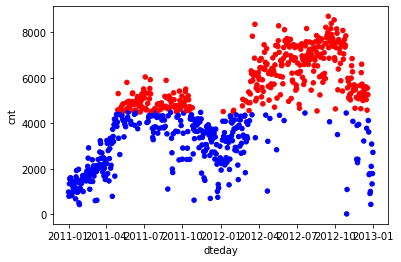

In [4]:
color = np.repeat('b', df.shape[0])
color[is_over_threshold] = 'r'
color
df.plot(x='dteday', y='cnt', kind='scatter', color=color)

I chose the threshold manually to yield similarly unbalanced training datasets.

In [6]:
np.sum(is_over_threshold[is_part1])

102

In [7]:
np.sum(~is_over_threshold[is_part1])

263

In [8]:
np.sum(is_over_threshold[~is_part1])

270

In [9]:
np.sum(~is_over_threshold[~is_part1])

96

I also remove the features yr and dteday from the dataset, because it doesn't contain usable information for the tasks.

In [10]:
feature_names = ['season', 'mnth', 'holiday', 'weekday', 'workingday',
                 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = df.loc[:, feature_names]
y = is_over_threshold.astype(int)

In [11]:
X_train1 = X[is_part1]
y_train1 = y[is_part1]
X_train2 = X[~is_part1]
y_train2 = y[~is_part1]

In [4]:
class XGBClassifierWithLogProbaPredict(xgboost.XGBClassifier, LogProbabilityMixin):
    pass

In [14]:
def make_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    skf = StratifiedKFold(n_splits=10)
    best_score = 0
    for train_index, test_index in skf.split(X_train, y_train):
        clf = XGBClassifierWithLogProbaPredict(n_jobs=4, use_label_encoder=False, eval_metric='logloss')
        clf.fit(X.iloc[train_index], y.iloc[train_index])
        score = clf.score(X.iloc[test_index], y.iloc[test_index])
        if score > best_score:
            best_clf, best_score = clf, score
        print(score)
    print(classification_report(y_test, best_clf.predict(X_test)))
    return best_clf

In [19]:
%%time
clf_a = make_classifier(X_train1, y_train1)

1.0
1.0
0.9310344827586207
0.8275862068965517
0.8620689655172413
0.6896551724137931
0.7586206896551724
0.6206896551724138
0.7931034482758621
0.6896551724137931
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        53
           1       0.91      1.00      0.95        20

    accuracy                           0.97        73
   macro avg       0.95      0.98      0.97        73
weighted avg       0.98      0.97      0.97        73

CPU times: user 2.77 s, sys: 441 ms, total: 3.21 s
Wall time: 13.2 s


In [20]:
%%time
clf_b = make_classifier(X_train2, y_train2)

0.9666666666666667
1.0
0.7931034482758621
0.8620689655172413
0.896551724137931
0.9655172413793104
0.9655172413793104
0.9655172413793104
0.9310344827586207
0.896551724137931
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.98      1.00      0.99        55

    accuracy                           0.99        74
   macro avg       0.99      0.97      0.98        74
weighted avg       0.99      0.99      0.99        74

CPU times: user 2.11 s, sys: 330 ms, total: 2.44 s
Wall time: 3.46 s


In [21]:
print(classification_report(y_train2, clf_a.predict(X_train2)))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57        96
           1       1.00      0.46      0.63       270

    accuracy                           0.60       366
   macro avg       0.70      0.73      0.60       366
weighted avg       0.84      0.60      0.61       366



In [22]:
import pickle

In [9]:
with open('classifiers.pickle', 'wb') as f:
    cloudpickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

In [25]:
comparer = ModelComparer(clf_a, clf_b, X.columns)

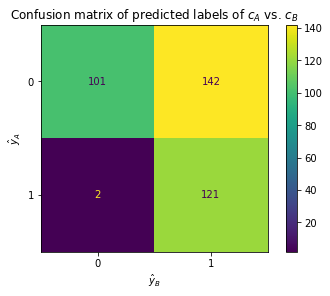

In [26]:
comparer.plot_confusion_matrix(X_train2)

We can see already, that A predicts a lot more often less than 4500 shares than B, reflected in the high number of instances in difference class $(0,1)$. On the contrary, only two instances fall into $(1,0)$.

In [27]:
is_pred_diff = comparer.predict_bin_diff(X_train2)
mclass_diff = comparer.predict_mclass_diff(X_train2)

In [28]:
import shap
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances

In [29]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X_train2, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])

Exact explainer: 367it [04:31,  1.33it/s]                         
Exact explainer: 367it [03:09,  1.83it/s]                         
Exact explainer: 367it [08:05,  1.35s/it]                         

CPU times: user 50min 11s, sys: 1min 45s, total: 51min 56s
Wall time: 15min 45s


In [32]:
with open('shap-values.pickle', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite), f, pickle.HIGHEST_PROTOCOL)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

Both classifiers have the same most important feature: `temp`. Besides that, they're quite different.
`mnth`, `hum`, `atemp`, `weekday`, `workingday` are of bigger importance to A than to B.
`mnth` is also the feature with the biggest difference of feature importance.
`season`, `weathersit` are of higher importance to B than to A.
Finally, `holiday` has no significant importance to either classifiers.
Therefore I will omit it from further explanations.

Based on this, I can speculate about the following theories:
- Both classifiers are influenced by time of the year: A more by month, B more by season
- Both classifiers are influenced by weather conditions: A more by temperature and humidity, B more by weathersituation
- holiday is not used to make decisions, because workingday is already sufficient
- B depends less on weekday and workingday, possibly indicating a shift of habits

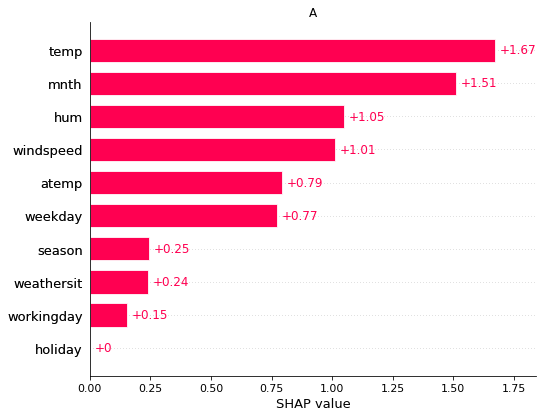

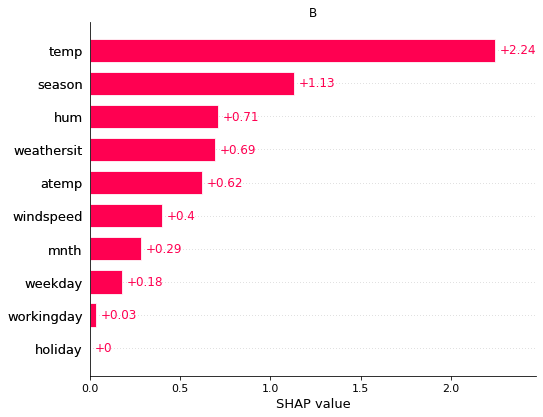

In [4]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [5]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds[:, :, 1])

In [6]:
feature_order = feature_order[:9]

In [7]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_idx], 1])
    plot_feature_effects(explanations.indiv.log_odds[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

In the SHAP summary plot we can see, that the most important feature `temp`
generally indicates an increase in log odds for high values
and a decrease in log odds for low values.
But the distribution is different:
For A, low feature values indicate a very specific decrease of log odds.
On the contrary, there is a wide range of different SHAP values for B.
This indicates, that there are many different ways low temperature values influences the prediction in B,
but only a few in A.

For A, we can see a stepped effect from low to high feature values with the step at 0.5,
which gradually decreases again at 0.7.
For B, the effect of `temp` gradually increases, starting from 0.3 until it reaches its maximum at 0.5.

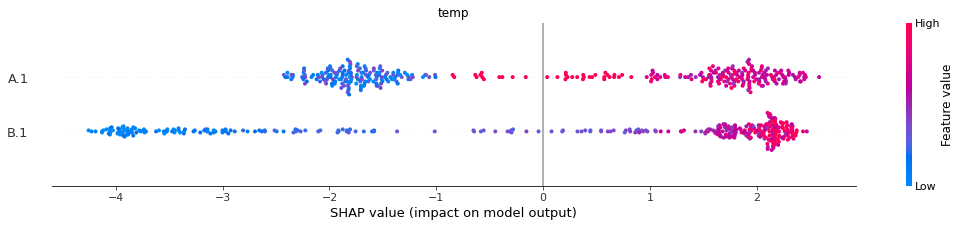

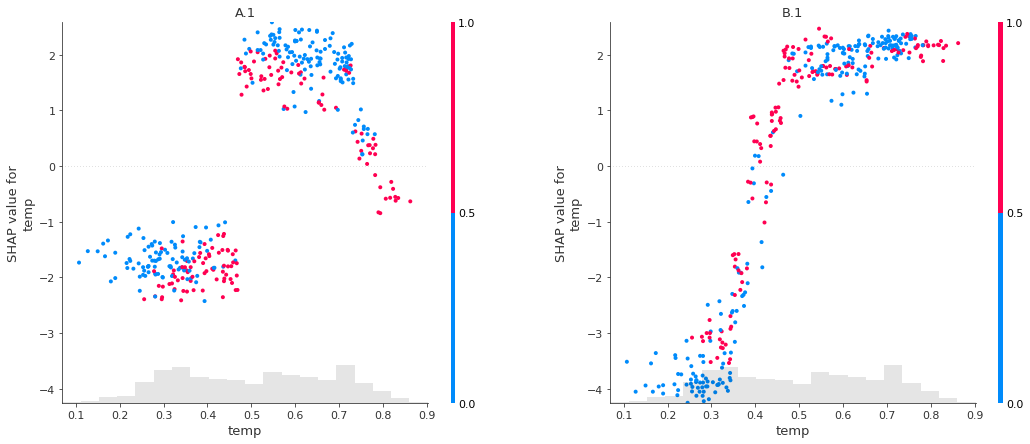

In [8]:
plot_next_feature()

As previously noted in the feature importance section, `mnth` is much more important
to A than to B. Higher feature values increase the log odds prediction to a varying extent in A,
whereas in B they nearly have no influence. Lower feature values decrease the log odds prediction
in A, but there are instances in B where they either increase or decrease the log odds prediction.

According to the feature effects plots, the first four months have a negative effect while the
higher months have a positive effect on the outcome of A.
For B, only the first two months have a negative effect and especially month 3 has a positive effect.

Similarly to the effects plots of `temp`, we see
a vertical separation of instances classified differently and equally, which means,
interaction effects are present.

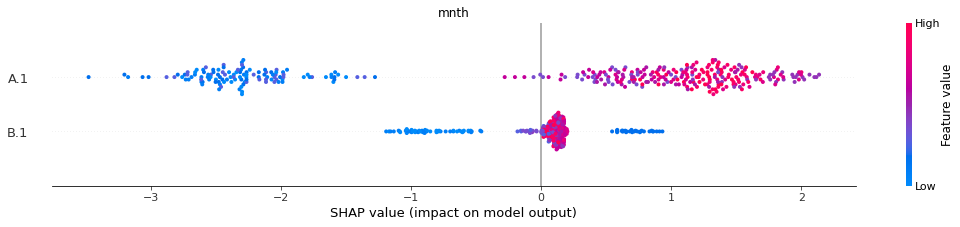

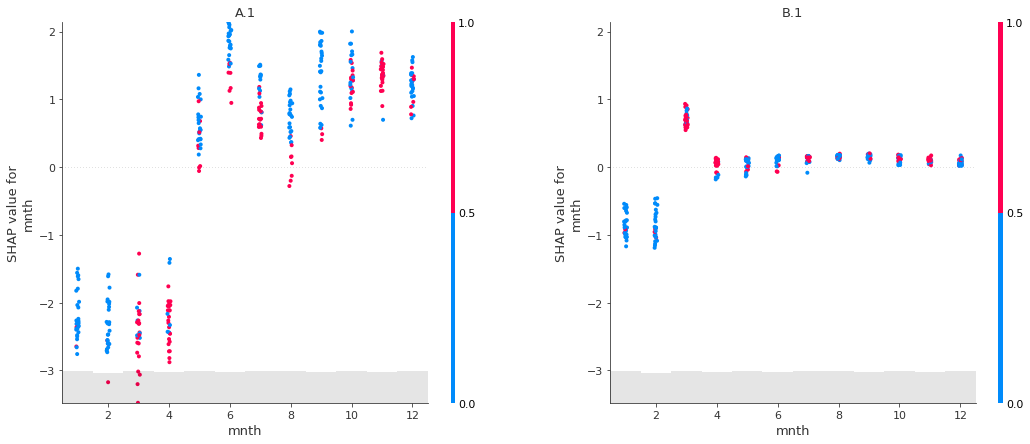

In [9]:
plot_next_feature()

For both classifiers, high `hum` values decrease the log odds outcome to a similar extent.
But the lower values are different. In B, they flat out between 0.5 and 1, but in A,
they continue to increase for lower values. This means, that in B, there are not many ways
how low values of `hum` can influence the outcome, but there are many for A.

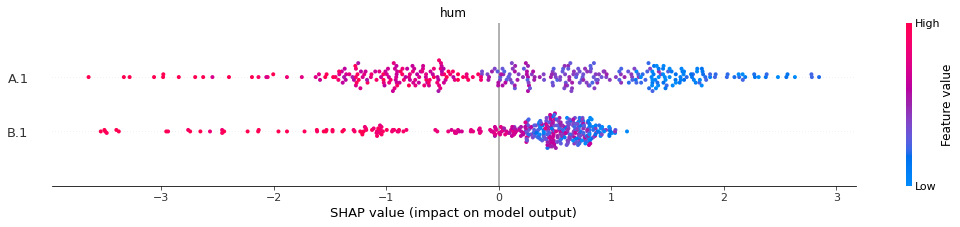

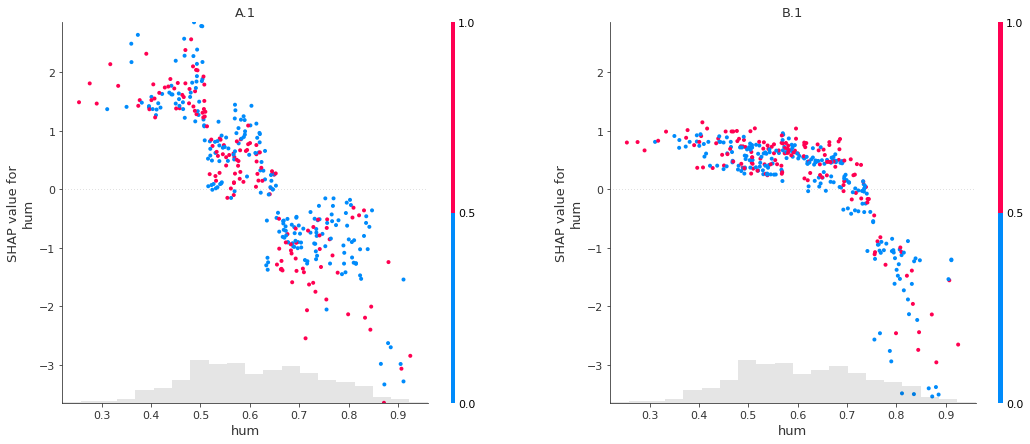

In [10]:
plot_next_feature()

High feature values of `atemp` influence the models differently:
For A, it has quite diverse effects ranging from -3 to +2, whereas for B,
it just indicates a small positive influence.

The effects look similar, except for values above 0.7,
where all instances are classified differently.
Here we observe a negative influence on A but positive influence on B.

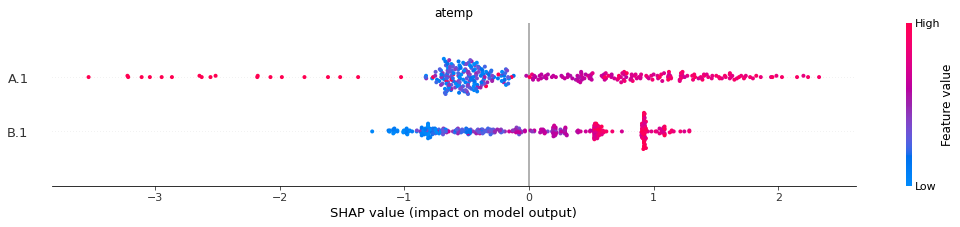

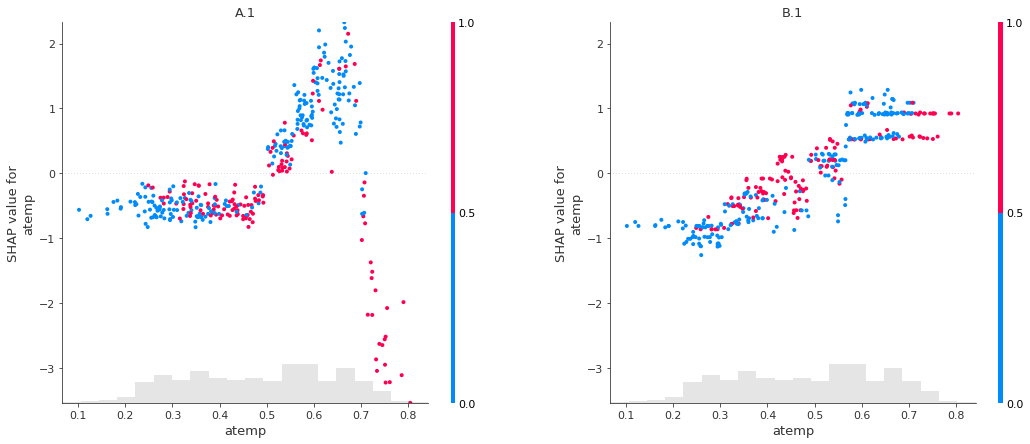

In [11]:
plot_next_feature()

Windspeed has higher and more pronounced influence on model A than B, with low feature
values increasing and high feature values decreasing the outcome.

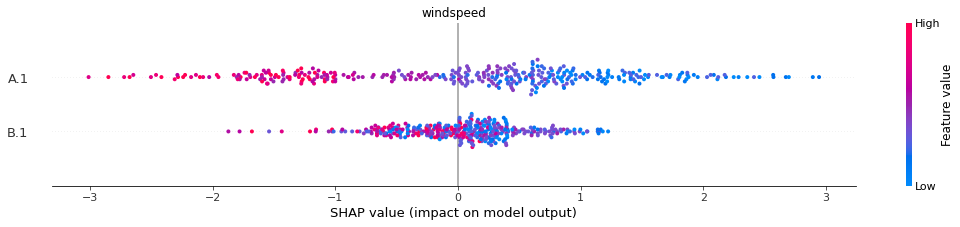

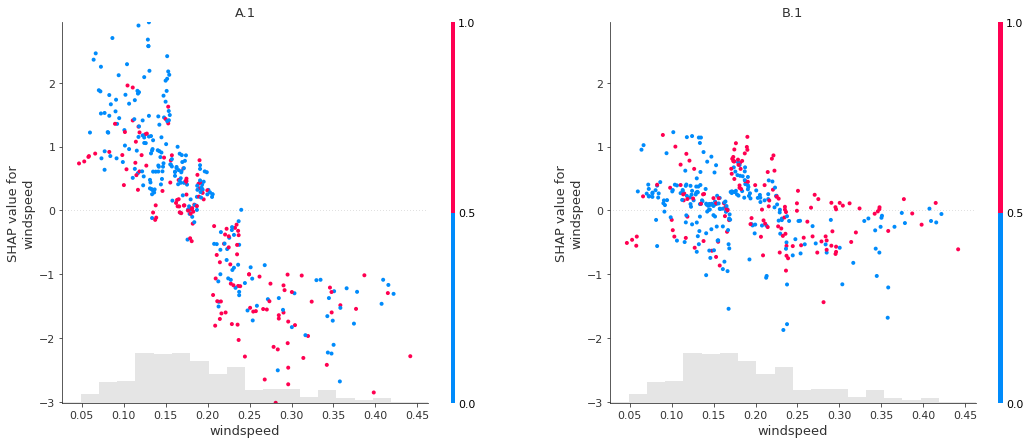

In [12]:
plot_next_feature()

`season` 1 (winter) has much bigger negative influence on model B than on A, with a broader
range of values. To instances classified differently in this group the effect is smaller,
originating from interaction effects with other features.
The other seasons have higher increasing effect to B than A.

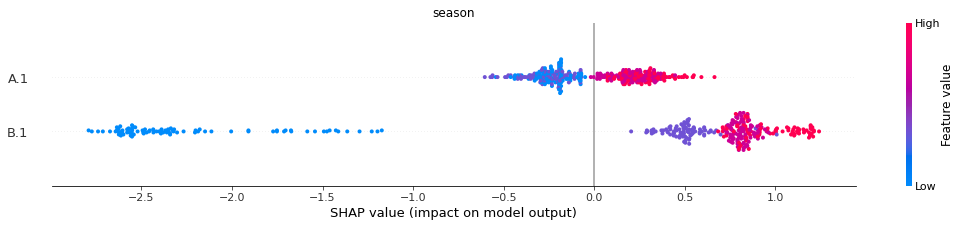

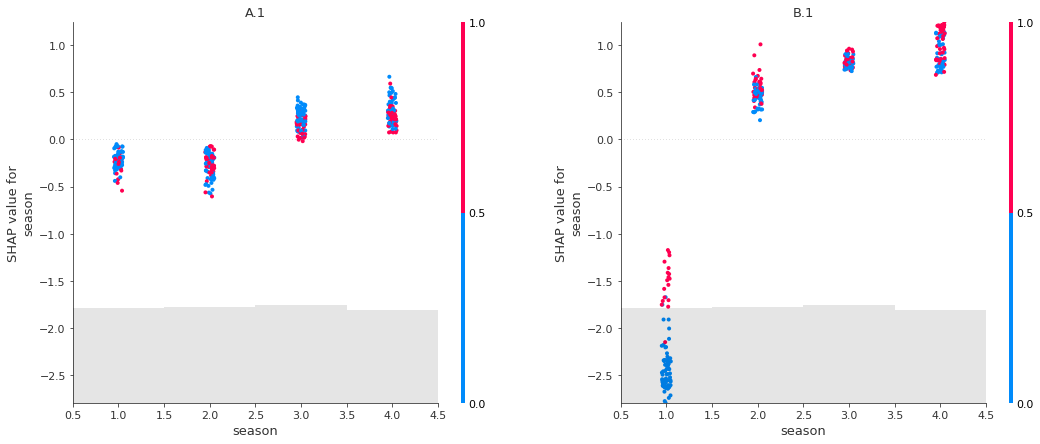

In [13]:
plot_next_feature()

Even though the influences of `weekday` on model B are small and decreasing from low (Sunday)
to high (Saturday) values,
they are the opposite of those on model A.

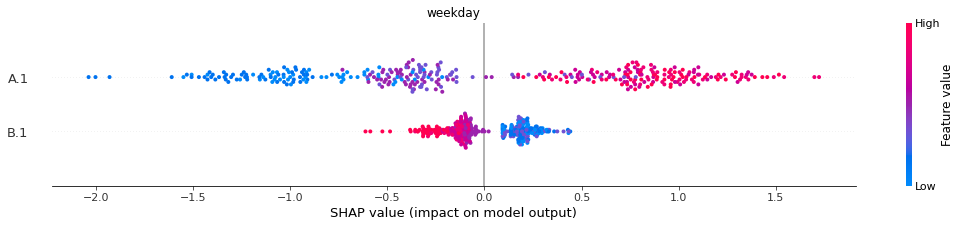

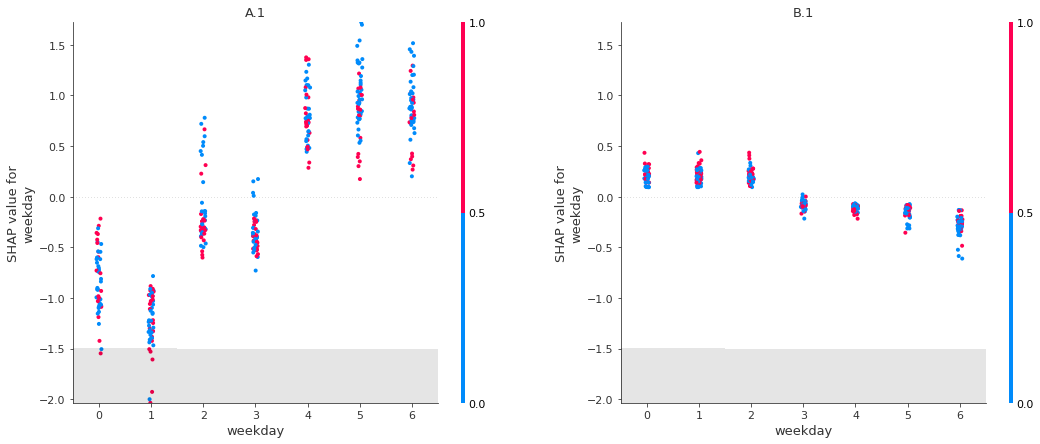

In [14]:
plot_next_feature()

For B, high values of `weathersit` (snow and rain) have bigger negative influence and low values
(clear to mist) have bigger positive influence than for A. It is possibly a better predictor
in the newer model than `windspeed` and `hum` combined.

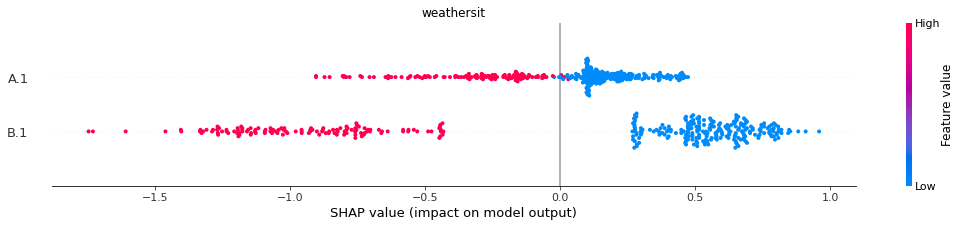

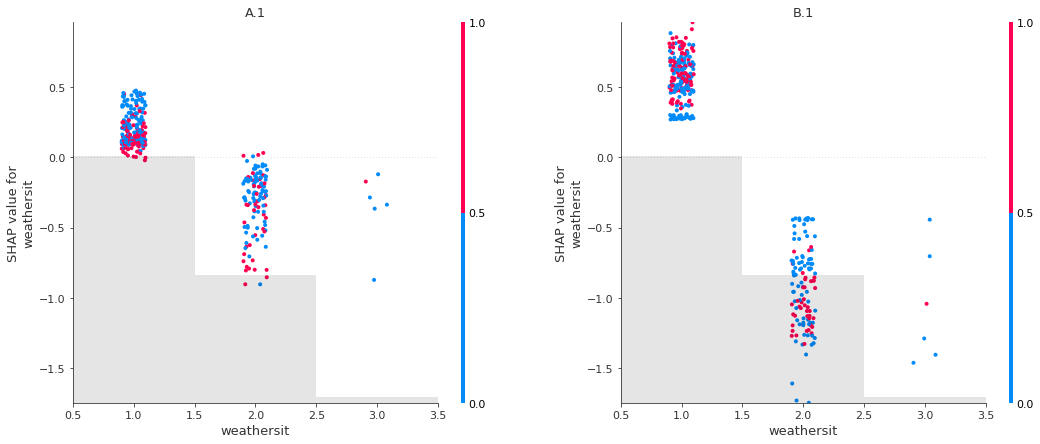

In [15]:
plot_next_feature()

`workingday` is considered more important by A, which also shows a clearer separation
of low and high values, low values (weekend or holiday) having positive influence on the outcome.
To B, it seems to be random noise with no special influence of low or high values,
and no characteristics of instances classified differently.
I assume that model A differentiates
more between work and leisure time, with more people using bicycles in their leisure time
and/or in the second half of the week, reasons not present in model B.

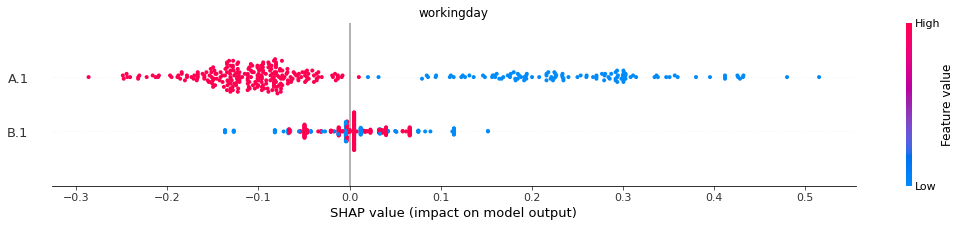

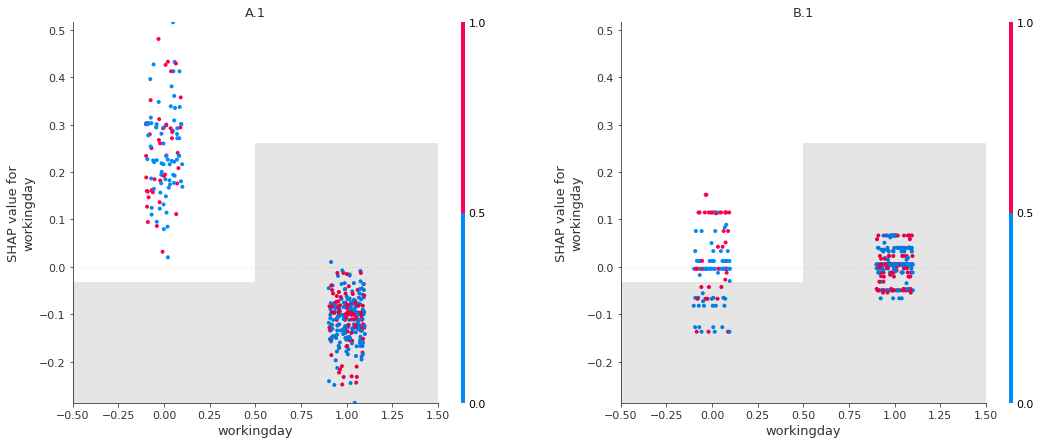

In [16]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

In the figure below we can see the feature importances per class.
`temp` is the most important feature overall and for $(0,1)$, like it is for the individual classifiers.
But for class $(1,0)$, `mnth` is the most important feature. `holiday` does not have any (visible) importance, and `workingday` has relatively low importance for all classes.

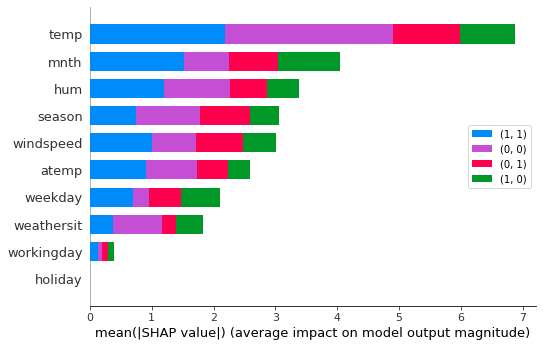

In [5]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(explanations.mclass_diff.log_odds)

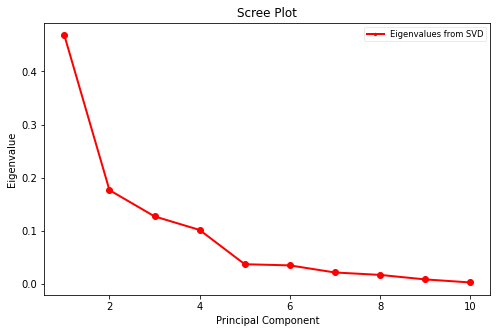

In [6]:
from matplotlib.font_manager import FontProperties

values = explanations.mclass_diff.log_odds.values
values = values.reshape((values.shape[0] * values.shape[2], values.shape[1]))
#Make a random array and then make it positive-definite
num_vars = values.shape[1]
num_obs = values.shape[0]
U, S, V = np.linalg.svd(values) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
#leg.draggable(state=True)
plt.show()

In [7]:
eigvals

array([0.46775483, 0.17692083, 0.12758777, 0.10205286, 0.03770495,
       0.03551811, 0.02218871, 0.0176371 , 0.00917643, 0.00345841])

In [9]:
S

array([84.03742159, 51.68363684, 43.89025488, 39.25329956, 23.85957717,
       23.15733206, 18.30330834, 16.31838306, 11.77064956,  7.2260646 ])

Generally, I could restrict the number of features to analyze by cutting off at the knee point, but in this case I'm interested in comparing the results to the individual classifiers' explanations, so I include all features that I analyzed previously.

5

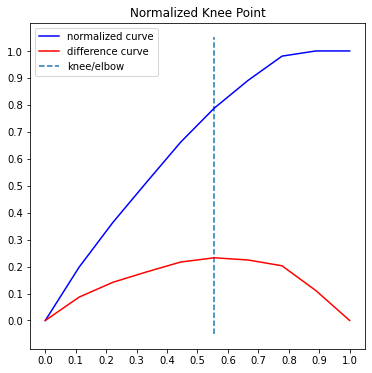

In [5]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
# feature_order = feature_order[:n_important_features]
n_important_features

In [6]:
feature_order = feature_order[:-1]

Considering that there are only four classes and all have importance, I will stick to the original ordering.

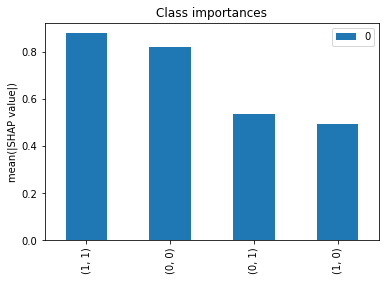

In [7]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [8]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [feature_idx]])
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx]], color=is_pred_diff)
it = iter(feature_order)

For instances with low feature values ($temp<0.3$), this feature increases the outcome for class $(0,0)$ extremely,
for most of them by more than 4. Until 0.5, there is a drop in log odds of this class
and first an increase of $(1,0)$, then an even higher increase of $(0,1)$.
Many instances classified differently fall into this range.
Above 0.5, there is a sudden increase of $(1,1)$, which gets lower
at 0.7 while getting higher for $(0,1)$ again, also containing
many instances classified differently.

Even though this is the feature of highest importance for the differences,
its explanation does not cover all instances. Especially for those with
$0.5<temp<0.7$, this feature cannot be the reason for them being classified
differently.

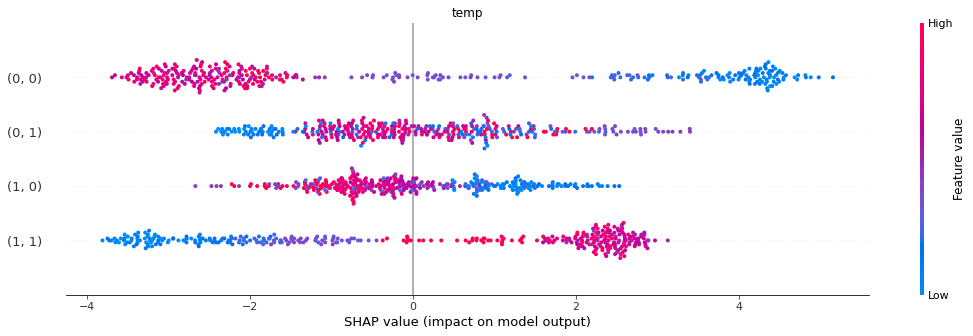

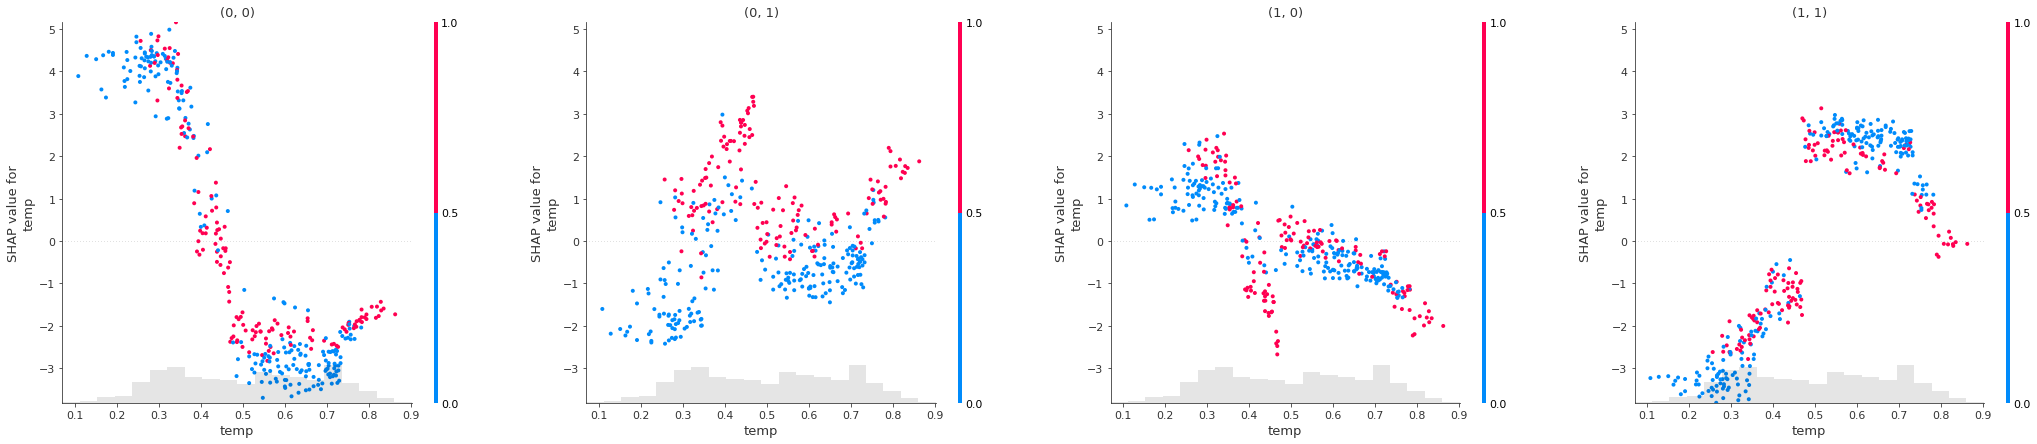

In [9]:
plot_next_feature()

Starting with the first two values of `mnth`, this feature has an increasing effect on the outcome of $(0,0)$,
with nearly no instances classified differently.
For months 3 and 4 it primarily increases the odds of $(0,1)$.
Continuing with higher values, it increases the odds to a varying degree of $(1,1)$ and $(1,0)$ to a lower extent.

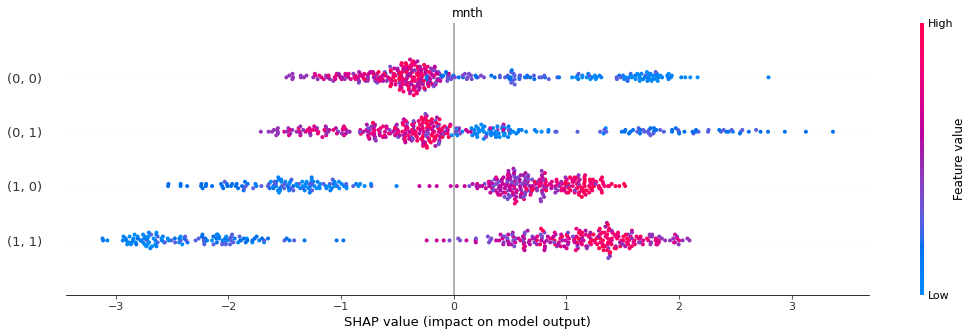

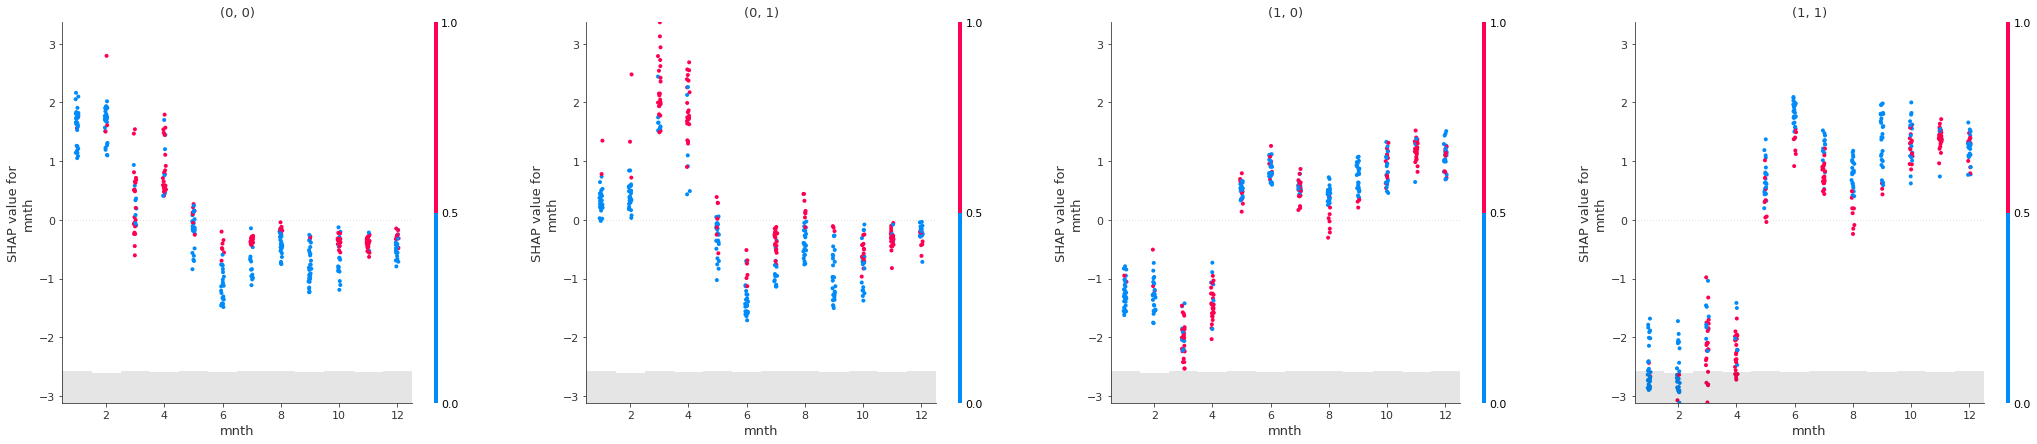

In [10]:
plot_next_feature()

Generally, for this feature there is positive correlation
with its increase in outcome of $(0,0)$ and negative correlation with its
increase in outcome of $(1,1)$.

Nevertheless, for instances with values around 0.7 there is a slight increase
in the outcome of $(0,1)$ and for instances with values below 0.5 and above
0.75 there is a slight increase in the outcome of $(1,0)$.

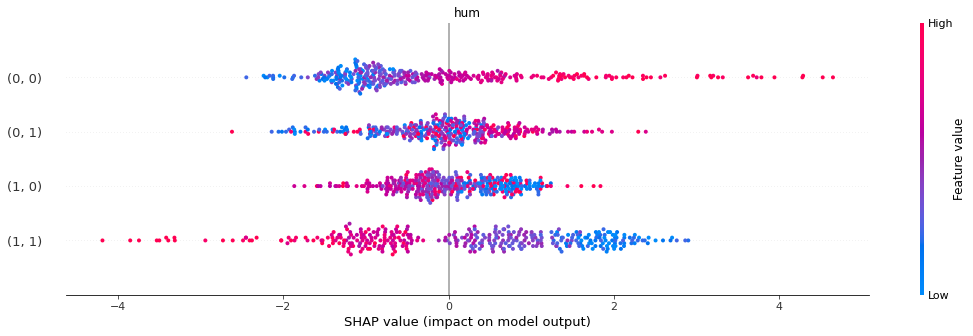

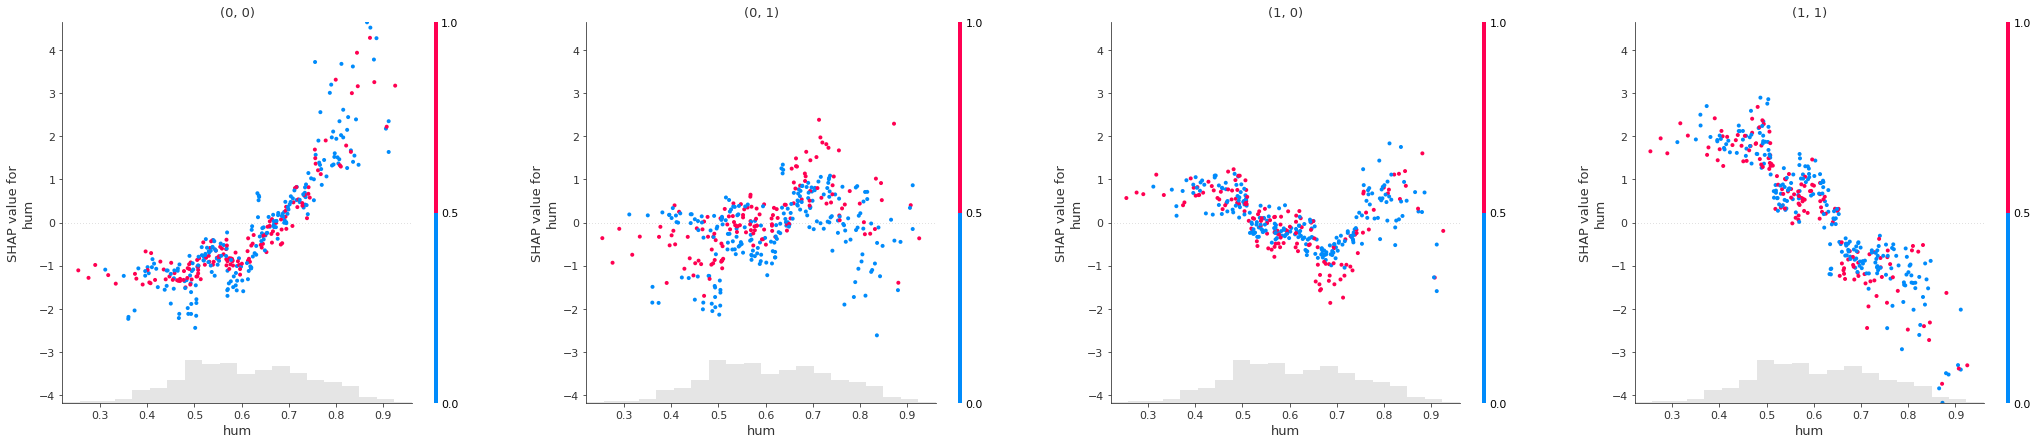

In [11]:
plot_next_feature()

For instances with low `season` values (winter) the feature has an increasing effect on the odds of $(0,0)$,
and to a lower extent of $(1,0)$. But for those that are classified differently the increasing effect
is on the lower side and the decreasing effect on $(0,1)$ is smaller too, suggesting interaction effects
with other features. For instances of spring,
summer and fall the feature has a low increasing effect on the odds of $(1,1)$ and $(0,1)$.

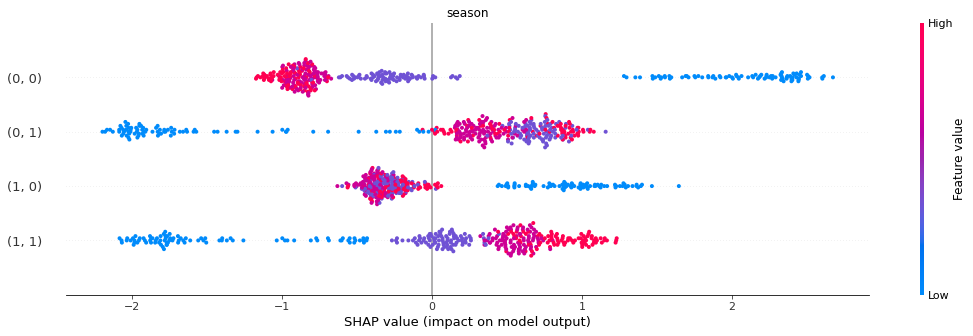

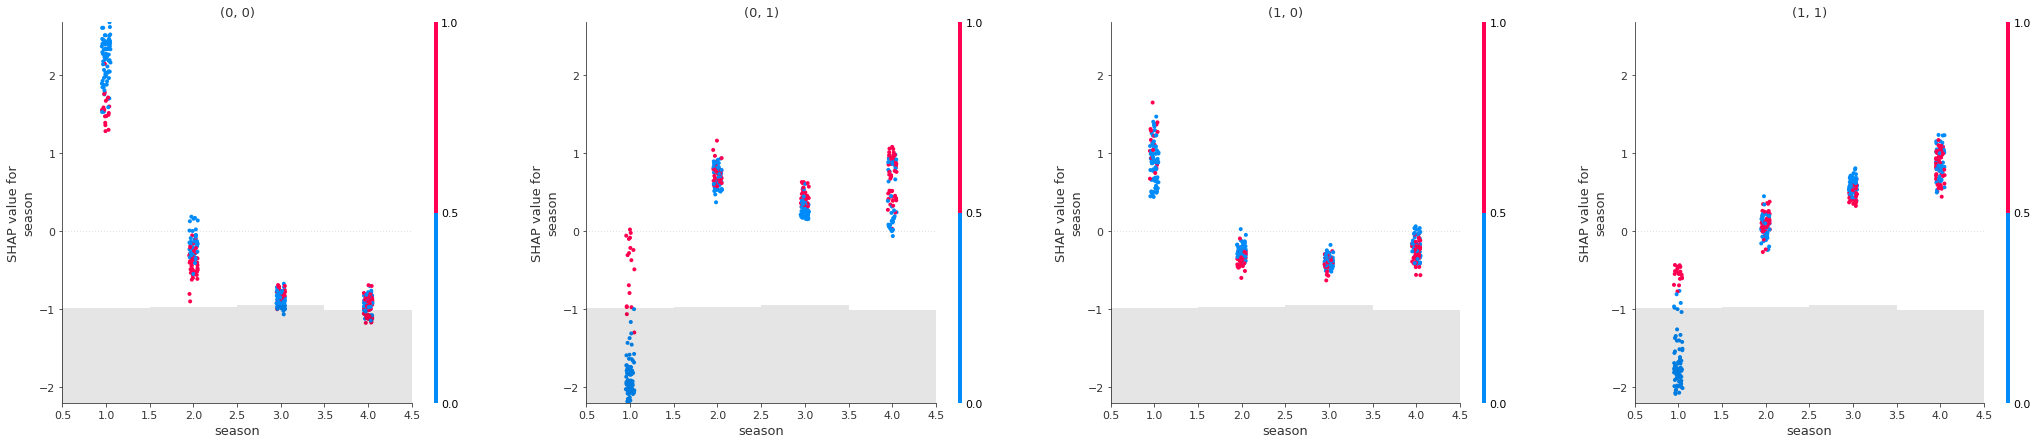

In [12]:
plot_next_feature()

For `windspeed`, there is a positive correlation with the effect on $(0,0)$ and $(0,1)$,
and a negative correlation with the effect on $(1,1)$ and $(1,0)$ to a lower extent.

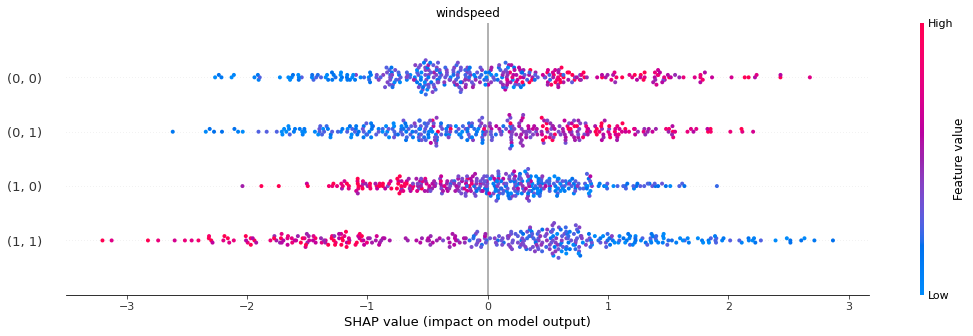

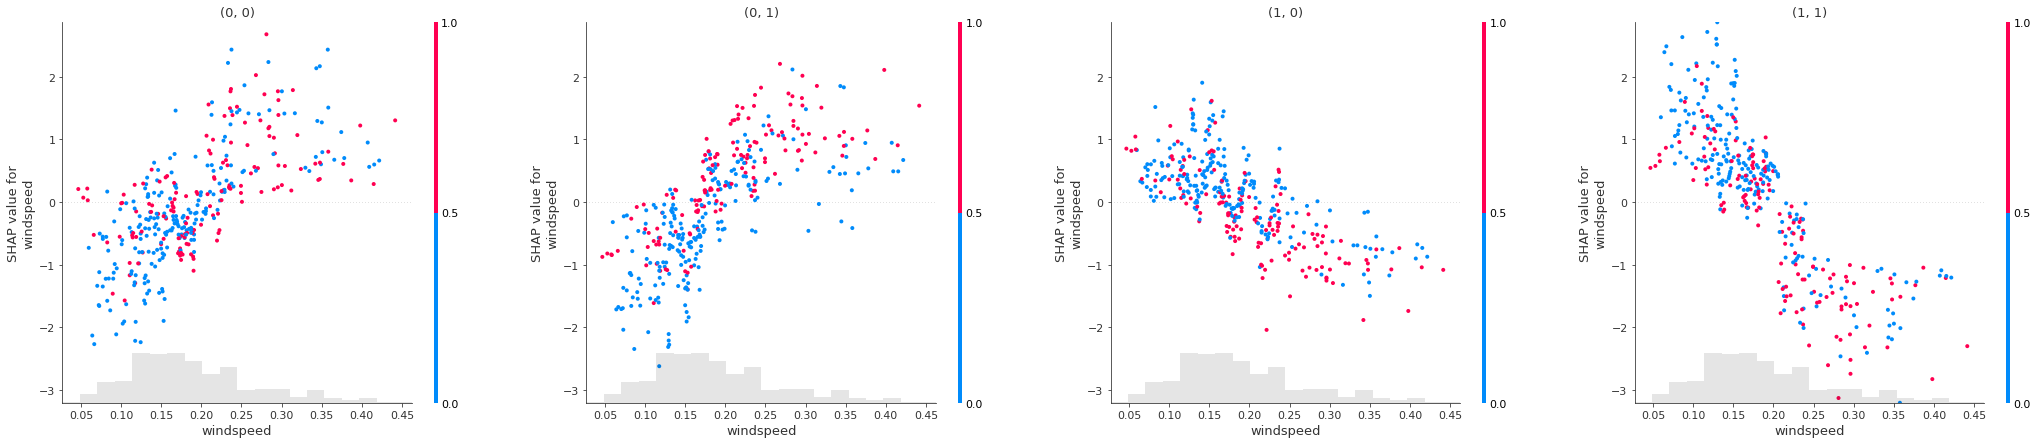

In [13]:
plot_next_feature()

For instances with low `atemp` values this feature has a slightly increasing
effect on $(0,0)$. Up to 0.5, its effect decreases while the effect on $(0,1)$
increases slightly. Up to 0.7, the effect on $(0,1)$ decreases again
but increases on $(1,1)$, with fewer instances classified differently in this range.
Above, the effect on $(1,1)$ drops to negative values while it increases
dramatically on $(0,1)$, where all instances are classified differently.
`atemp` is probably the main reason for them being classified differently.

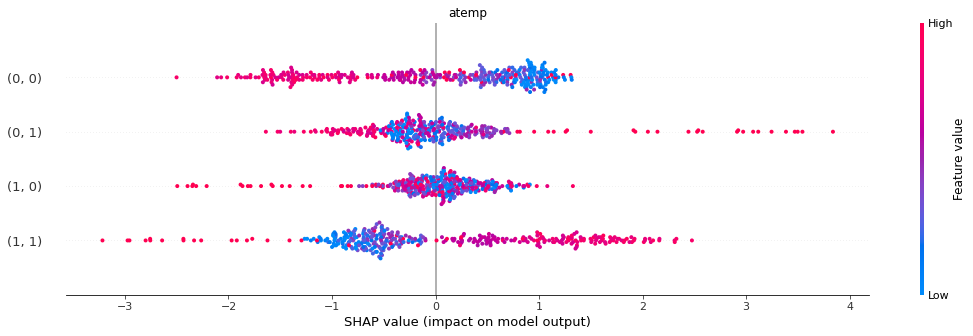

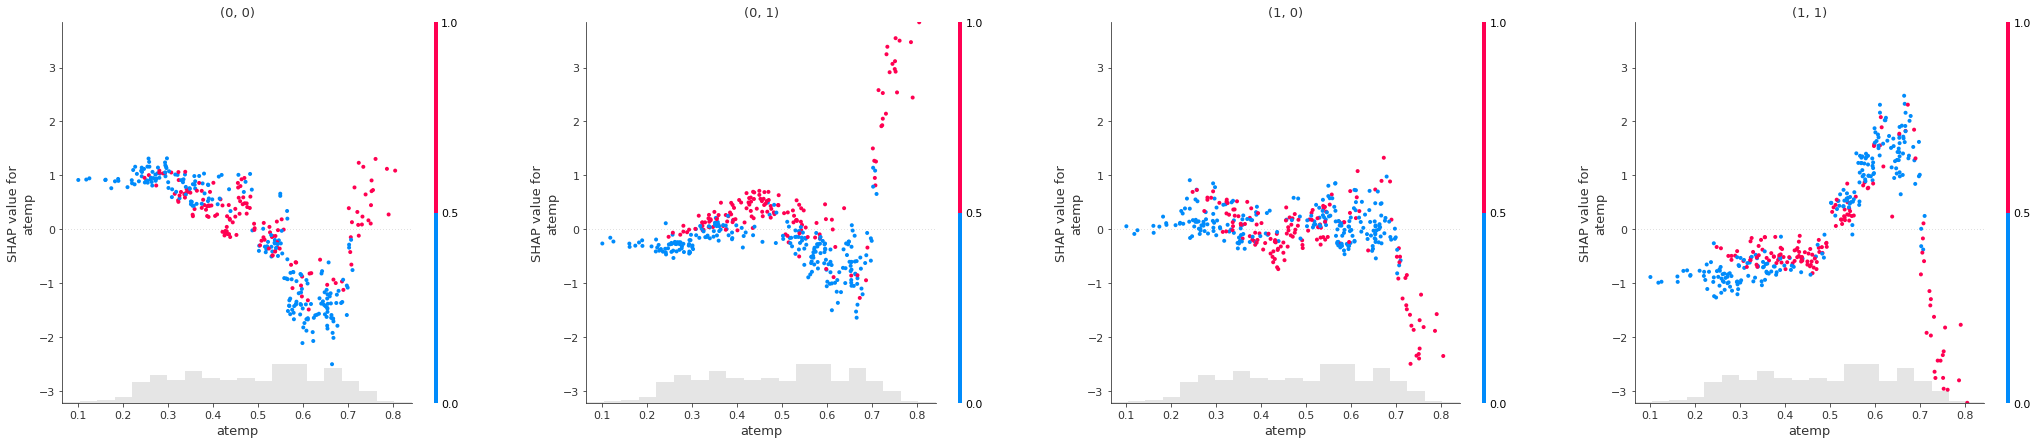

In [14]:
plot_next_feature()

For instances with low `weekday` values (Sunday and Monday) the feature has an increasing effect
on the odds of $(0,1)$ and to a lower extent of $(0,0)$,
while for those with high feature values (Friday, Saturday and Sunday) it has an increasing effect for the odds
of $(1,0)$ and $(1,1)$.

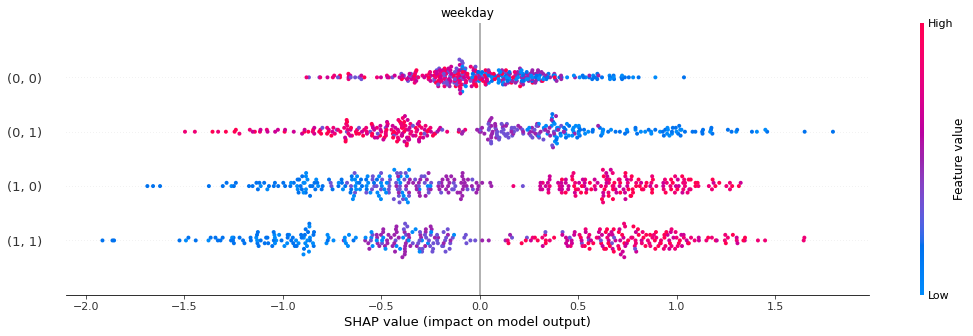

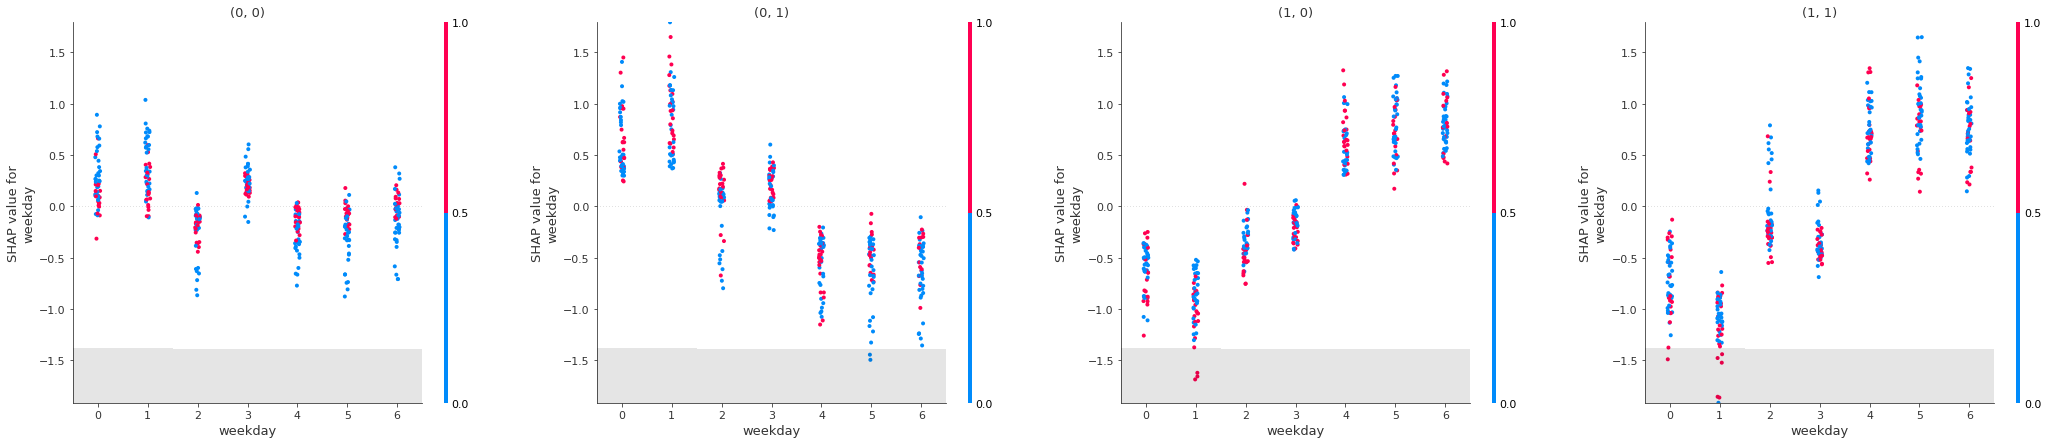

In [15]:
plot_next_feature()

For instances with `weathersit` 1 (clear) the feature has a slightly 
increasing effect on $(1,1)$. For instances with values 2 or 3 (bad weather
conditions) it has an increasing effect on $(0,0)$ and to a lower extent
on $(1,0)$.

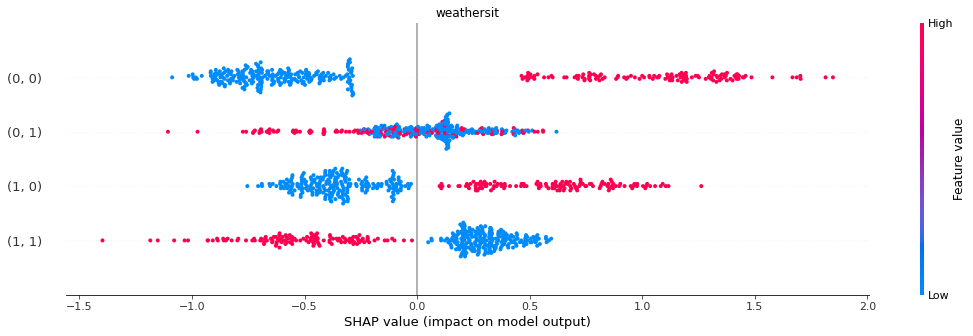

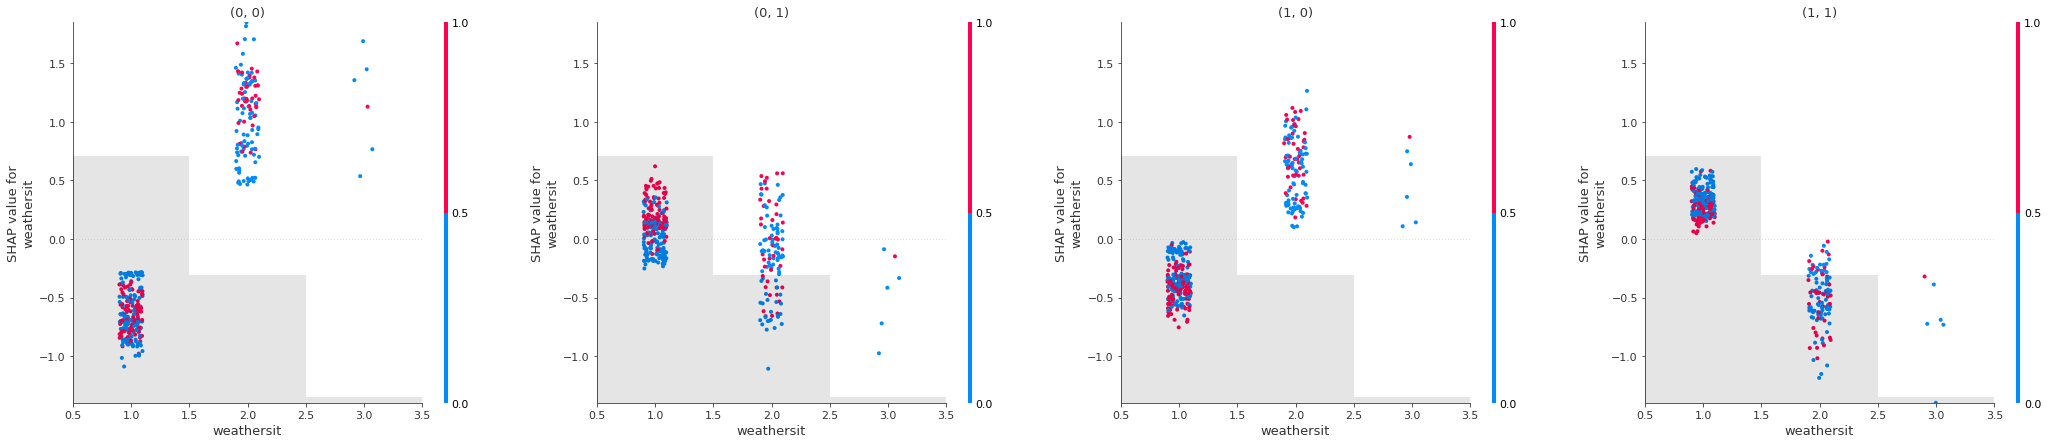

In [16]:
plot_next_feature()

For workingday we can see only a slight linear effect with big variance that tends towards $(1,0)$ and $(1,1)$ for value 0, and towards $(0,0)$ and $(0,1)$ for value 1.

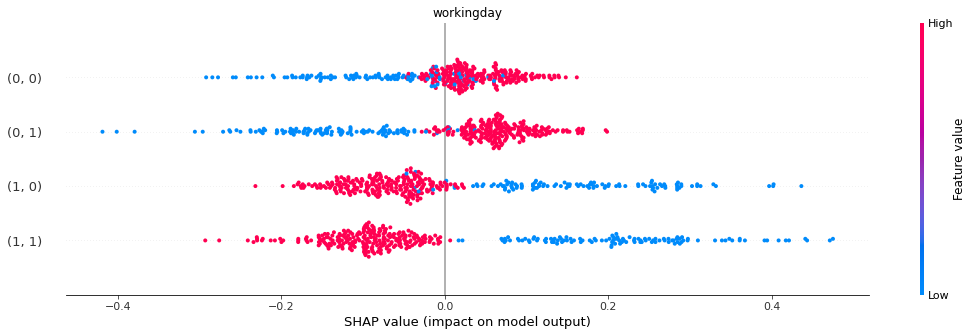

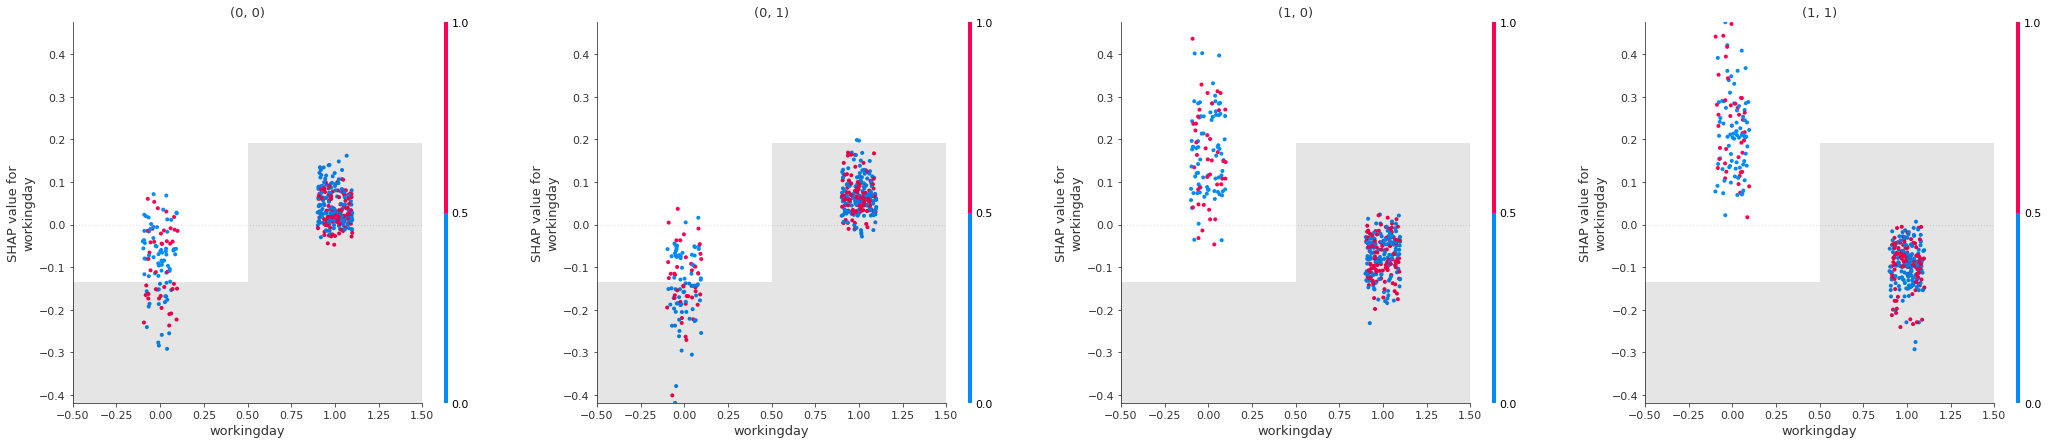

In [17]:
plot_next_feature()

# Local Explanations

diro2c works with integers only, so I need to scale some features:

In [4]:
scale_features = {'temp': 100, 'windspeed': 100, 'hum': 100, 'atemp': 100}

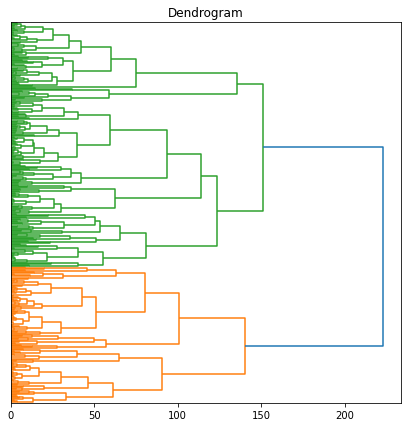

In [5]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.log_odds)
plot_dendrogram(linkage_matrix)

Although it is better to build a clustering where there is only one difference class per cluster, I decided to stick with the clustering at $n=5$. At $n=50$, c1 is split into separate clusters, so this means the instances in the cluster are very similar. So they should stick together for further analysis.

In [6]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=5)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c1      18      31       2       1
c2      75       4       0       0
c3       0      95       0      64
c4       8       5       0       0
c5       0       7       0      56

In [78]:
def get_next_cluster():
    cluster = next(cluster_it)
    shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    diff_classes = comparer.difference_class_names[occurences.loc[cluster, comparer.difference_class_names] > 0]
    classes = np.unique(pred_class_names)
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names, diff_classes, classes
cluster_it = iter(clusters_of_interest)

## 1. Cluster

In [31]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c1      18      31       2       1

The following feature value distributions are different locally and globally:
- temp and atemp cover only the range 0.25 until 0.45
- season is 4 (except for one outlier)
- mnth is 10-12 (except for one outlier)
- hum does not cover the lowest values around 0.3
- weathersit is 1-2

Comparing that to the global level, we can reason for instances in this cluster that:
- `temp` below 0.25 would maximize its influence towards $(0,0)$; in this range it is at its maximum for $(0,1)$
- `temp` above 0.45 (up to 0.75) would increase its influence towards $(1,1)$
- if `season` was 1 and `mnth` was 1, their influence towards $(0,0)$ would be maximized

Yet these effects do not explain why some instances in this cluster are classified differently and some are not. By using the local explanations only I can reason that:
- if temp was low (0.2), its influence towards $(0,0)$ would increase
- if mnth and season were low (1 and 1), their influence towards $(0,0)$ would increase
- if windspeed was high (0.25), its influence towards $(0,0)$ would increase
- if hum was high (0.75), its influence towards $(0,0)$ would increase
- if temp was high (0.44), its influence on instances originally classified $(1,0)$ towards $(1,1)$ would increase

In [68]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

season       mnth    holiday    weekday  workingday  weathersit  \
count  52.000000  52.000000  52.000000  52.000000   52.000000   52.000000   
mean    3.961538  11.057692   0.038462   3.019231    0.653846    1.480769   
std     0.277350   1.178458   0.194184   2.053122    0.480384    0.504505   
min     2.000000   4.000000   0.000000   0.000000    0.000000    1.000000   
25%     4.000000  11.000000   0.000000   1.000000    0.000000    1.000000   
50%     4.000000  11.000000   0.000000   3.000000    1.000000    1.000000   
75%     4.000000  12.000000   0.000000   5.000000    1.000000    2.000000   
max     4.000000  12.000000   1.000000   6.000000    1.000000    2.000000   

            temp      atemp        hum  windspeed  
count  52.000000  52.000000  52.000000  52.000000  
mean    0.339030   0.339968   0.635048   0.175038  
std     0.044835   0.046221   0.135800   0.077891  
min     0.245833   0.248742   0.333478   0.046650  
25%     0.298333   0.306337   0.537604   0.126720  
50%     0.341250   0.338373   0.621875   0.168846  
75%     0.366458   0.371362   0.708646   0.213396  
max     0.446667   0.438112   0.925000   0.376871

In [69]:
df['season'].value_counts()

4.0    51
2.0     1
Name: season, dtype: int64

In [70]:
df['mnth'].value_counts()

11.0    29
12.0    16
10.0     6
4.0      1
Name: mnth, dtype: int64

In [71]:
df['weathersit'].value_counts()

1.0    27
2.0    25
Name: weathersit, dtype: int64

### SHAP-based Difference Classifier Explanations

`temp` is more important to instances in this cluster than on the global level. 
`season` is also more important.
`mnth`, `weekday`, `hum`, `atemp` are less important in this cluster.

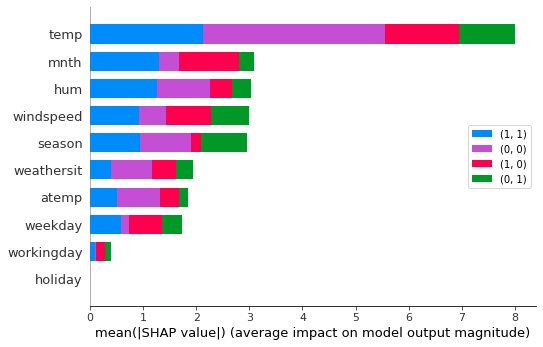

In [25]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

4

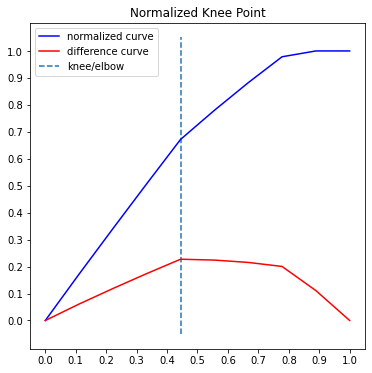

In [32]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

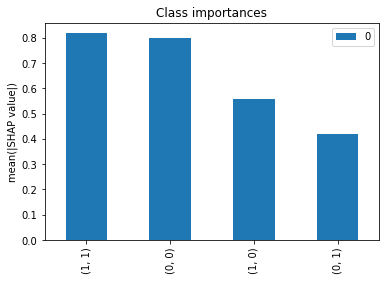

In [33]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [45]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    plot_feature_effects_comparison(**{'equally classified:': shap_values[np.in1d(pred_classes, comparer.equality_class_names)][:, [feature_idx]],
                                       'classified (0, 1):': shap_values[pred_classes == '(0, 1)'][:, [feature_idx]],
                                       'classified (1, 0):': shap_values[pred_classes == '(1, 0)'][:, [feature_idx]]})
it = iter(feature_order)

Although we can see strong linear effects, they only apply locally to this cluster. From the global effects plot we know, that above 0.45 there is a rapid increase of class $(1,1)$'s log odds influence, and below 0.25, all instances are classified $(0,0)$. Between 0.2 and 0.45, lower values tend to increase the log odds for $(0,0)$, higher values $(0,1)$. But this does not explain why part of  these instances was classified differently, because the effects are similar.

Yet if temp was increased to 0.45, its effect would shift from $(1,0)$ towards $(1,1)$.

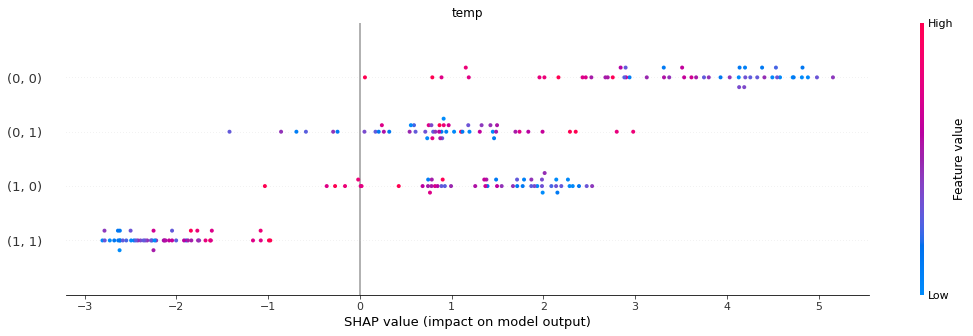

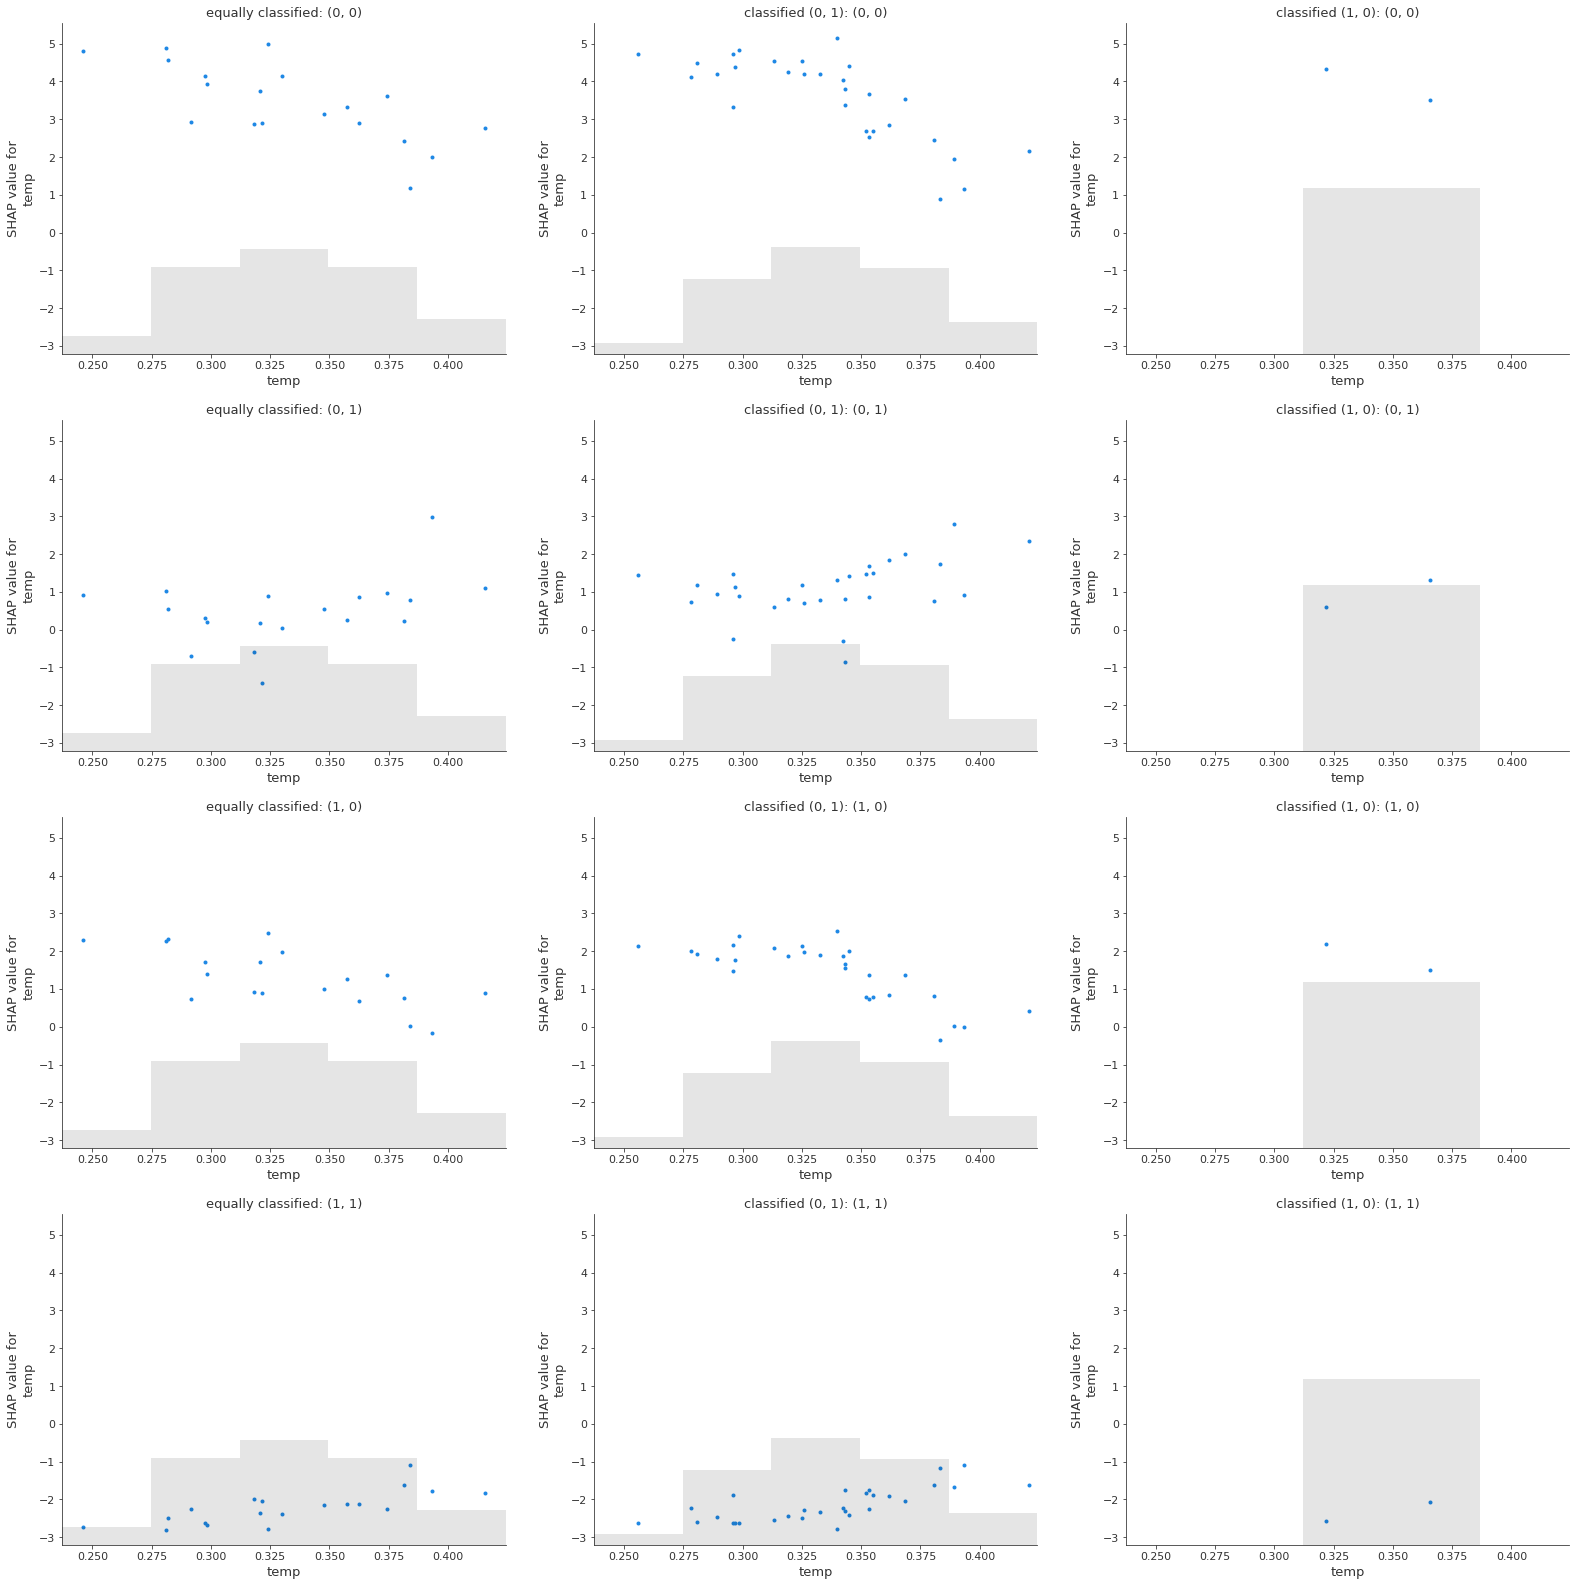

In [46]:
plot_next_feature()

One outlier is not shown for mnth, its value is 1. From the global effects we know, that if mnth was 1, the odds for $(0,0)$ would increase heavily. But locally, no effects are visible.

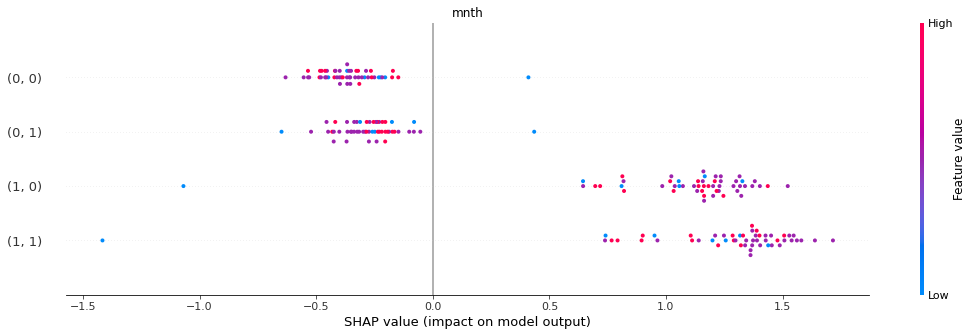

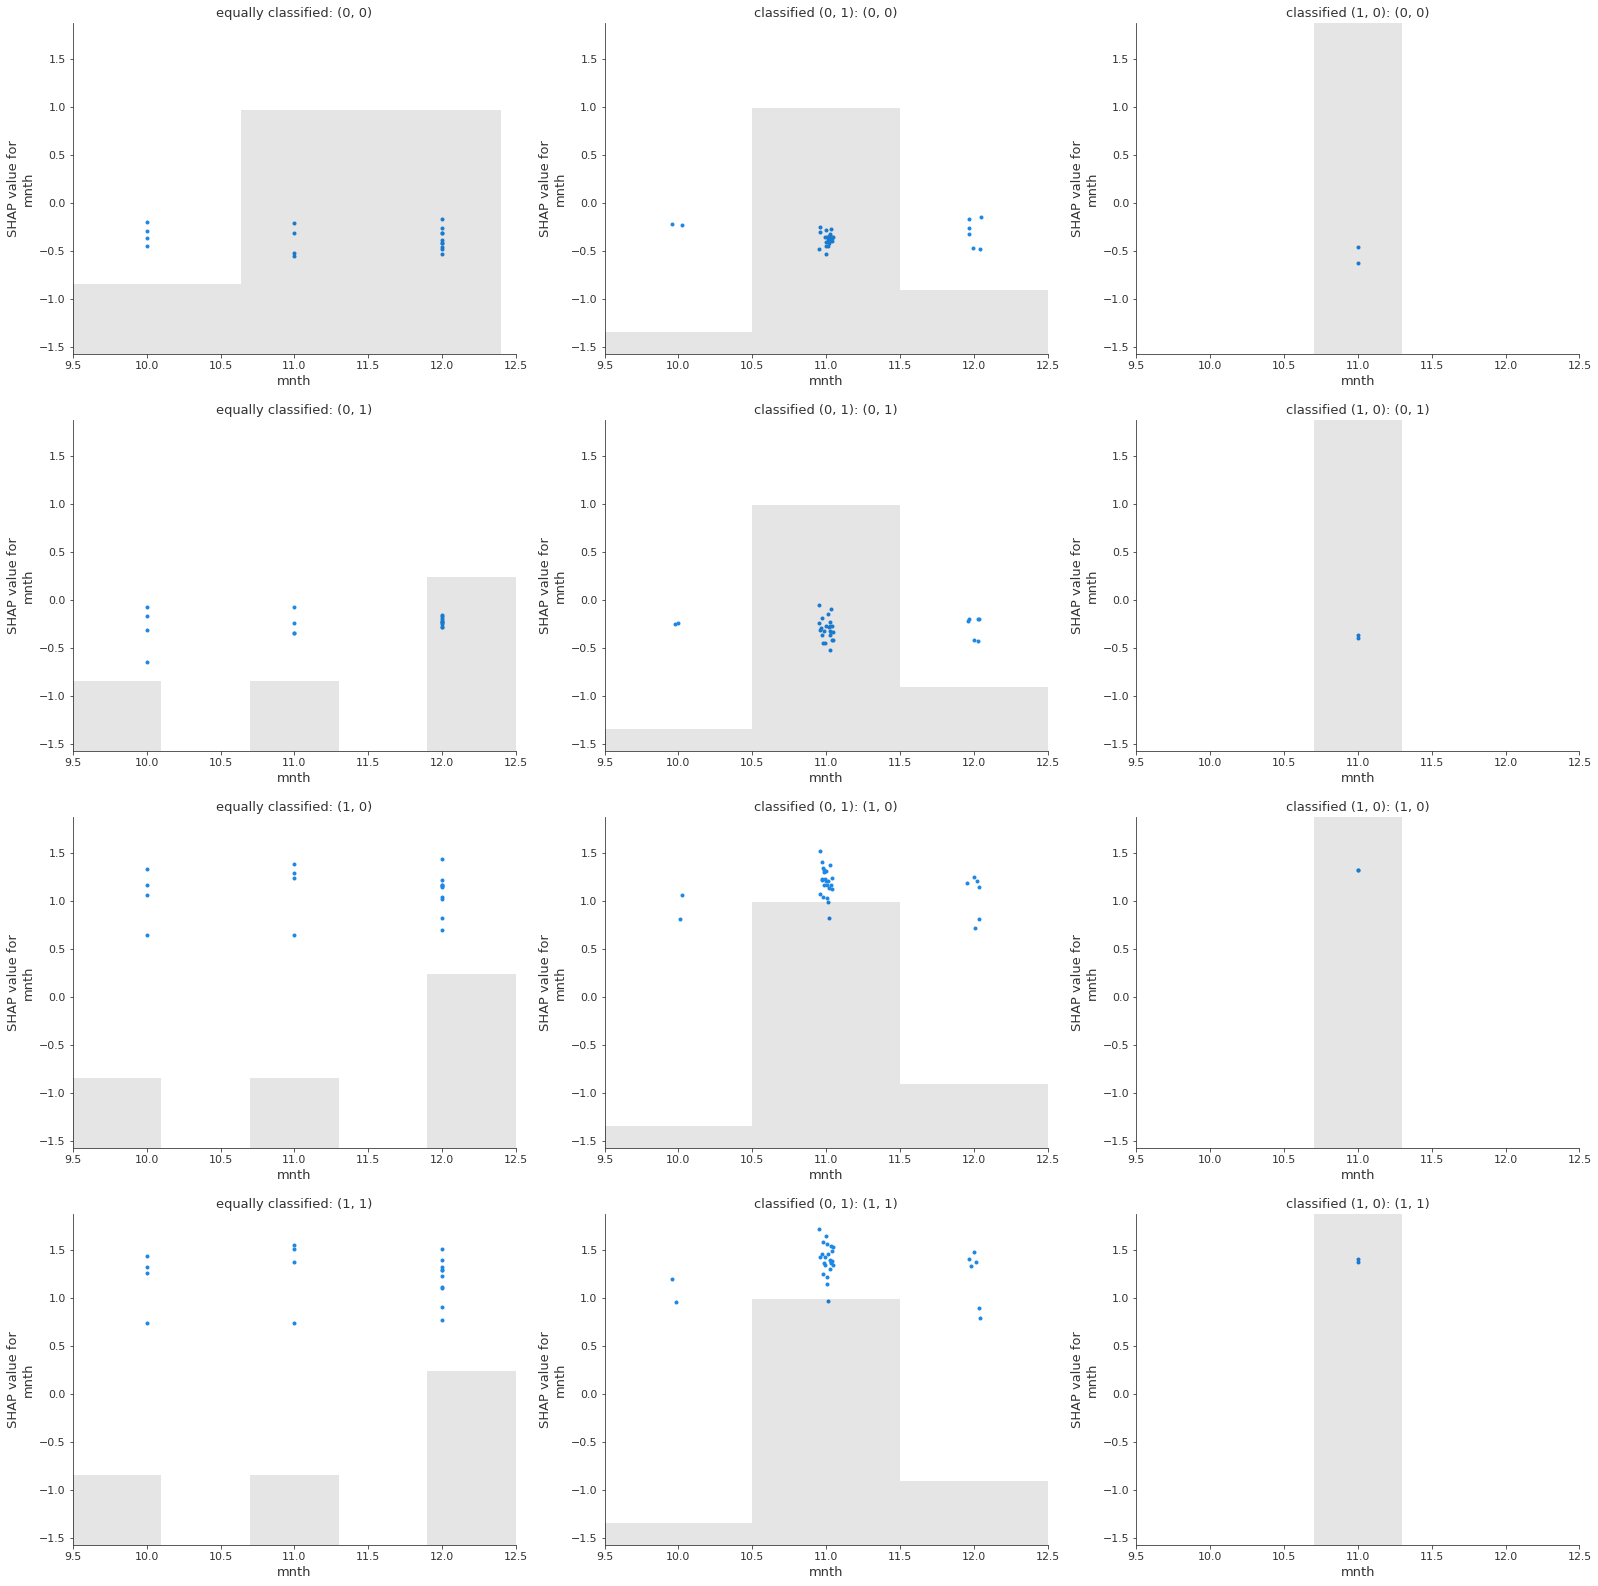

In [66]:
plot_next_feature()

humidity values only cover the range > 0.5. Instances classified differently have a different distribution than those classified equally, so I can say from the local effects plots, that if humidity was higher (around 0.75), the log odds would shift from class $(0,1)$ towards $(0,0)$.

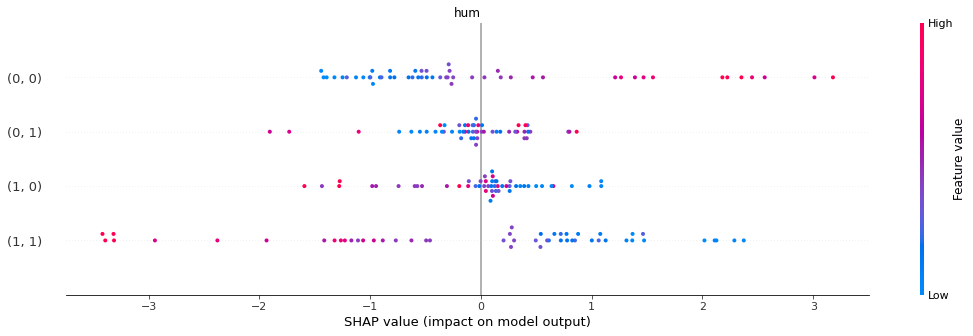

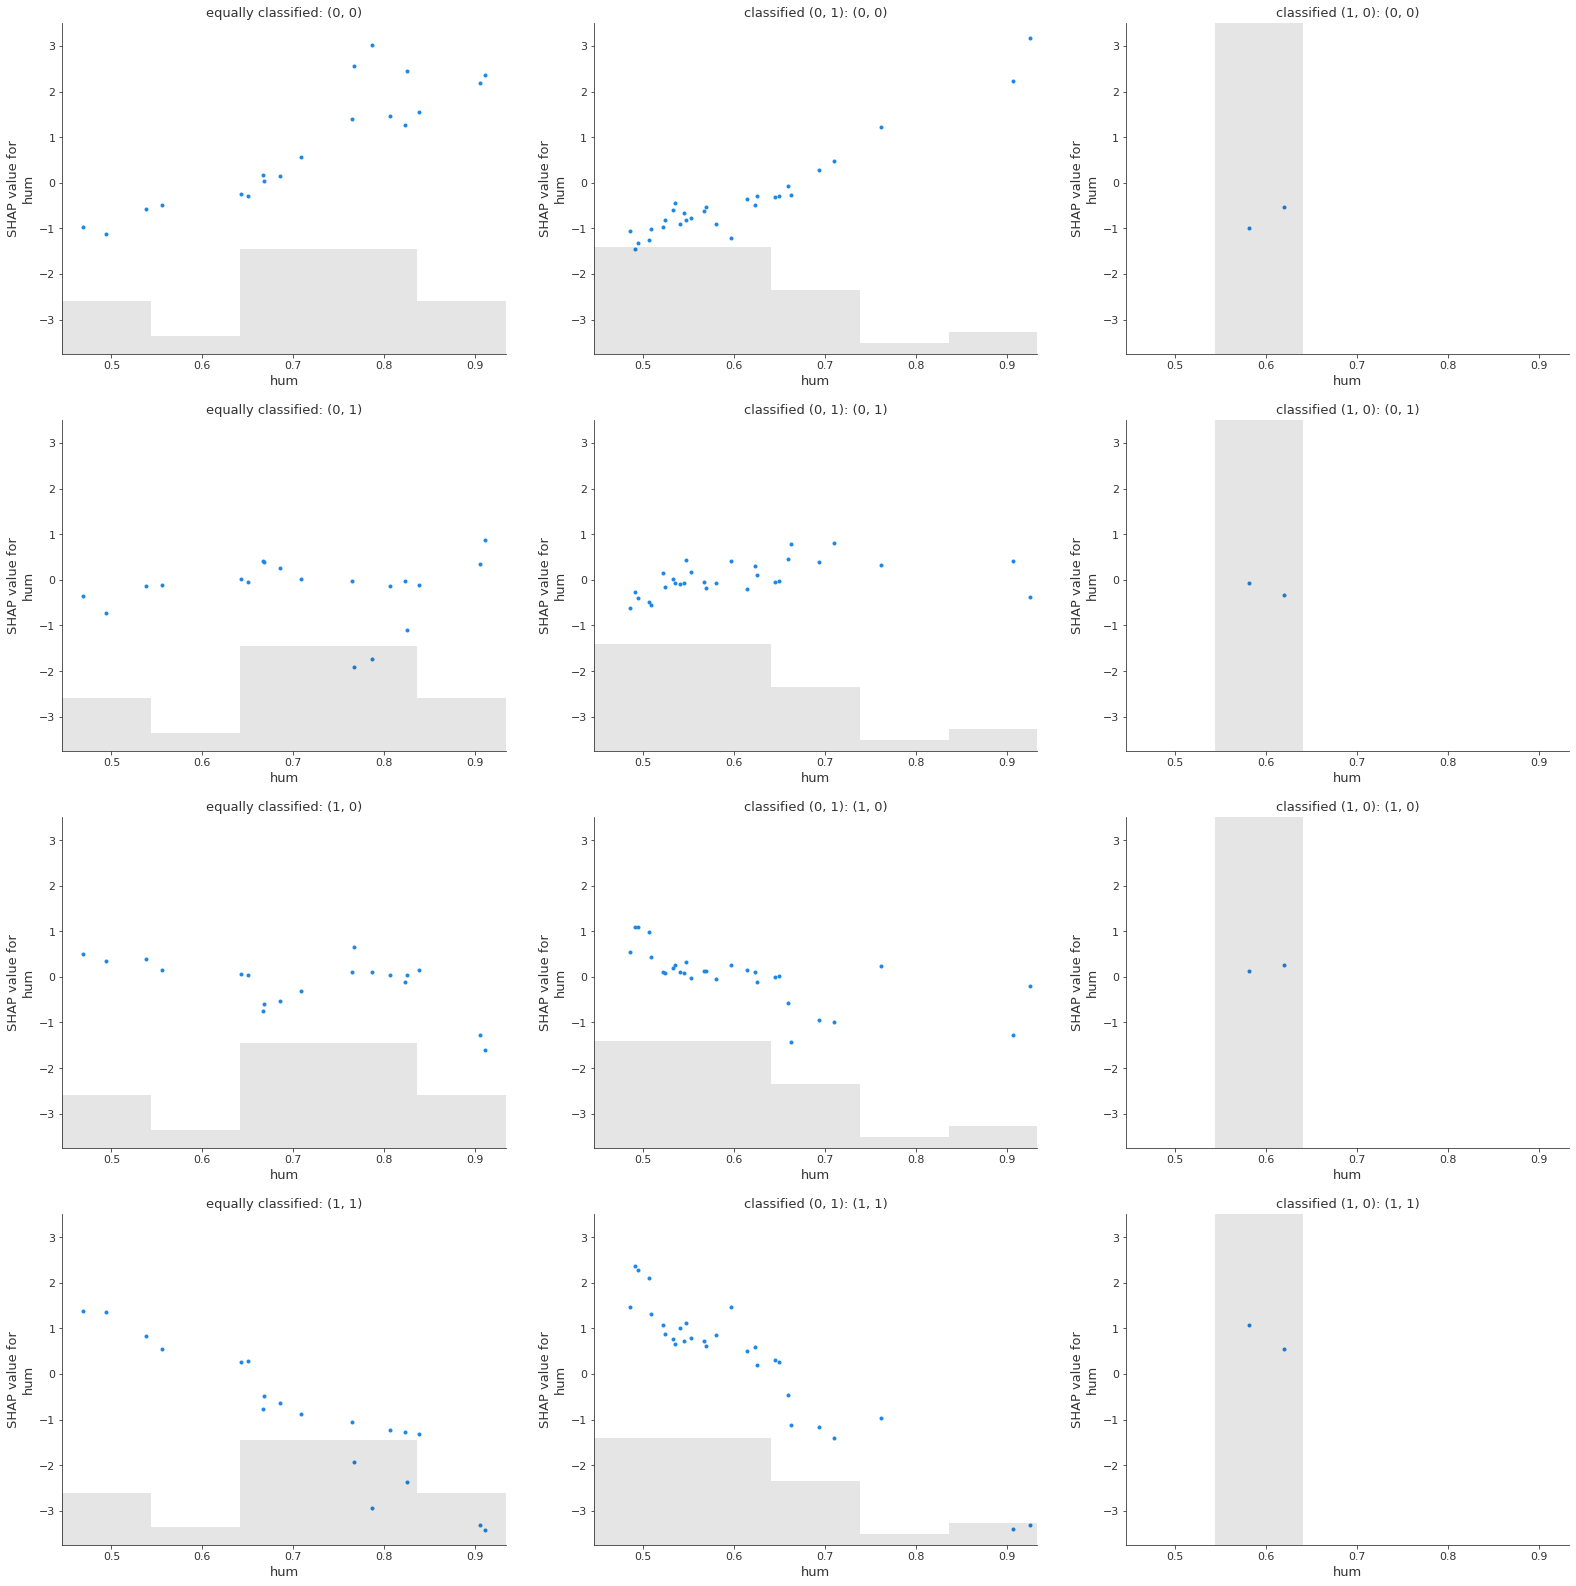

In [67]:
plot_next_feature()

Windspeed values in this cluster do not cover the whole range, only up to 0.3. Instances classified differently have a higher mean of about 0.175, while those classified equally have a mean of about 0.125.

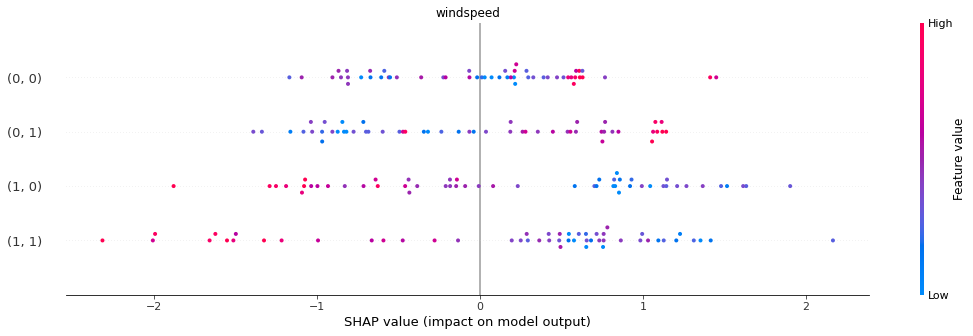

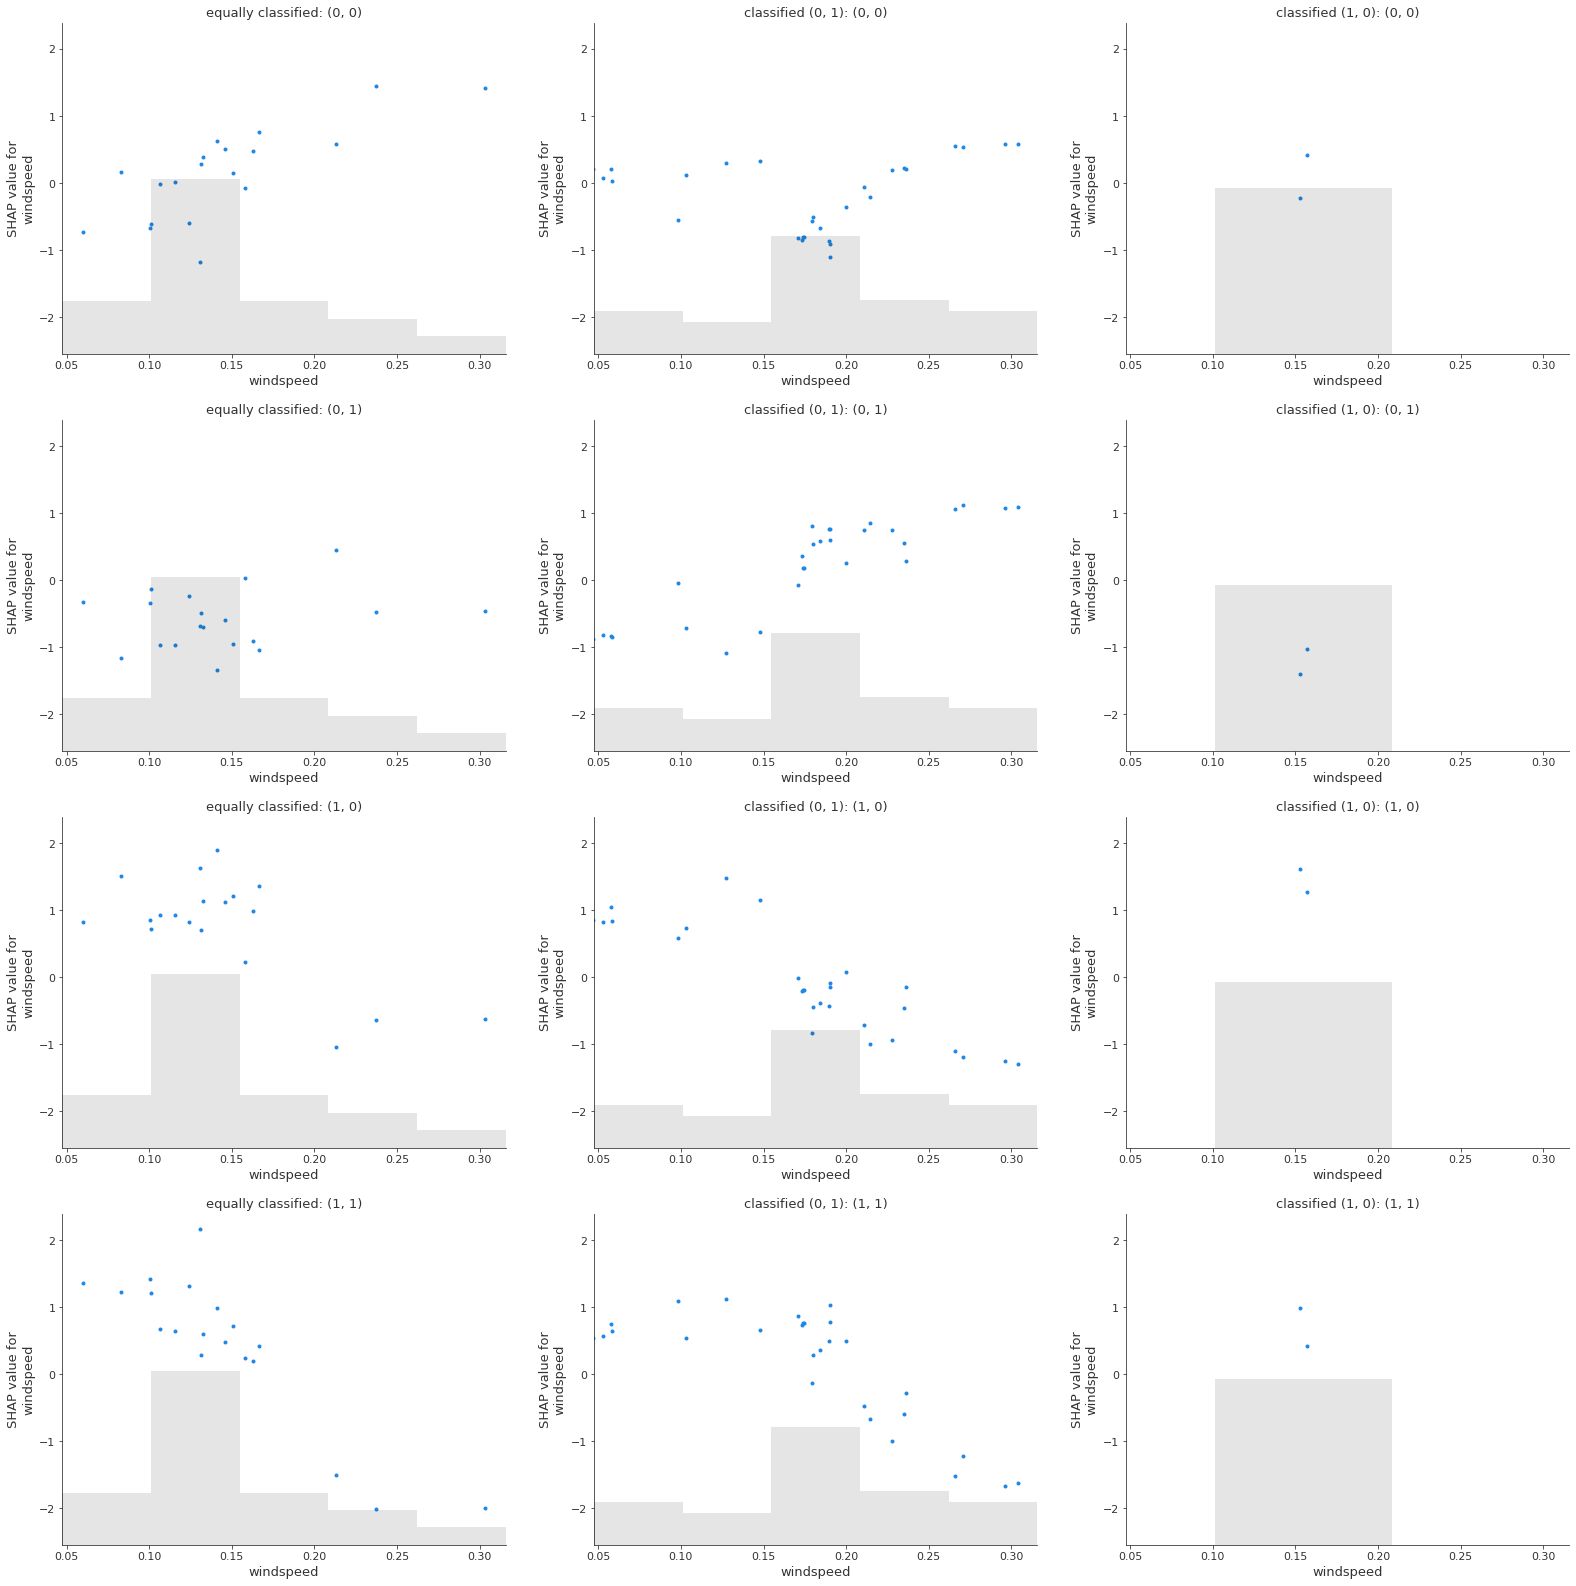

In [72]:
plot_next_feature()

#### Towards $(1,1)$

In [61]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.44
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    18.0      2
(0, 1)     NaN     16

before  after
(0, 1)      31     31

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

before  after
(1, 1)       1      1

In [62]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    18.0      3
(0, 1)     NaN      2
(1, 1)     NaN     13

before  after
(0, 1)    31.0      9
(1, 1)     NaN     22

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

before  after
(1, 1)       1      1

Although all three features are combined, the effect is only strong enough to flip one instance originally classified $(0,1)$ to $(1,1)$.

In [51]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.44
X['windspeed'] = 0.1
X['hum'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    18.0    NaN
(0, 1)     NaN   14.0
(1, 1)     NaN    4.0

before  after
(0, 1)    31.0     30
(1, 1)     NaN      1

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

before  after
(0, 1)     NaN    1.0
(1, 1)     1.0    NaN

#### Towards $(0,0)$

In [63]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      18     18

before  after
(0, 0)     NaN      2
(0, 1)    31.0     29

before  after
(1, 0)       2      2

before  after
(1, 1)       1      1

In [73]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['mnth'] = 1
X['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      18     18

before  after
(0, 0)     NaN     28
(0, 1)    31.0      3

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

before  after
(0, 1)     NaN    1.0
(1, 1)     1.0    NaN

In [69]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['hum'] = 0.75
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    18.0     17
(0, 1)     NaN      1

before  after
(0, 0)     NaN      7
(0, 1)    31.0     24

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

before  after
(0, 1)     NaN    1.0
(1, 1)     1.0    NaN

In [76]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['windspeed'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    18.0      9
(0, 1)     NaN      9

before  after
(0, 0)     NaN      2
(0, 1)    31.0     29

before  after
(0, 1)     NaN    2.0
(1, 0)     2.0    NaN

before  after
(0, 1)     NaN    1.0
(1, 1)     1.0    NaN

In [74]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.2
X['mnth'] = 1
X['season'] = 1
X['hum'] = 0.75
X['windspeed'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      18     18

before  after
(0, 0)     NaN   31.0
(0, 1)    31.0    NaN

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

before  after
(0, 0)     NaN    1.0
(1, 1)     1.0    NaN

### diro2c

#### (0,1)

In [58]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]
diff_class

'(0, 1)'

In [16]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 9min 59s, sys: 46.2 s, total: 10min 45s
Wall time: 3min 35s


In [59]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

diro2c explains that windspeed is the most important feature for the differences. For values below 0.165, there are many instances not classified $(0,1)$.

In the second plot we can see temp and month values. But since they are local to this cluster, they do not cover the possible range with less differences identified in the section where I compared the local SHAP explanations to the global explanations.

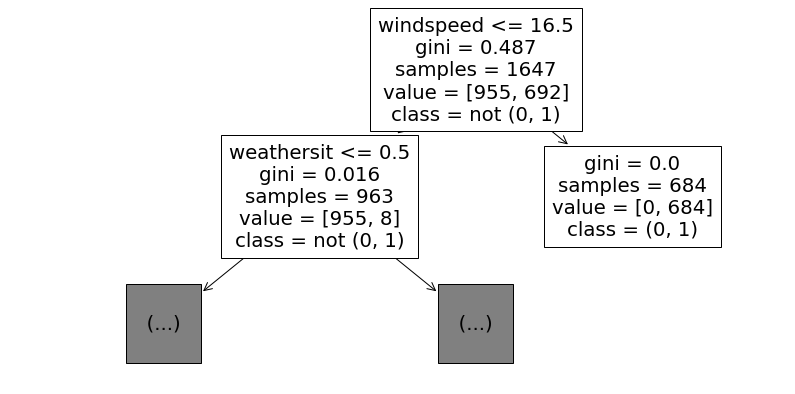

In [18]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=1)

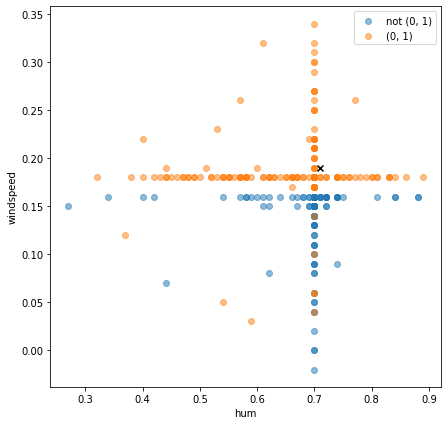

In [19]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'hum', 'windspeed', highlight=x)

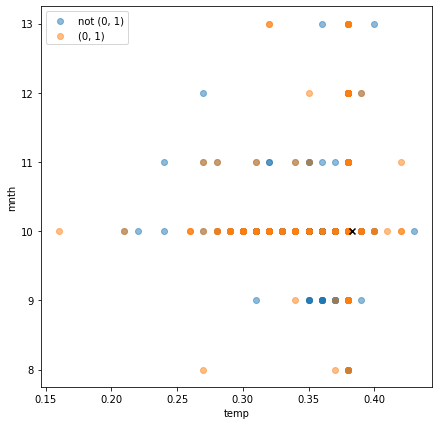

In [61]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'temp', 'mnth', highlight=x)

A low windspeed actually flips many predictions of instances originally classified $(0,1)$, but to all possible alternatives. This just explains, that for in this particular area, the classifiers are very uncertain.

In [75]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['windspeed'] = 0.15
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    18.0     17
(1, 0)     NaN      1

before  after
(0, 0)     NaN     16
(0, 1)    31.0      7
(1, 0)     NaN      3
(1, 1)     NaN      5

before  after
(1, 0)       2      2

before  after
(1, 1)       1      1

#### (1,0)

In [62]:
diff_class = diff_classes[1]
start_idx = np.where(pred_classes == diff_class)[0][0]
diff_class

'(1, 0)'

In [53]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 10min 39s, sys: 33.7 s, total: 11min 13s
Wall time: 3min 14s


In [63]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

Diro2c discovered that for weathersit = 1 there are fewer instances classified $(1,0)$. We know that there is a shift towards $(1,1)$ for this value. But when checking manually, it turns out that weathersit alone just flips the prediction of one instance originally classified $(1,0)$ to $(0,1)$. In this case the provided explanations are not helpful.

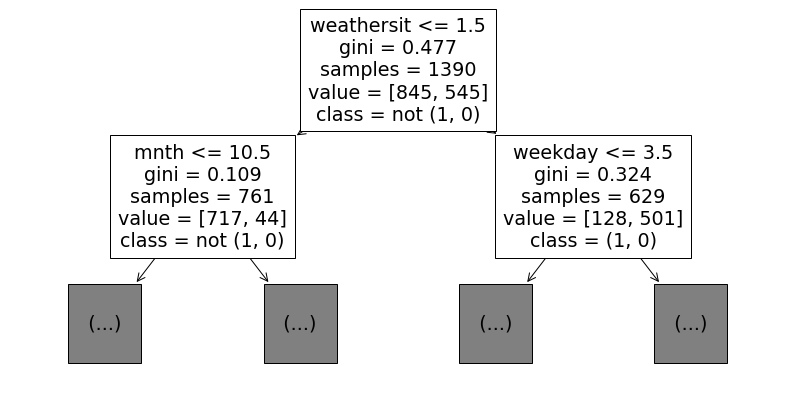

In [64]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=1)

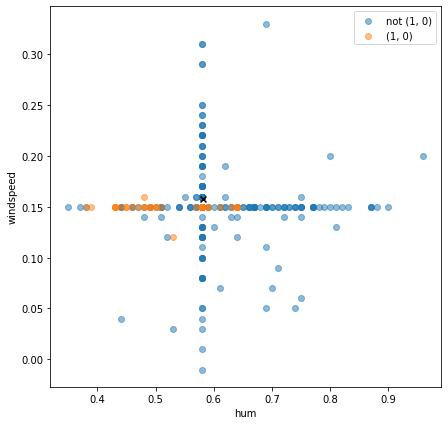

In [65]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'hum', 'windspeed', highlight=x)

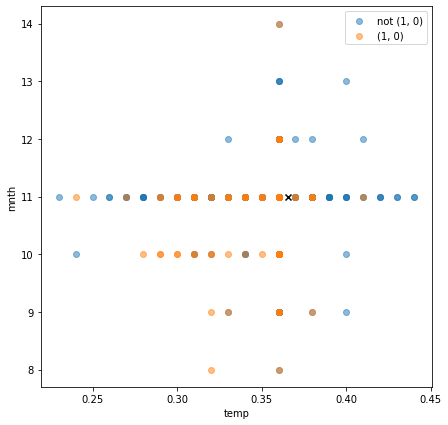

In [66]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'temp', 'mnth', highlight=x)

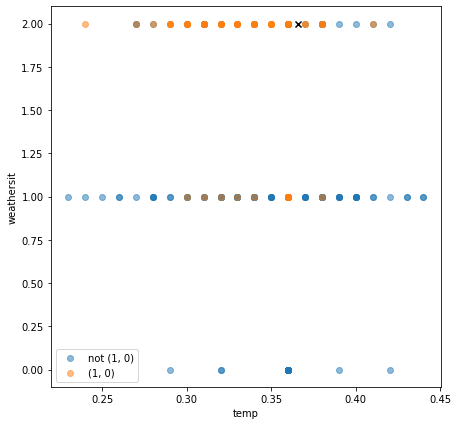

In [67]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'temp', 'weathersit', highlight=x)

In [72]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['weathersit'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    18.0     10
(0, 1)     NaN      8

before  after
(0, 1)      31     31

before  after
(0, 1)     NaN      1
(1, 0)     2.0      1

before  after
(1, 1)       1      1

## 2. Cluster

Difference to global level:
- season more important than temp
- season and temp more important in absolute numbers
- season is only 1-2
- month is only 1-4 and 12
- temp and atemp are < 0.5

Cluster effects based on global explanations:
- if temp was higher (> 0.5 but < 0.75), its influence towards $(1,1)$ would be maximized

Cluster effects based on local explanations:
- if season was 1, its influence towards $(0,0)$ would increase
- if temp was lower (0.3), its influence towards $(0,0)$ would increase

In [80]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c2      75       4       0       0

In [152]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

season       mnth    holiday    weekday  workingday  weathersit  \
count  79.000000  79.000000  79.000000  79.000000   79.000000   79.000000   
mean    1.063291   3.227848   0.050633   2.949367    0.632911    1.481013   
std     0.245042   3.637234   0.220648   2.099443    0.485091    0.551473   
min     1.000000   1.000000   0.000000   0.000000    0.000000    1.000000   
25%     1.000000   1.000000   0.000000   1.000000    0.000000    1.000000   
50%     1.000000   2.000000   0.000000   3.000000    1.000000    1.000000   
75%     1.000000   3.000000   0.000000   5.000000    1.000000    2.000000   
max     2.000000  12.000000   1.000000   6.000000    1.000000    3.000000   

            temp      atemp        hum  windspeed  
count  79.000000  79.000000  79.000000  79.000000  
mean    0.290782   0.289028   0.581300   0.211886  
std     0.072526   0.074225   0.147945   0.086145  
min     0.107500   0.101658   0.290000   0.073396  
25%     0.253333   0.245269   0.467283   0.154323  
50%     0.282609   0.278412   0.542083   0.191542  
75%     0.343840   0.350368   0.708877   0.238809  
max     0.463333   0.457038   0.911250   0.421642

In [181]:
df['mnth'].value_counts()

1.0     29
2.0     26
12.0    11
3.0     10
4.0      3
Name: mnth, dtype: int64

### SHAP-based Difference Classifier Explanations

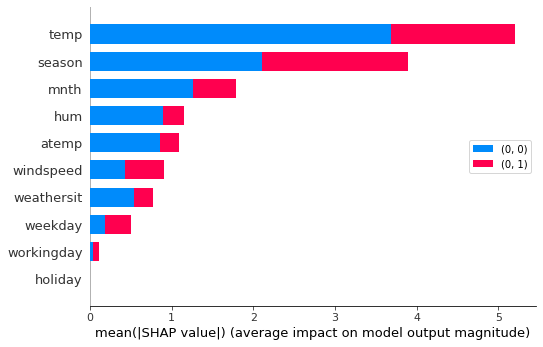

In [273]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

3

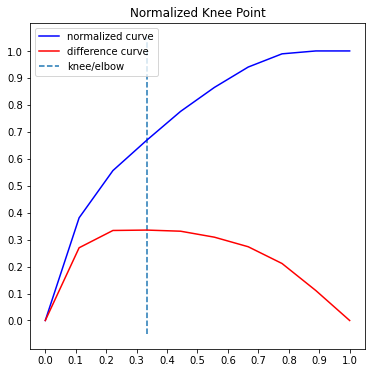

In [274]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

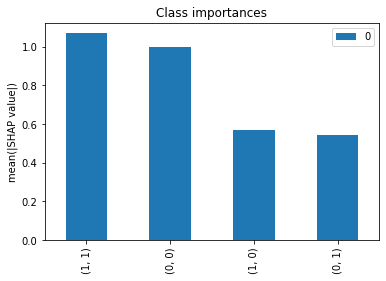

In [275]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [158]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

For season, we see only spring and winter represented in the cluster. If the value of the three instances of summer was changed to winter, we could expect the odds of the difference class to decrease and increase for $(0,0)$.

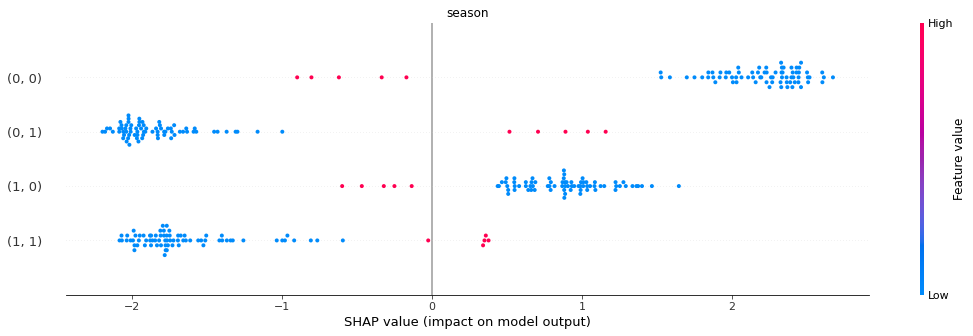

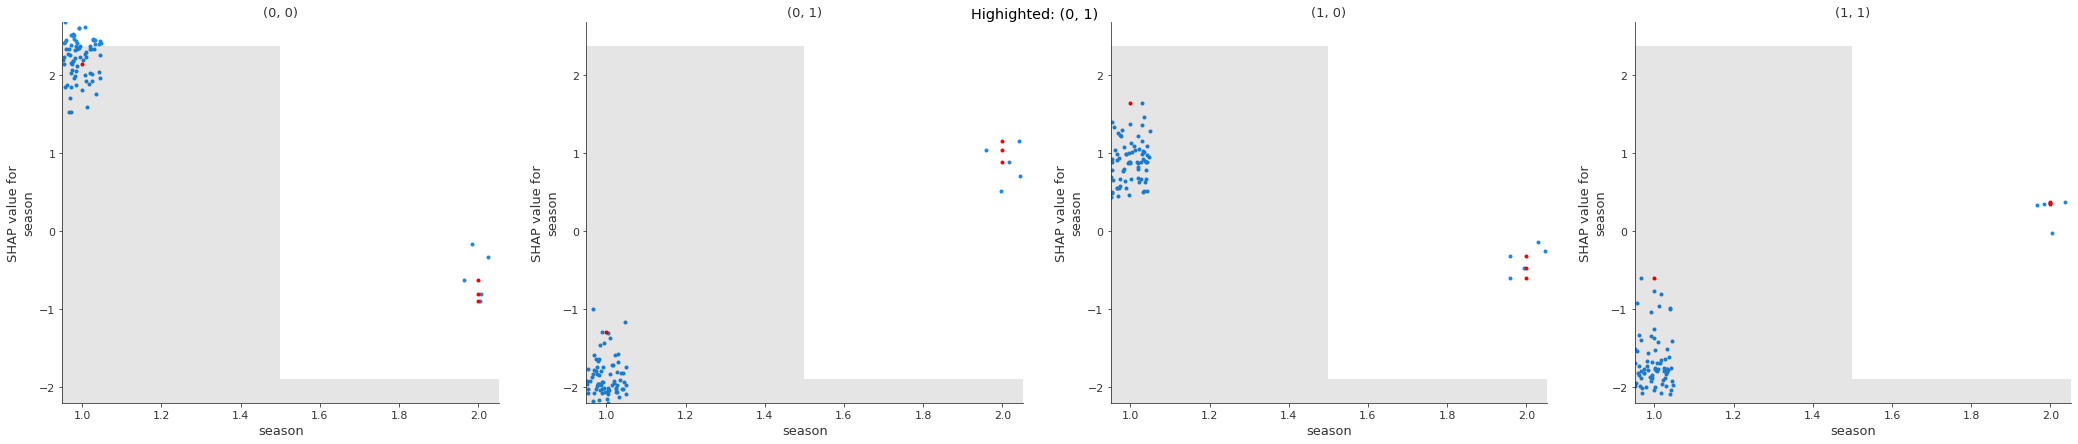

In [159]:
plot_next_feature()

The temperature values present in this cluster are from the lower half of possible values. If they were decreased, we would expect decreased odds for the difference class and increased odds for $(0,0)$. According to the global explanations, we would expect that if values were increased, that at around 0.5 the odds would drop for the difference classes and increase for $(1,1)$.

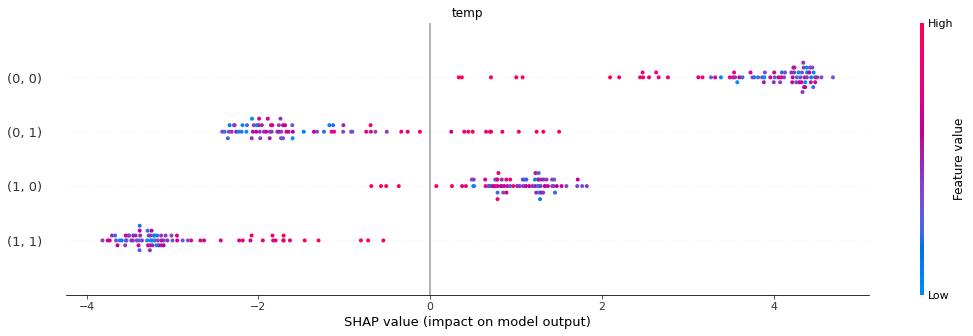

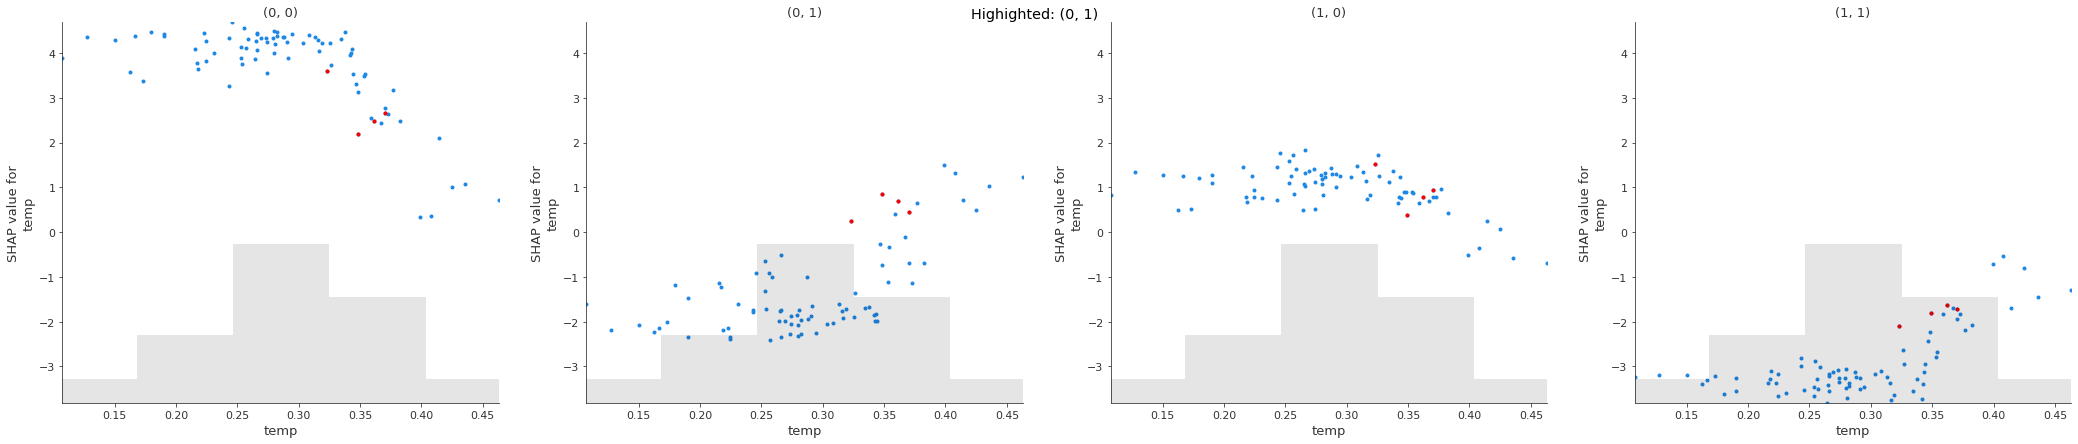

In [161]:
plot_next_feature()

#### Towards $(0,0)$

In [81]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN      3
(0, 1)     4.0      1

before  after
(0, 0)      75     75

In [82]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN      1
(0, 1)     4.0      3

before  after
(0, 0)      75     75

In [83]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['season'] = 1
X['temp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN    4.0
(0, 1)     4.0    NaN

before  after
(0, 0)      75     75

#### Towards $(1,1)$

In [88]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)       4      4

before  after
(0, 0)    75.0      8
(0, 1)     NaN     59
(1, 1)     NaN      8

### diro2c

In [192]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [193]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 10min 28s, sys: 47.9 s, total: 11min 16s
Wall time: 4min 14s


In [194]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In contrast to the SHAP-based explanations, diro2c ranks mnth as the most important feature. But it is closely related to season. They conclude on the second most important feature.

Clearly it found many instances $temp > 0.3$ that are classified $(0,1)$.

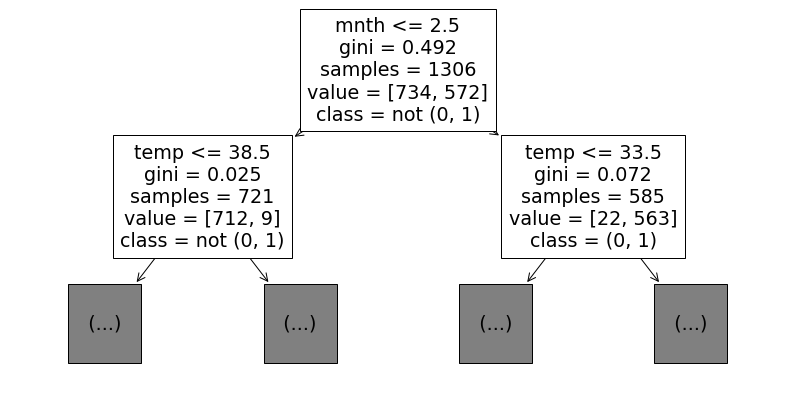

In [196]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=1)

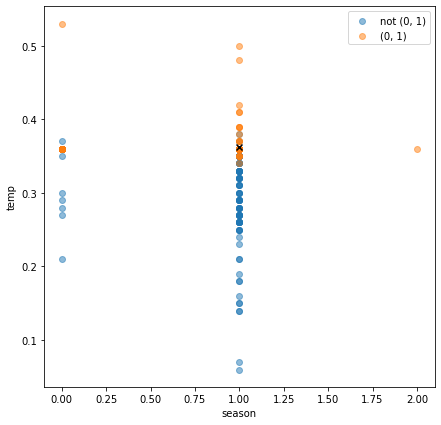

In [197]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, feature_order[0], feature_order[1], highlight=x)

## 3. Cluster

Difference to global level: value distributions of relevant features are similar to global level

Cluster effects based on global explanations:

Cluster effects based on local explanations:
- temp: there are two subclusters for this feature, separated at ~0.7. if it was lower (0.5) for the higher subcluster, its effect would shift towards $(1,1)$
- atemp: if it was higher (0.6), its effect would shift towards $(1,1)$
- windspeed: if it was lower (0.15), its effect would shift towards $(1,1)$
- additionally, diro2c found out that if temp values were lower (<0.375), its effect would shift towards $(0,0)$.

In [92]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c3       0      95       0      64

In [298]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

season        mnth     holiday    weekday  workingday  weathersit  \
count  159.000000  159.000000  159.000000  159.00000  159.000000  159.000000   
mean     2.547170    6.213836    0.012579    3.08805    0.679245    1.150943   
std      0.869294    2.432285    0.111799    2.02010    0.468241    0.359125   
min      1.000000    1.000000    0.000000    0.00000    0.000000    1.000000   
25%      2.000000    4.000000    0.000000    1.00000    0.000000    1.000000   
50%      3.000000    6.000000    0.000000    3.00000    1.000000    1.000000   
75%      3.000000    8.000000    0.000000    5.00000    1.000000    1.000000   
max      4.000000   12.000000    1.000000    6.00000    1.000000    2.000000   

             temp       atemp         hum   windspeed  
count  159.000000  159.000000  159.000000  159.000000  
mean     0.602289    0.569616    0.562375    0.200553  
std      0.126376    0.109583    0.109252    0.075382  
min      0.390000    0.242400    0.254167    0.065929  
25%      0.494584    0.482623    0.492083    0.145214  
50%      0.583333    0.565654    0.567500    0.187808  
75%      0.720833    0.654686    0.620208    0.245964  
max      0.861667    0.804913    0.831250    0.441563

### SHAP-based Difference Classifier Explanations

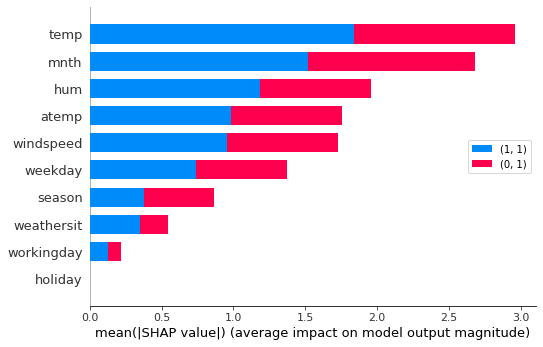

In [299]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

5

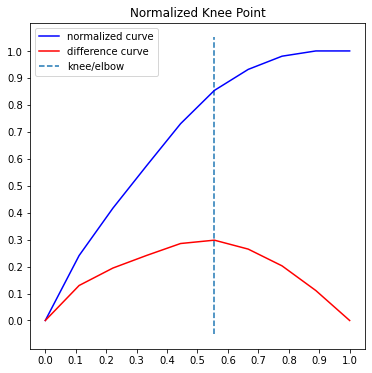

In [300]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

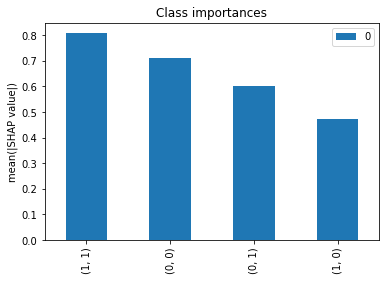

In [301]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [308]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        highlight = pred_classes == diff_class
        plot_feature_effects_comparison(**{'Other': shap_values[~highlight][:, [feature_idx]],
                                           'Different': shap_values[highlight][:, [feature_idx]]})
it = iter(feature_order)

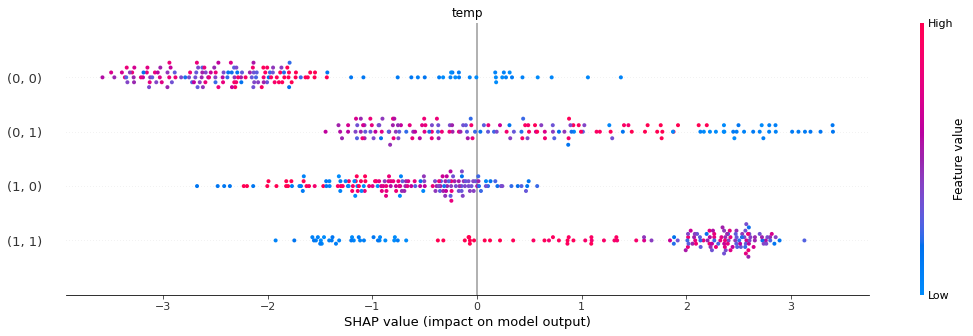

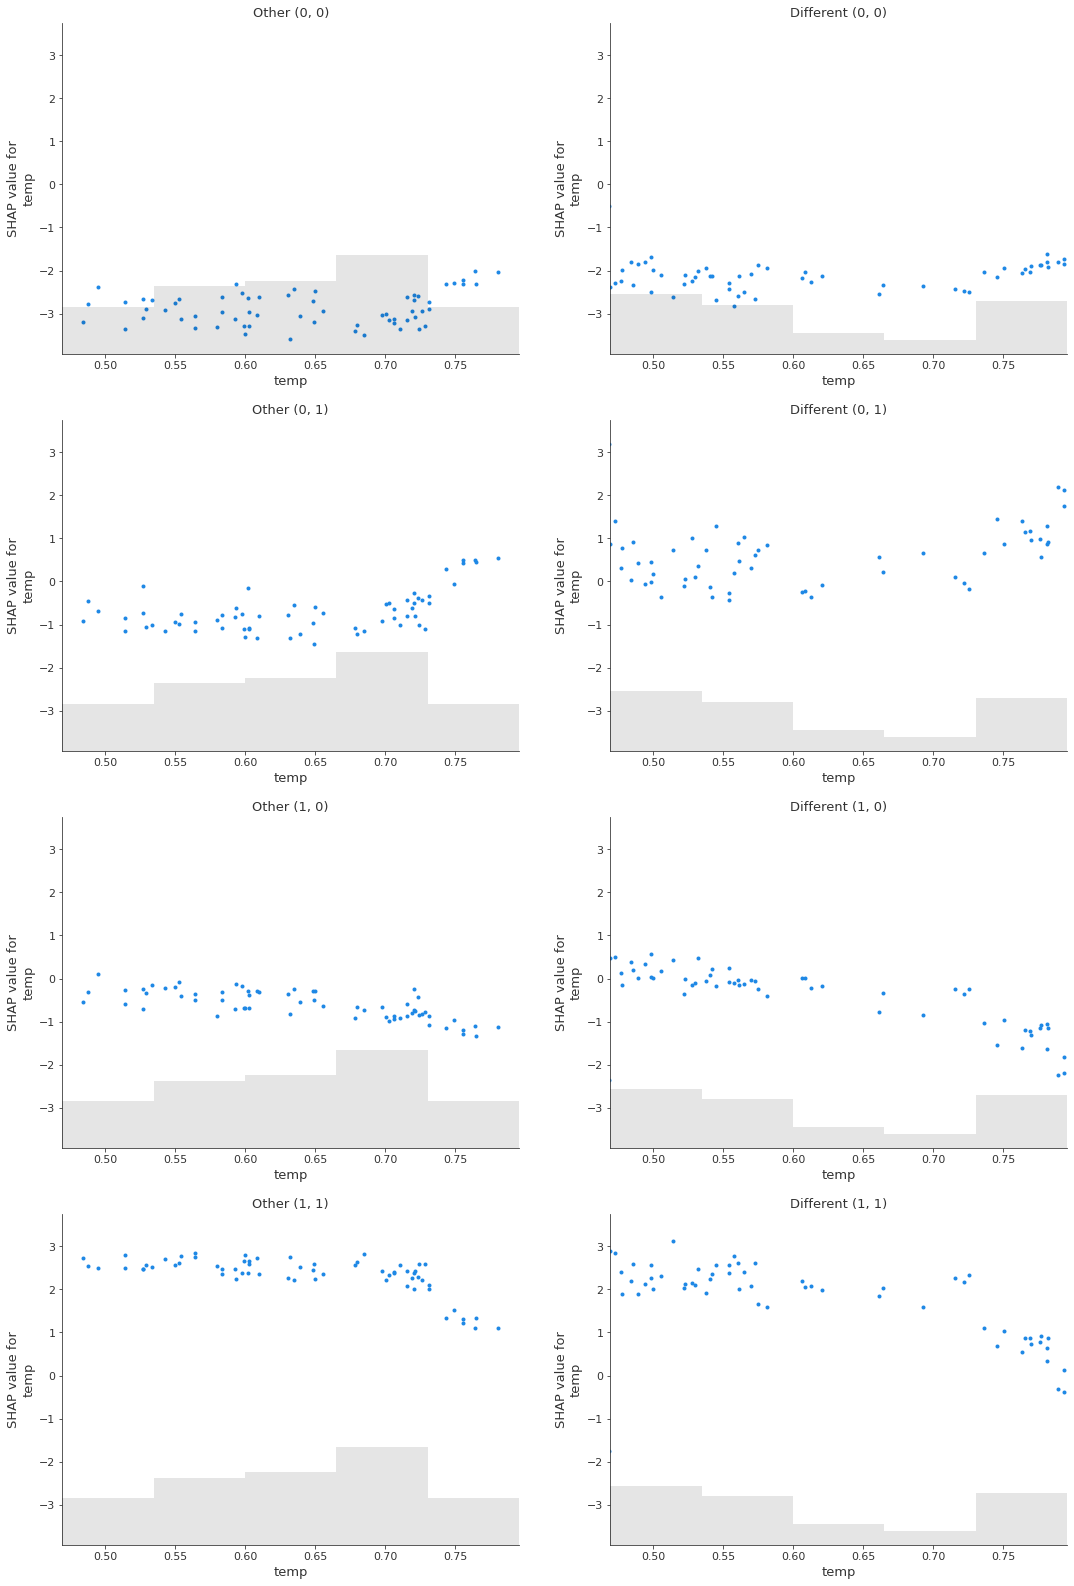

In [309]:
plot_next_feature()

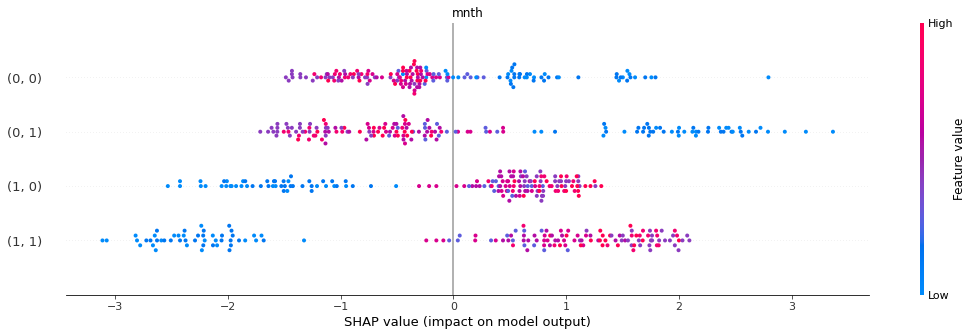

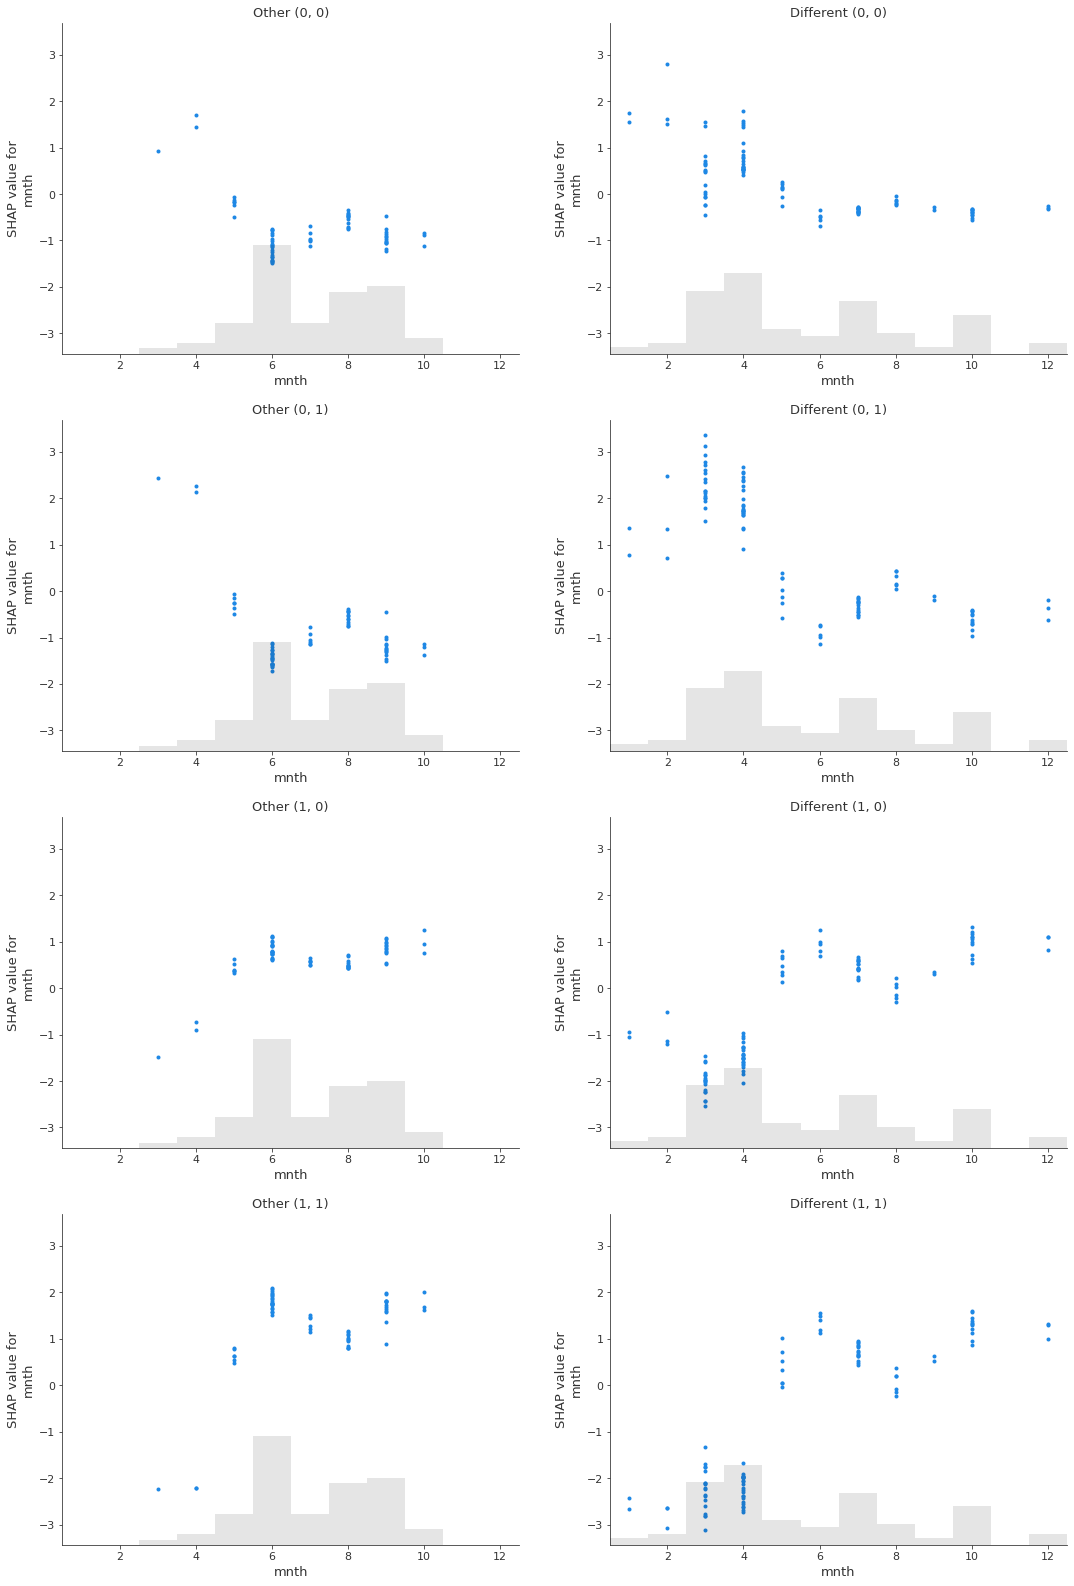

In [310]:
plot_next_feature()

Decrease values => $(1,1)$

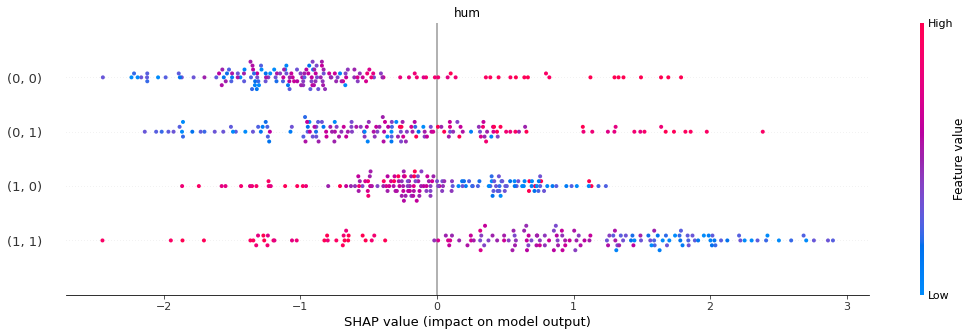

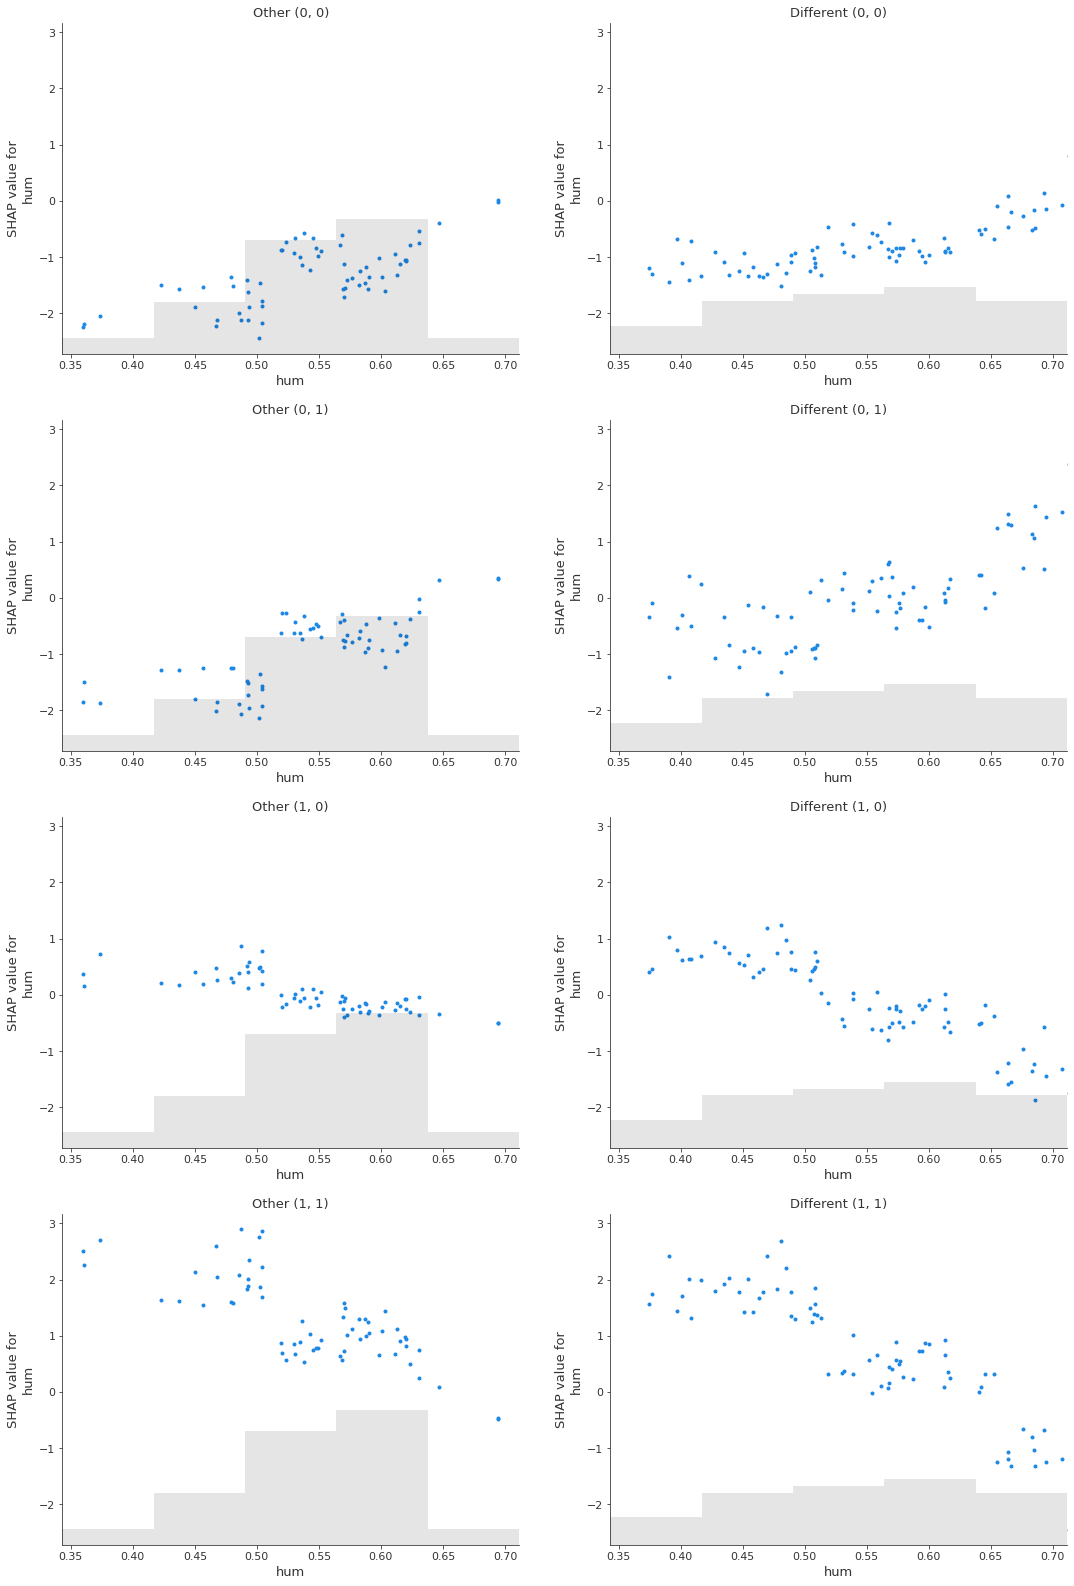

In [311]:
plot_next_feature()

Lower half different from upper half, distribution lacks lower values that are classified equally. increase lower half values => $(1,1)$, decrease upper half values => $(1,1)$

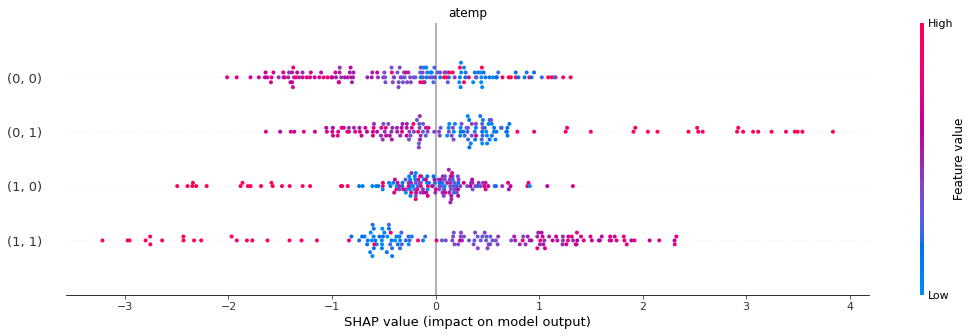

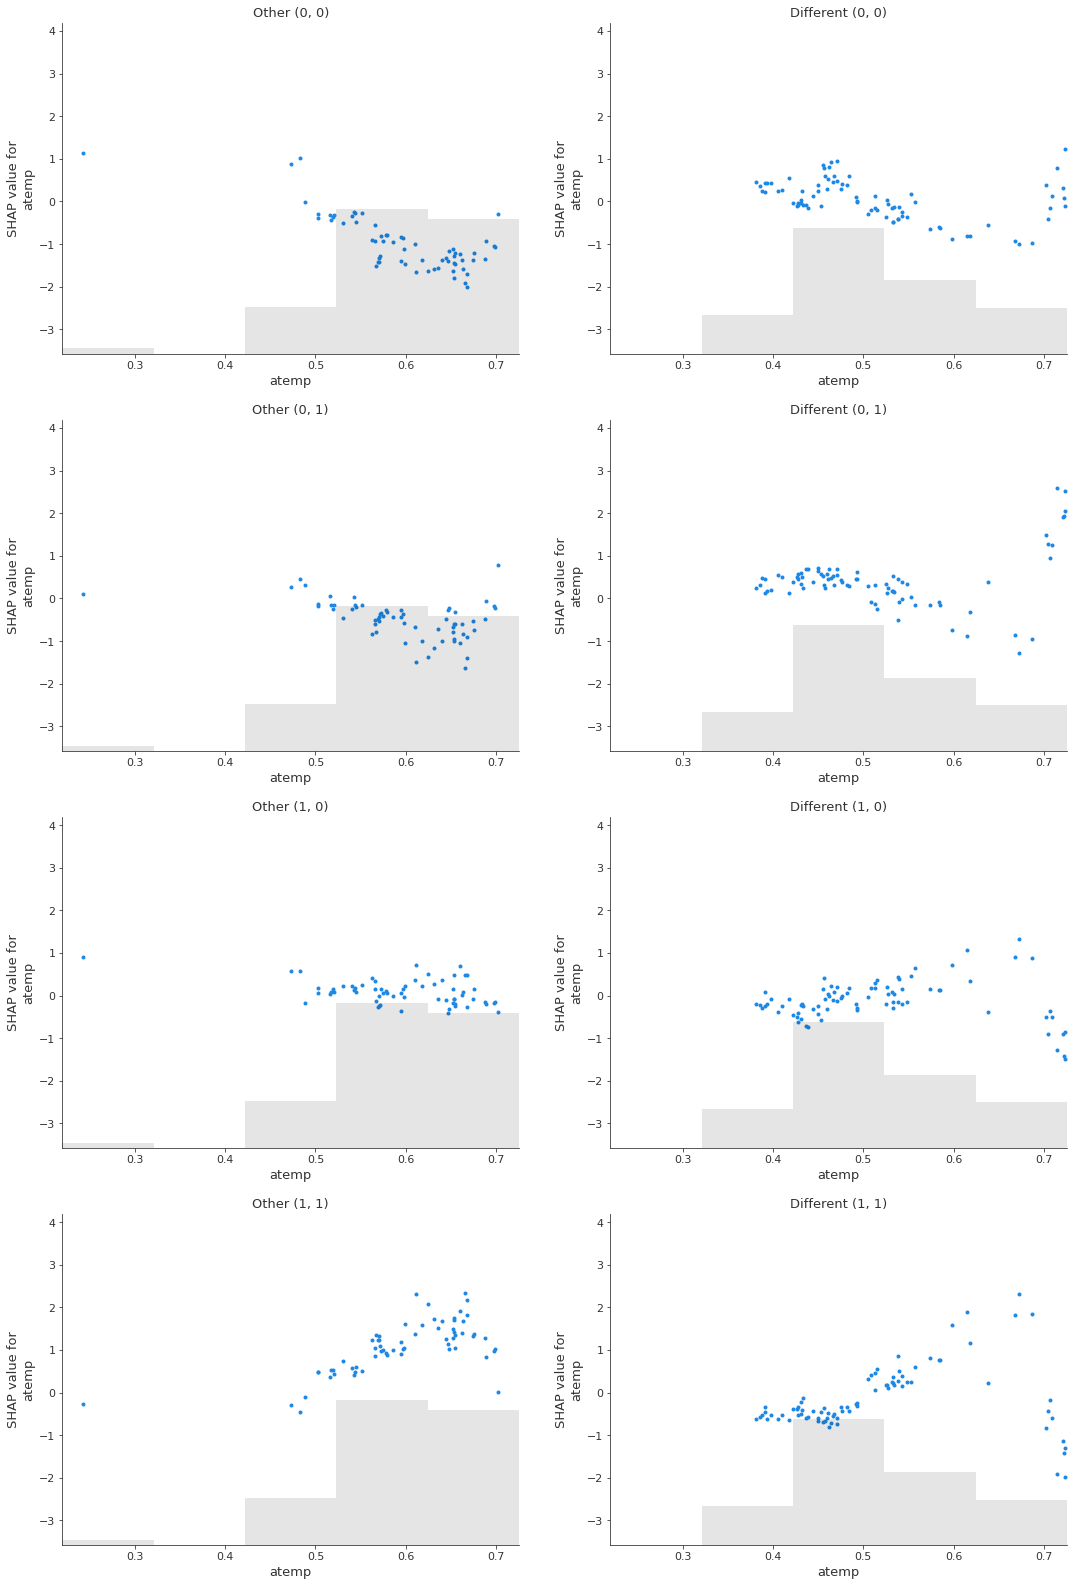

In [312]:
plot_next_feature()

similar to global distribution and effects

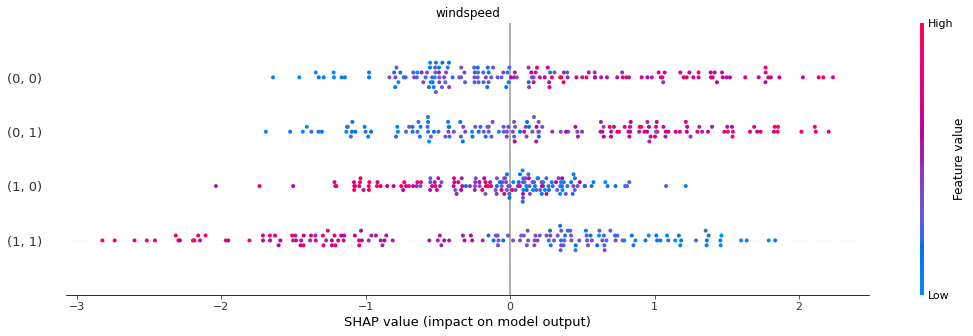

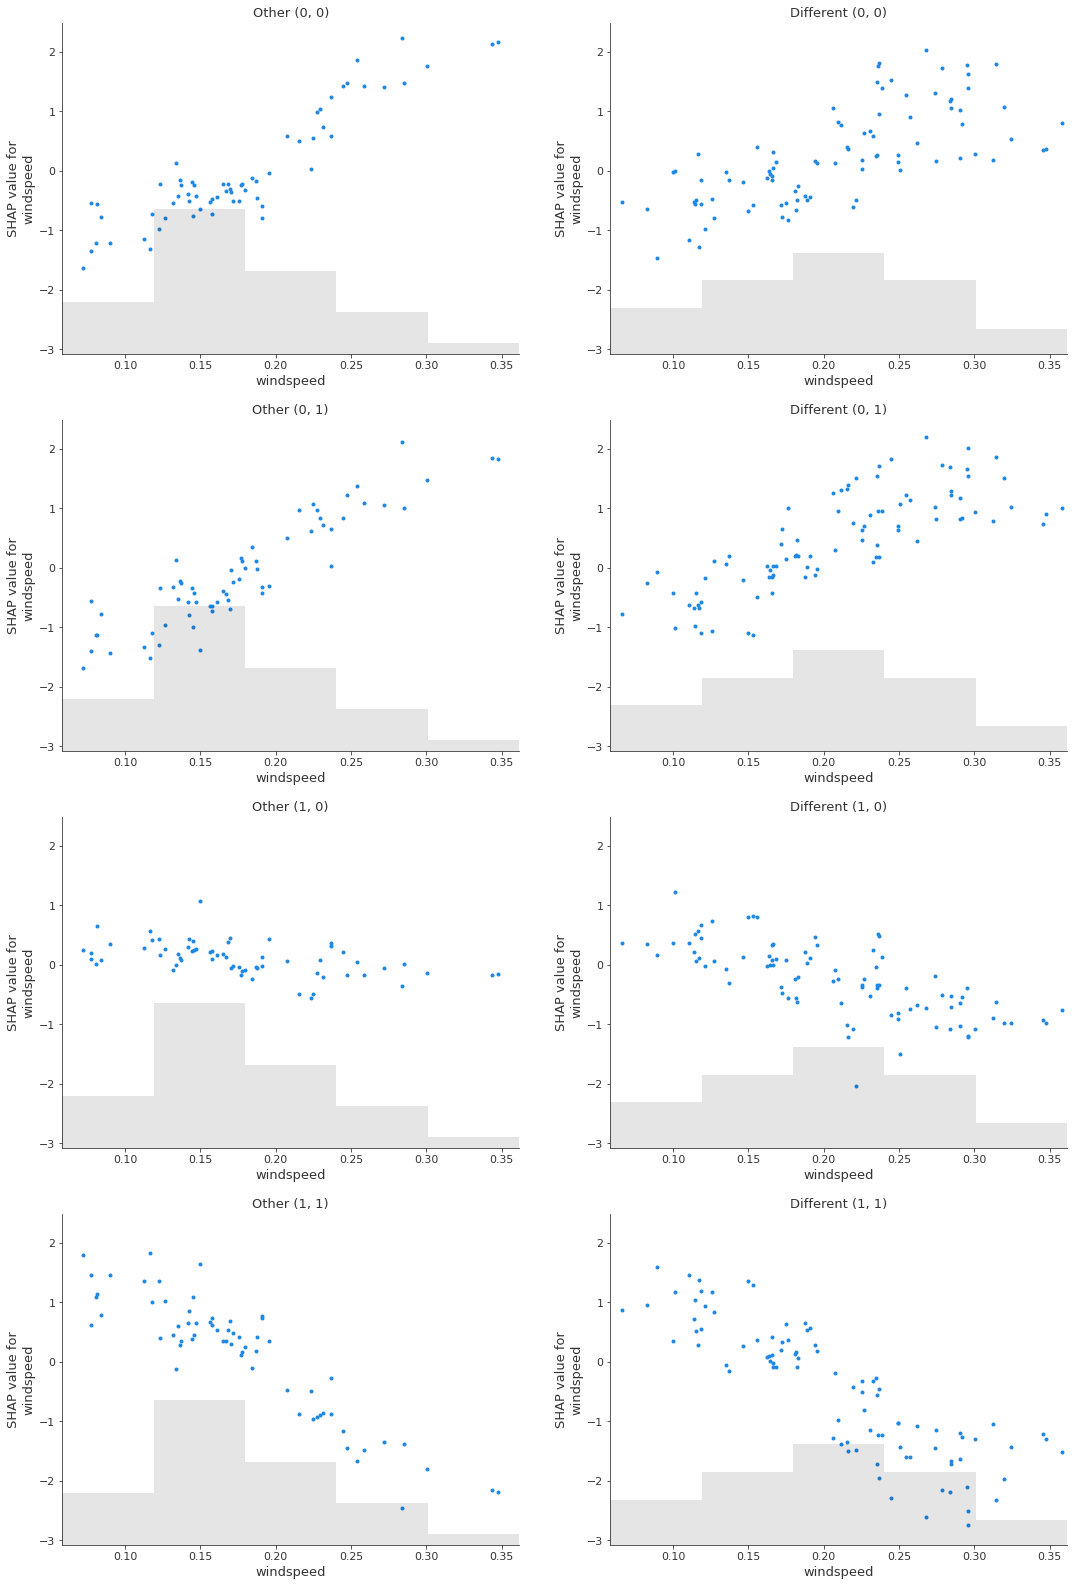

In [319]:
plot_next_feature()

#### Towards $(1,1)$

In [93]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X.loc[X['temp'] > 0.7, 'temp'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)    95.0     84
(1, 1)     NaN     11

before  after
(1, 1)      64     64

In [94]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['atemp'] = 0.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)    95.0     63
(1, 1)     NaN     32

before  after
(1, 1)      64     64

In [95]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['windspeed'] = 0.15
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN      3
(0, 1)    95.0     67
(1, 1)     NaN     25

before  after
(0, 1)     NaN      1
(1, 1)    64.0     63

In [96]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X.loc[X['temp'] > 0.7, 'temp'] = 0.5
X['atemp'] = 0.6
X['windspeed'] = 0.15
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)    95.0     29
(1, 1)     NaN     66

before  after
(1, 1)      64     64

### diro2c

In [321]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [322]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 10min 31s, sys: 42.4 s, total: 11min 13s
Wall time: 3min 37s


In [323]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

diro2c concludes with the SHAP-based approach, that temp is of most importance for the differences. But it ranks mnth and season higher, the plot too suggests that they play a bigger role.

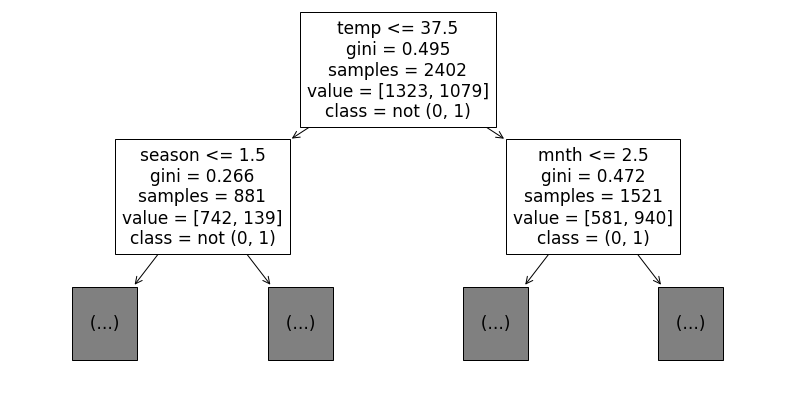

In [324]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=1)

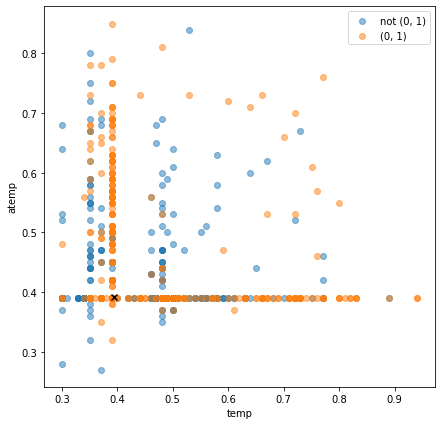

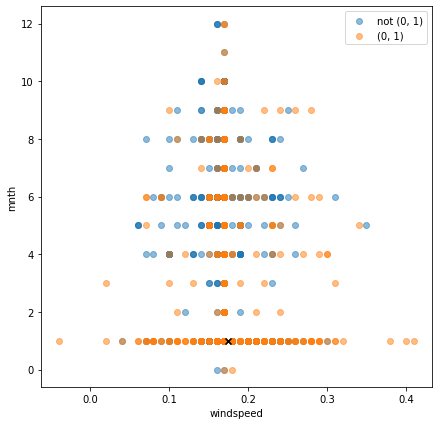

In [328]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'temp', 'atemp', highlight=x)
plot_diro2c_2d(explanation, 'windspeed', 'mnth', highlight=x)

We can see that it indeed has an effect towards $(0,0)$.

In [97]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN     26
(0, 1)    95.0     69

before  after
(0, 1)     NaN     44
(1, 1)    64.0     20

## 4. Cluster

Difference to global level:
- hum most important, having only high values $>0.75$
- windspeed has quite high importance, only medium values present (0.2 - 0.35)
- months 3-10 and seasons 2-4 are present
- weathersit 2 and 3 are present

Cluster effects based on global explanations:
- if hum was low (0.4), its effect would shift towards $(1,1)$
- if windspeed was low (0.1), its effect would shift towards $(1,1)$
- if mnth and season were low (1 and 1), their effect would shift towards $(0,0)$
- if weathersit was low (1), its effect would shift towards $(1,1)$

Cluster effects based on local explanations:
- if windspeed was higher (0.35), its effect would shift towards $(0,0)$
- if temp was lower (0.4), its effect would shift towards $(0,0)$

In [329]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c4       8       5       0       0

In [330]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

season       mnth  holiday    weekday  workingday  weathersit  \
count  13.000000  13.000000     13.0  13.000000   13.000000   13.000000   
mean    2.538462   6.307692      0.0   2.692308    0.538462    2.230769   
std     0.660225   2.287087      0.0   2.496151    0.518875    0.438529   
min     2.000000   3.000000      0.0   0.000000    0.000000    2.000000   
25%     2.000000   5.000000      0.0   1.000000    0.000000    2.000000   
50%     2.000000   6.000000      0.0   2.000000    1.000000    2.000000   
75%     3.000000   8.000000      0.0   5.000000    1.000000    2.000000   
max     4.000000  10.000000      0.0   6.000000    1.000000    3.000000   

            temp      atemp        hum  windspeed  
count  13.000000  13.000000  13.000000  13.000000  
mean    0.573333   0.539204   0.838333   0.254163  
std     0.096327   0.075876   0.040107   0.060315  
min     0.396667   0.389504   0.755417   0.192783  
25%     0.502500   0.486733   0.811250   0.213300  
50%     0.598333   0.565067   0.844167   0.228858  
75%     0.653333   0.597875   0.872500   0.281104  
max     0.665833   0.613025   0.885417   0.358200

In [334]:
df['mnth'].value_counts()

3.0     2
7.0     2
6.0     2
9.0     2
5.0     2
4.0     1
8.0     1
10.0    1
Name: mnth, dtype: int64

### SHAP-based Difference Classifier Explanations

humidity now on top, weekday higher too, temp and atemp lower, 

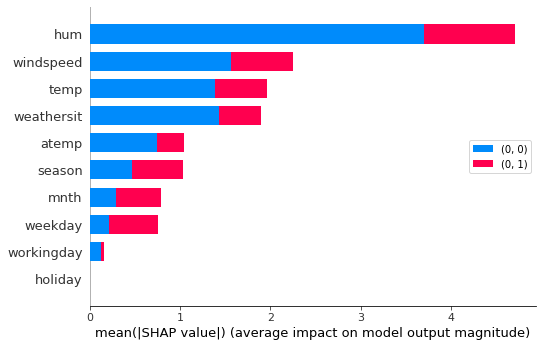

In [331]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

3

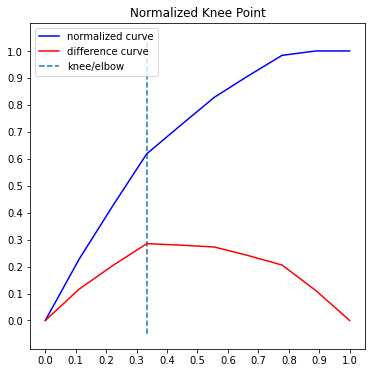

In [332]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

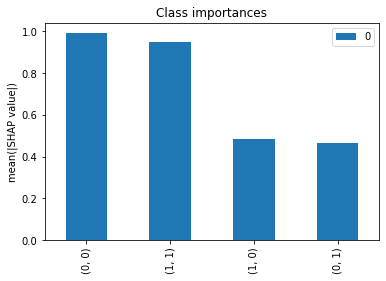

In [333]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [353]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

only high humidity values present, but no trend visible.

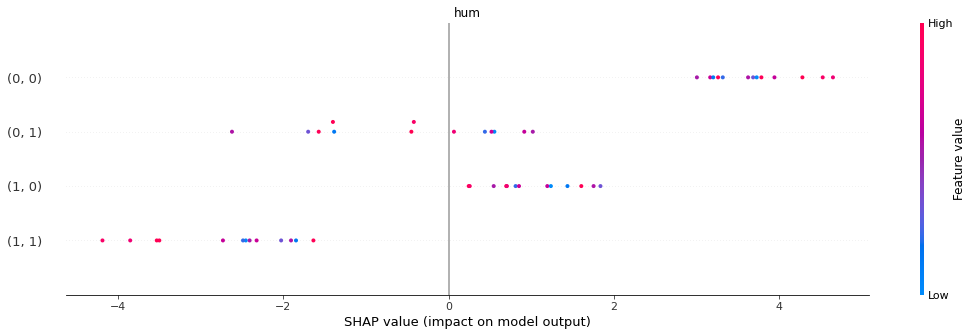

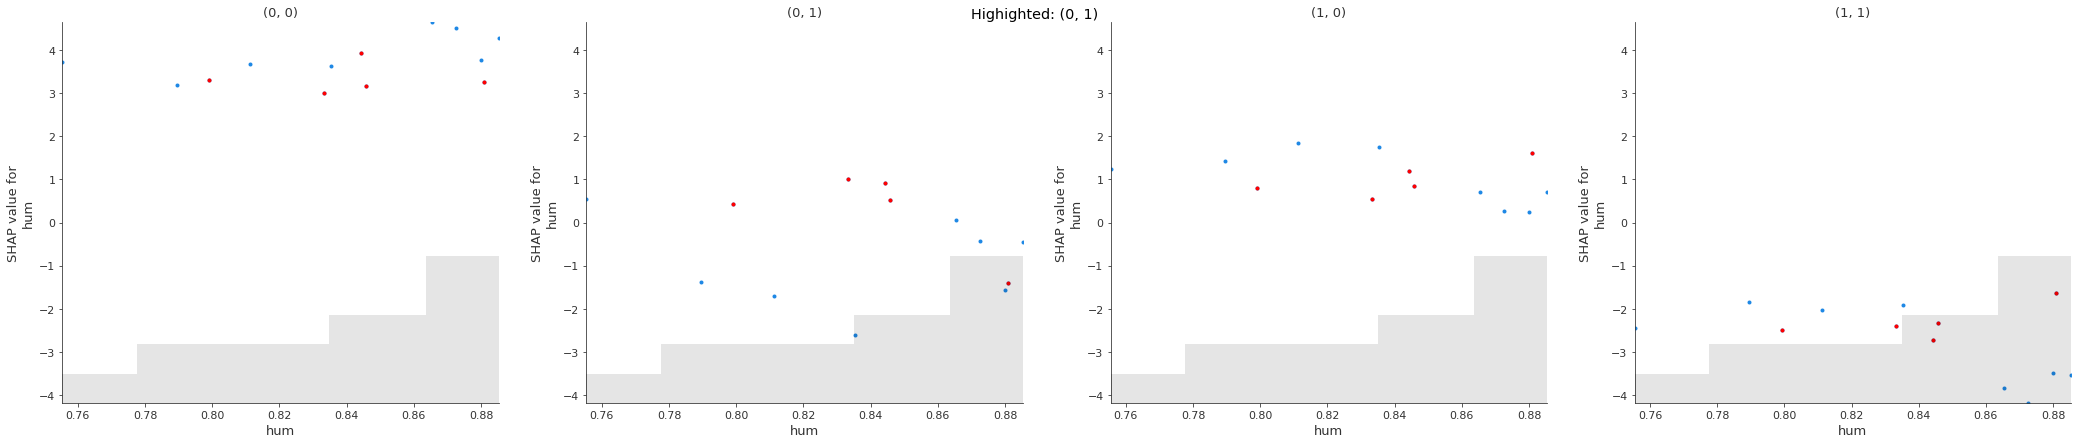

In [354]:
plot_next_feature()

Trends similar to global, increase lower for $(1,1)$

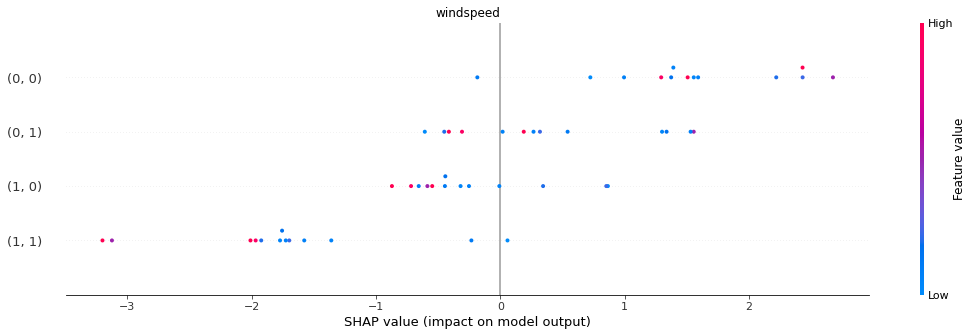

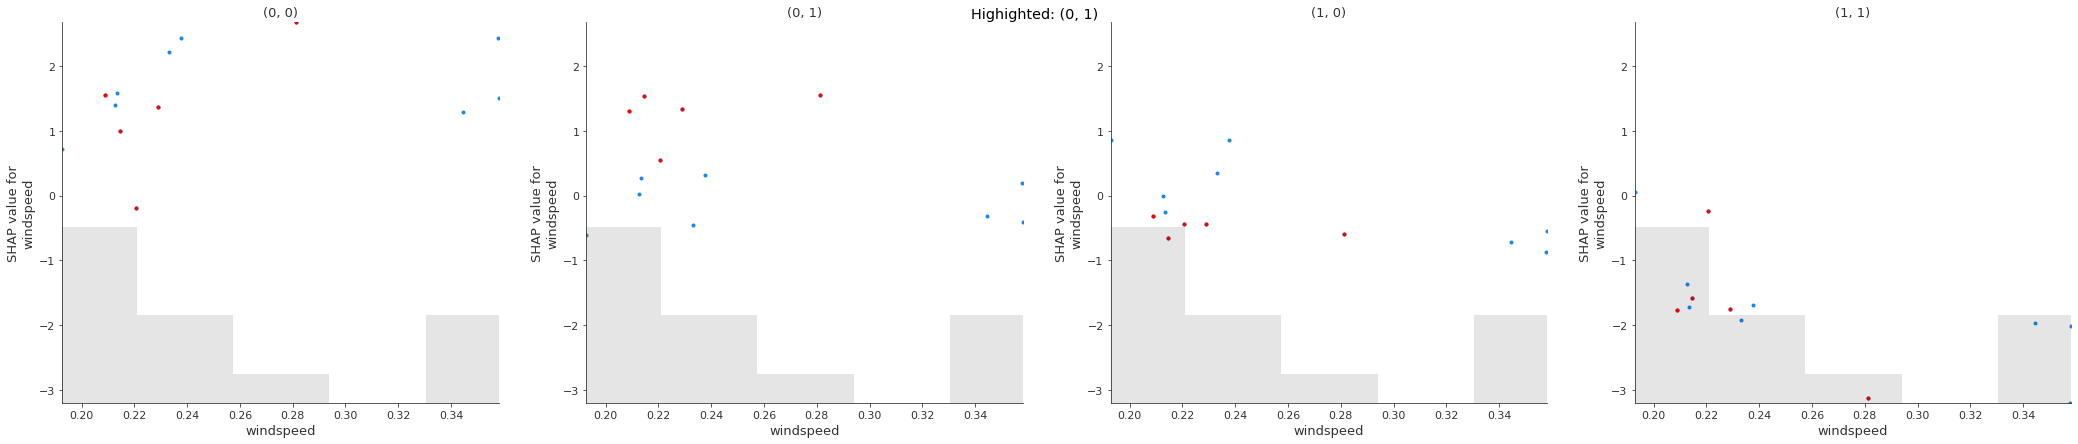

In [355]:
plot_next_feature()

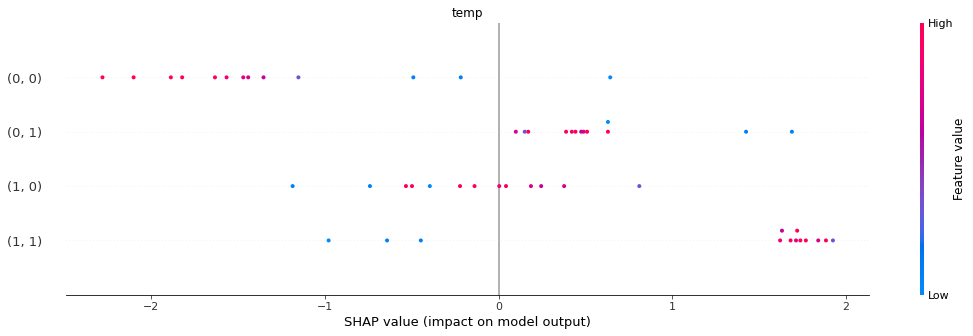

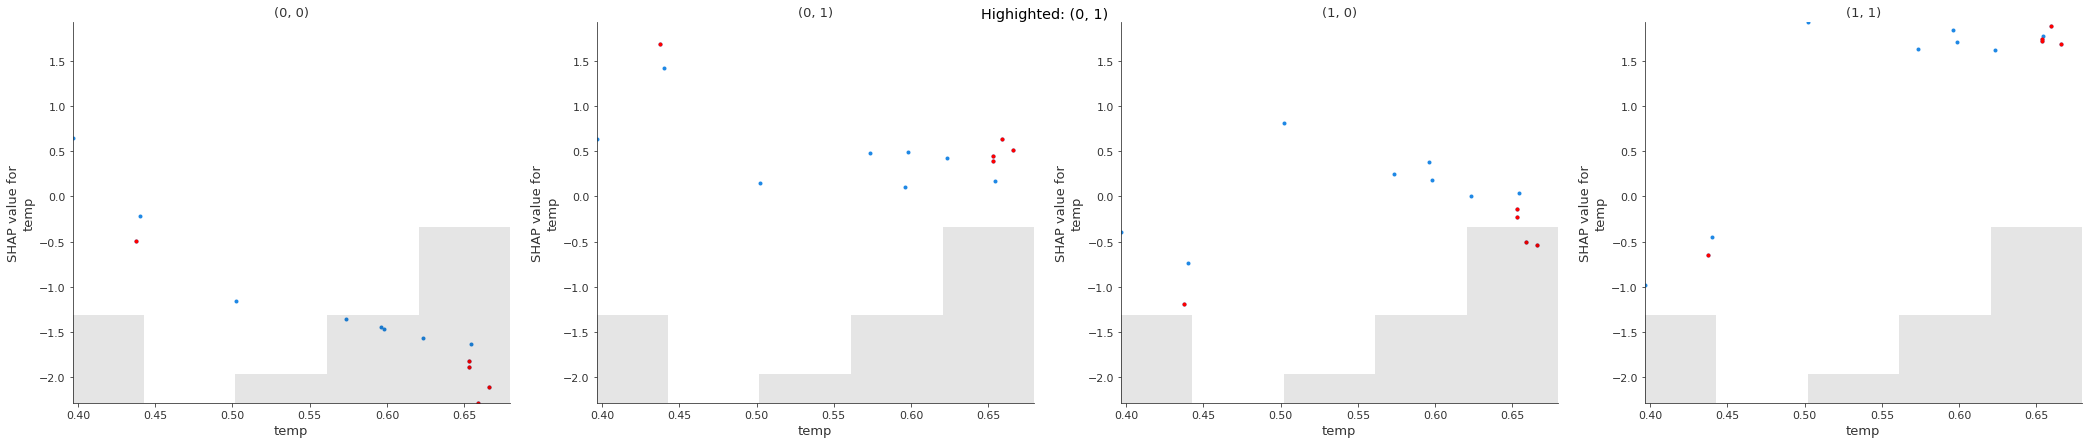

In [356]:
plot_next_feature()

#### Towards $(0,0)$

In [109]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['windspeed'] = 0.35
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN      1
(0, 1)     5.0      4

before  after
(0, 0)       8      8

In [110]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN      1
(0, 1)     5.0      4

before  after
(0, 0)       8      8

In [111]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['windspeed'] = 0.35
X['temp'] = 0.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN    5.0
(0, 1)     5.0    NaN

before  after
(0, 0)       8      8

In [112]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['mnth'] = 1
X['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN      3
(0, 1)     5.0      2

before  after
(0, 0)       8      8

#### Towards $(1,1)$

In [113]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['hum'] = 0.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)     5.0      1
(1, 1)     NaN      4

before  after
(0, 0)     8.0    NaN
(0, 1)     NaN    4.0
(1, 1)     NaN    4.0

In [114]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['windspeed'] = 0.1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)     5.0      1
(1, 1)     NaN      4

before  after
(0, 0)     8.0      1
(0, 1)     NaN      4
(1, 1)     NaN      3

In [115]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['weathersit'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)       5      5

before  after
(0, 0)     8.0      1
(0, 1)     NaN      6
(1, 1)     NaN      1

In [116]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['hum'] = 0.4
X['windspeed'] = 0.1
X['weathersit'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)     5.0      1
(1, 1)     NaN      4

before  after
(0, 0)     8.0    NaN
(0, 1)     NaN    3.0
(1, 1)     NaN    5.0

### diro2c

In [347]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [348]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 10min 15s, sys: 40.3 s, total: 10min 55s
Wall time: 3min 28s


In [349]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In the first figure we can see, that for $windspeed>0.3$ and $atemp<0.48$ there are
increasingly more instances classified equally and thus supporting theory 1.1 and 1.2.
Regarding theory 2.5, we see instances classified equally at 0.55 and above 0.65.

In the second figure, we can see that for $mnth>3$ there are more instances
classified equally, supporting theory 2.2 but no indication that
a higher `weekday` would have an influence. This might be due to the fact,
that the starting instance was of `weekday` Saturday.

In figure 3, we see that see more instances classified equally for `season` winter,
supporting theory 2.6 and also more instances classified equally for increased
values of `temp`, which supports theory 2.4, but also for lower values.


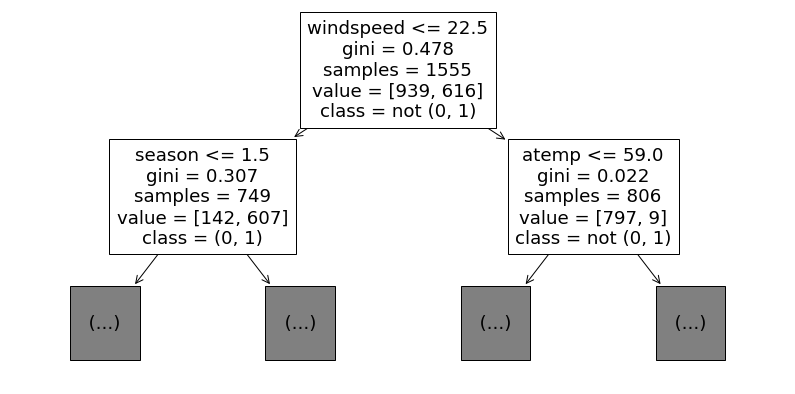

In [350]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=1)

diro2c concludes on windspeed as the most important feature, and also shows that there are fewer instances classified $(0,1)$ for higher windspeed values.

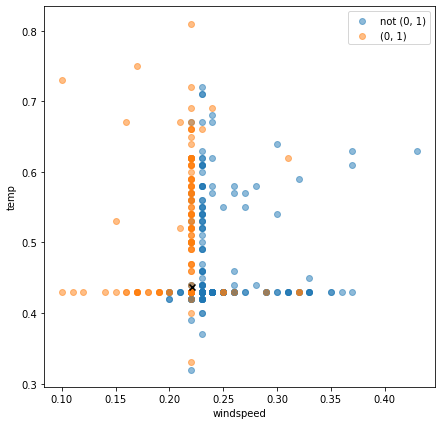

In [351]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'windspeed', 'temp', highlight=x)

## 5. Cluster

Differences to global level:
- temp values only range from 0.47 to 0.75
- atemp values only range from 0.47 ti 0.71
- hum values only range from 0.52 to 0.87
- windspeed values only range up to 0.22
- month values only range from 5 to 12

Effects based on global explanations:
- if temp and atemp were lower (<0.4), their effect would shift towards $(0,0)$
- if hum was lower (<0.5), its effect would shift towards $(1,1)$
- if month was lower (<3), its effect would shift towards $(0,0)$

Effects based on local explanations:
- if windspeed was lower (0.13) its effect would shift towards $(1,1)$
- if hum was lower (0.65) its effect would shift towards $(1,1)$

In [117]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c5       0       7       0      56

In [358]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

season       mnth    holiday    weekday  workingday  weathersit  \
count  63.000000  63.000000  63.000000  63.000000   63.000000   63.000000   
mean    2.936508   7.682540   0.047619   2.809524    0.809524    1.507937   
std     0.715565   1.932952   0.214669   1.730720    0.395831    0.535001   
min     2.000000   5.000000   0.000000   0.000000    0.000000    1.000000   
25%     2.000000   5.500000   0.000000   1.000000    1.000000    1.000000   
50%     3.000000   8.000000   0.000000   3.000000    1.000000    1.000000   
75%     3.000000   9.000000   0.000000   4.000000    1.000000    2.000000   
max     4.000000  12.000000   1.000000   6.000000    1.000000    3.000000   

            temp      atemp        hum  windspeed  
count  63.000000  63.000000  63.000000  63.000000  
mean    0.645635   0.607426   0.710979   0.132546  
std     0.070031   0.059411   0.062778   0.034402  
min     0.475833   0.469054   0.520000   0.064071  
25%     0.595000   0.565346   0.669375   0.108525  
50%     0.650000   0.603554   0.699167   0.134342  
75%     0.703333   0.655011   0.751875   0.153305  
max     0.753333   0.710246   0.871667   0.215171

### SHAP-based Difference Classifier Explanations

windspeed and humidity now on top

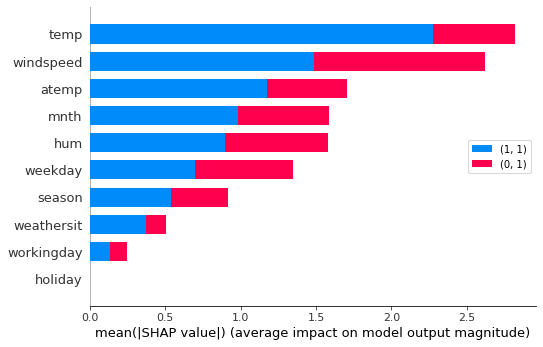

In [359]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

5

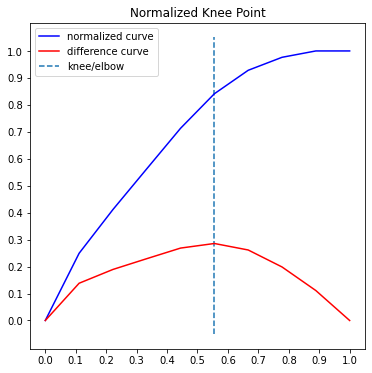

In [360]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

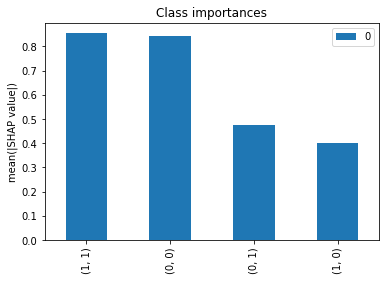

In [361]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [362]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

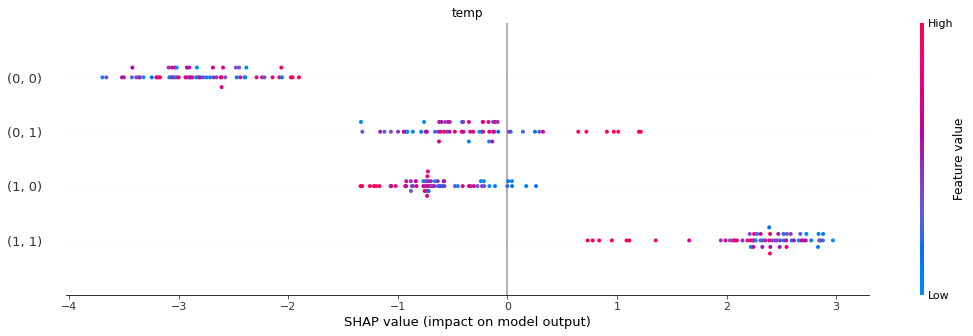

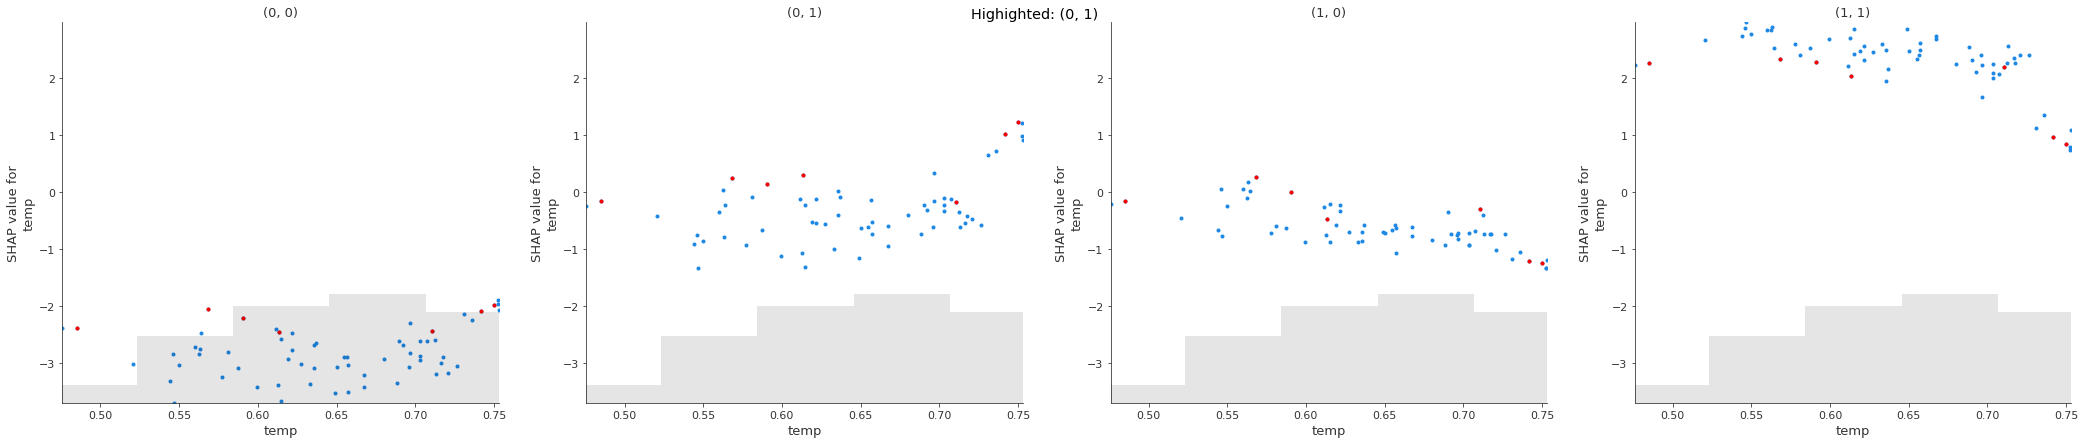

In [363]:
plot_next_feature()

only low windspeed values present, linear trend: decrease value => lower odds for difference class, increase odds for $(1,1)$

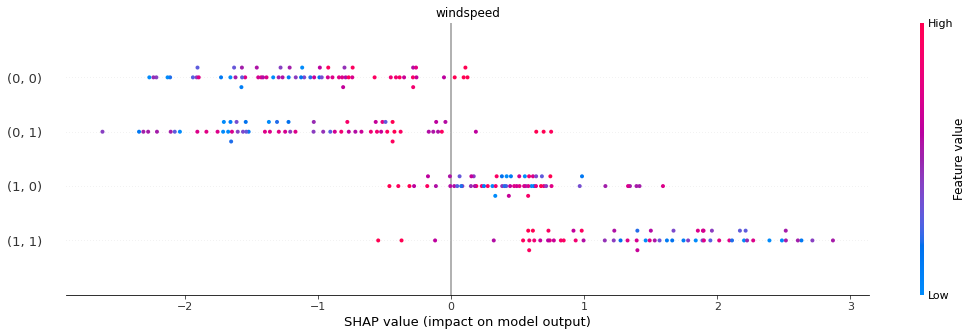

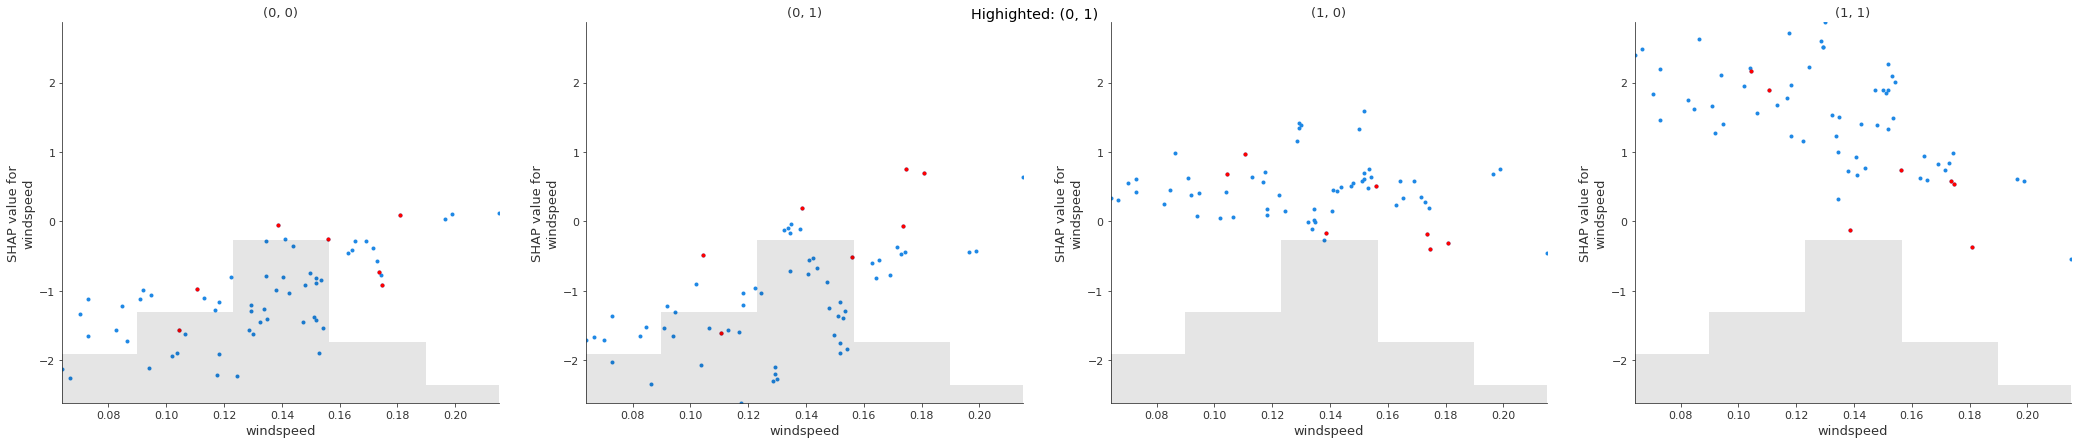

In [365]:
plot_next_feature()

only mid-to mid-high range present, no trend visible.

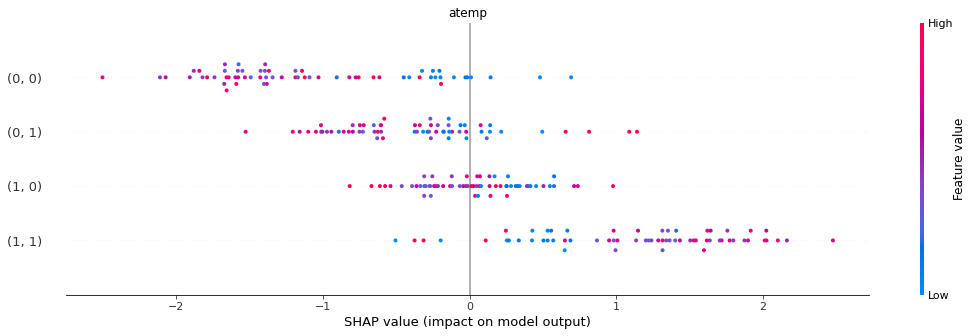

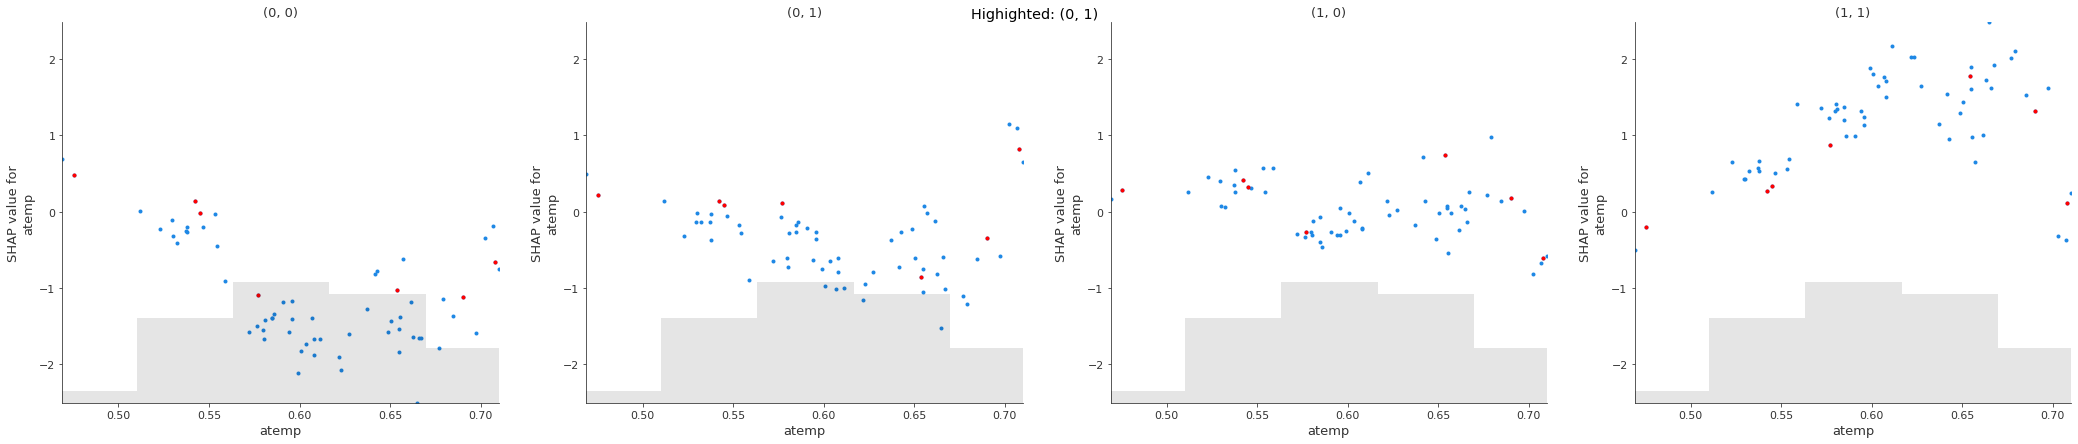

In [366]:
plot_next_feature()

only higher values present, no trend.

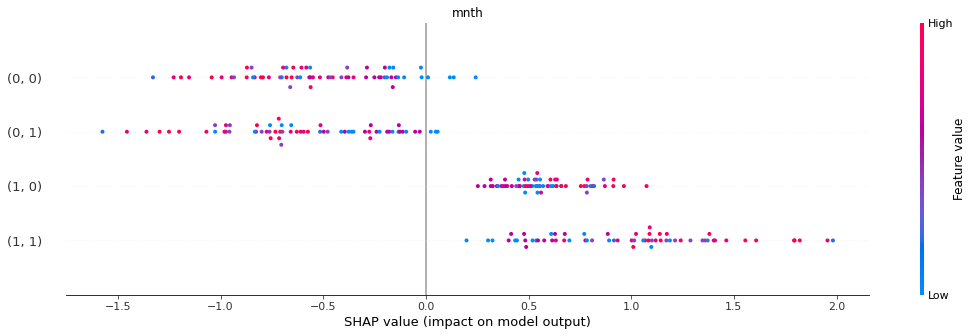

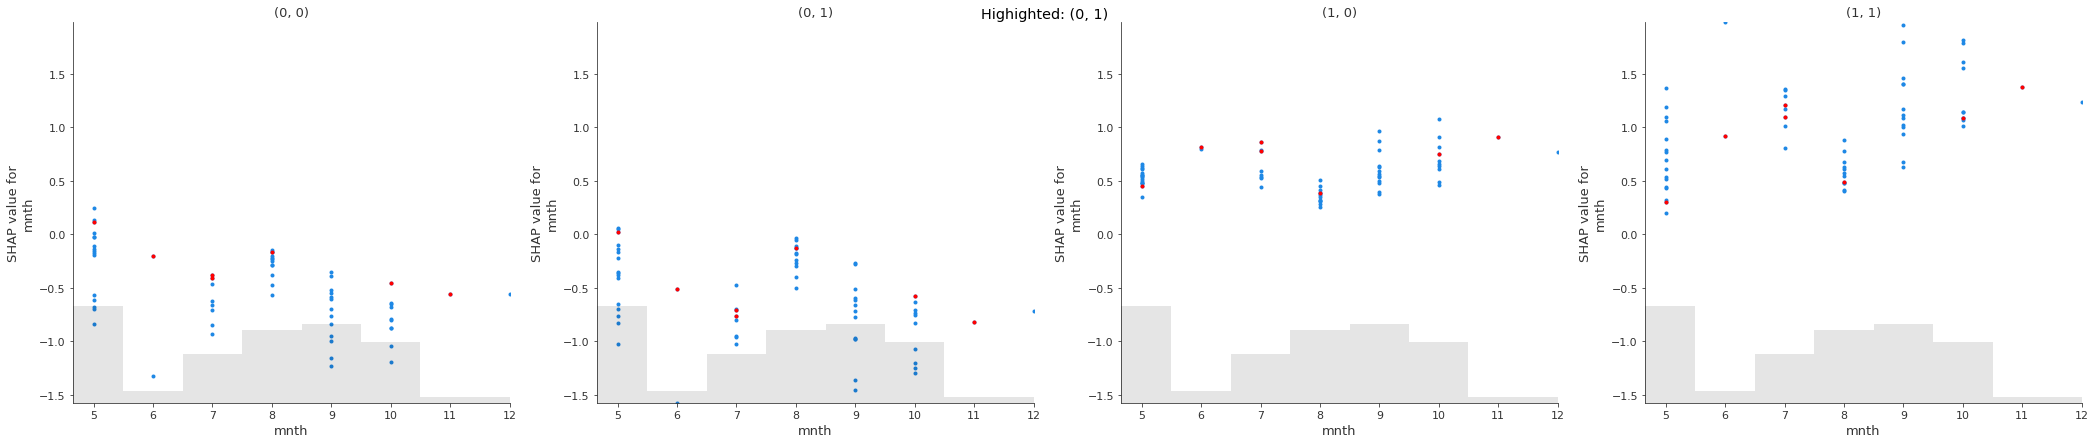

In [367]:
plot_next_feature()

weekday, all values present, instances classified differently on the lower side. increase value => decrease odds for difference class, increase odds for $(1,1)$

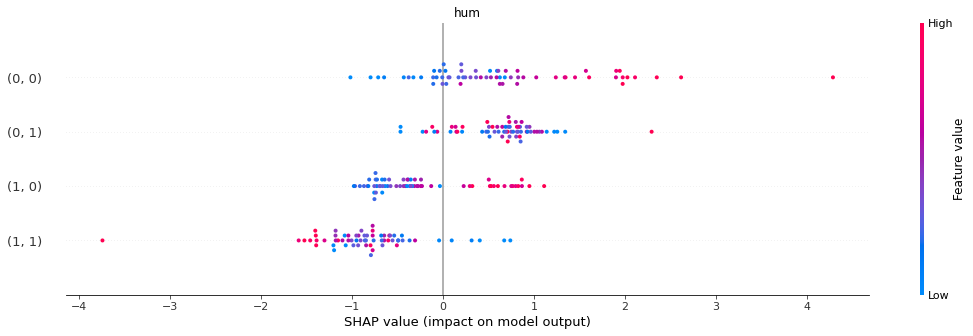

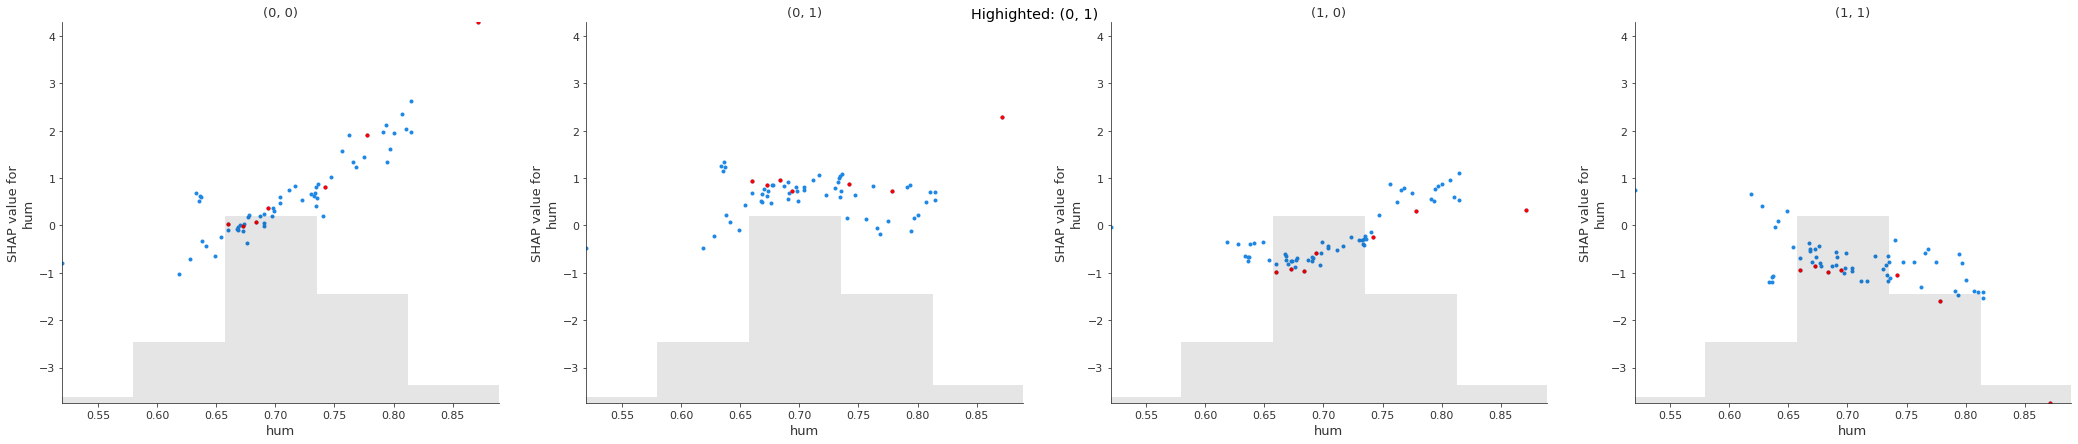

In [368]:
plot_next_feature()

#### Towards $(0,0)$

In [121]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.3
X['atemp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN      5
(0, 1)     7.0      2

before  after
(0, 0)     NaN   51.0
(0, 1)     NaN    5.0
(1, 1)    56.0    NaN

In [123]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['mnth'] = 1
X['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)       7      7

before  after
(0, 1)     NaN     48
(1, 1)    56.0      8

In [124]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['temp'] = 0.3
X['atemp'] = 0.3
X['mnth'] = 1
X['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)     NaN    7.0
(0, 1)     7.0    NaN

before  after
(0, 0)     NaN   56.0
(1, 1)    56.0    NaN

#### Towards $(1,1)$

In [118]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['windspeed'] = 0.13
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)     7.0      3
(1, 1)     NaN      4

before  after
(0, 1)     NaN      1
(1, 1)    56.0     55

In [119]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['hum'] = 0.65
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)     7.0      2
(1, 1)     NaN      5

before  after
(0, 1)     NaN      1
(1, 1)    56.0     55

In [120]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['windspeed'] = 0.13
X['hum'] = 0.65
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)     7.0    NaN
(1, 1)     NaN    7.0

before  after
(1, 1)      56     56

In [122]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['hum'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)     7.0    NaN
(1, 1)     NaN    7.0

before  after
(1, 1)      56     56

### diro2c

In [125]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [388]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 9min 50s, sys: 41.5 s, total: 10min 31s
Wall time: 3min 32s


In [126]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

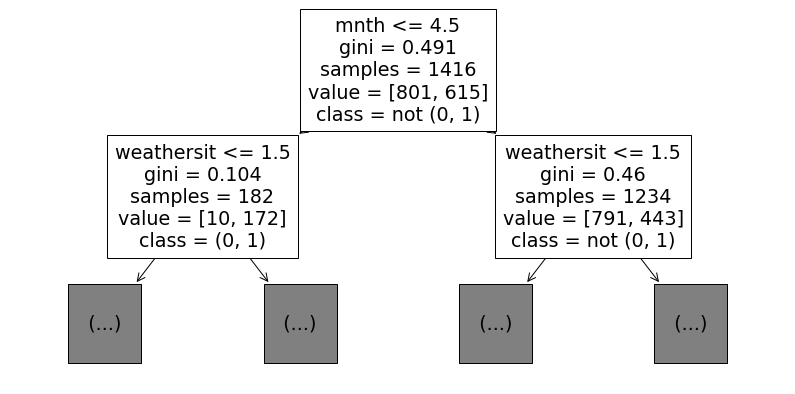

In [127]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=1)

We see the hypotheses about windspeed and humidity for low values confirmed. 

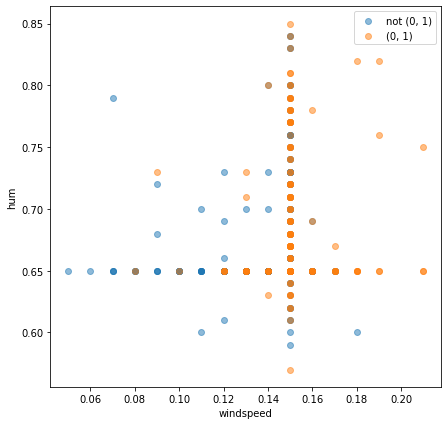

In [392]:
plot_diro2c_2d(explanation, 'windspeed', 'hum')

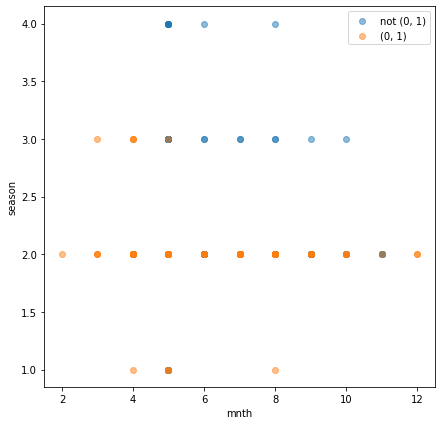

In [128]:
plot_diro2c_2d(explanation, 'mnth', 'season')

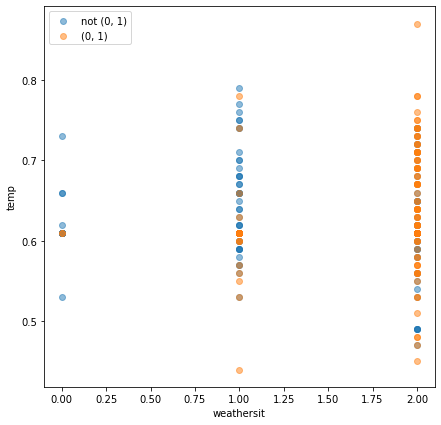

In [129]:
plot_diro2c_2d(explanation, 'weathersit', 'temp')

We see that weathersit plays a role as well:

In [130]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['weathersit'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
is_diff_class = pred_classes == diff_classes[0]
for mask in [is_diff_class, ~is_diff_class]:
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 1)     7.0      5
(1, 1)     NaN      2

before  after
(0, 1)     NaN      1
(1, 1)    56.0     55